In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!zip '/content/drive/MyDrive/Models/ensemble model/mdl.zip' '/content/drive/MyDrive/Models/ensemble model/fourth'

  adding: content/drive/MyDrive/Models/ensemble model/fourth/ (stored 0%)


In [ ]:
# !rm '/content/drive/MyDrive/Dataset/Persian/truely labedl/4513[UNK].png' #remove file
!unzip '/content/drive/MyDrive/Dataset/PerDs/tst.zip' -d '/content/drive/MyDrive/Dataset/PerDs' #unzip folder
# !rm -r '/content/drive/MyDrive/Dataset/Persian/truely labedl' #remove folder

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19, Xception, ResNet50, MobileNetV2
tf.keras.utils.set_random_seed(49)
import shutil
import pandas as pd

In [ ]:
def label_splitter(lbl):
  return lbl.split('/')[-1].split('.')[0]

# Path to the data directory
path = Path("/content/drive/MyDrive/Dataset/PerDs/train")
# Get list of all the images
path1 = sorted(list(path.glob('*.png')))
path2 = sorted(list(path.glob('*.jpg')))
path3 = sorted(list(path.glob('*/*.png')))
path = path1+path2+path3
images = sorted(list(map(lambda x:str(x), path)))
# Chosed_move = 600
# distance = '/content/drive/MyDrive/Dataset/PerDs/tst'
# for i in range(Chosed_move):
#   shutil.move(images[i], distance)
labels = list(map(lambda x:label_splitter(x), images))
labels = [label.strip() for label in labels]

In [ ]:
pos0 = []
pos1 = []
pos2=[]
pos3=[]
pos4=[]
for label in labels:
  i = list(label)
  pos0.append(int(i[0]))
  pos1.append(int(i[1]))
  pos2.append(int(i[2]))
  pos3.append(int(i[3]))
  pos4.append(int(i[4]))



dic = {'1':pos0, '2':pos1, '3':pos2, '4':pos3, '5':pos4}
df = pd.DataFrame(data=dic)
pos_0 = {i:pos0.count(i) for i in pos0}
pos_1 =  {i:pos1.count(i) for i in pos1}
pos_2 =  {i:pos2.count(i) for i in pos2}
pos_3 =  {i:pos3.count(i) for i in pos3}
pos_4 =  {i:pos4.count(i) for i in pos4}

df1 = pd.DataFrame({'Position 1':pd.Series(pos_0),'Position 2':pd.Series(pos_1), 'Position 3':pd.Series(pos_2),'Position 4':pd.Series(pos_3),'Position 5':pd.Series(pos_4)})
df2 = df1.T

print(np.sum(df1))
df2.plot.bar(figsize=(20, 12))

Position 1    19092
Position 2    19092
Position 3    19092
Position 4    19092
Position 5    19092
dtype: int64


In [ ]:
t_path = Path("/content/drive/MyDrive/Dataset/PerDs/tst")
# Get list of all the images
test_path = sorted(list(t_path.glob('*.png')))
test_path1 = sorted(list(t_path.glob('*.jpg')))
tst_path = test_path + test_path1
test_images = sorted(list(map(lambda x:str(x), tst_path)))
test_labels = list(map(lambda x:label_splitter(x), test_images))
test_labels = [label.strip() for label in test_labels]

In [ ]:
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

max_length = np.max([len(label)  for label in labels])

print("Max length: ", max_length)

# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

Number of images found:  19092
Number of labels found:  19092
Number of unique characters:  10
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Max length:  5


In [ ]:
def data_splitter(images, labels):
  x_train, x_valid, y_train, y_valid = train_test_split(images, labels, test_size=0.05)
  return x_train, y_train, x_valid, y_valid


#getting dataset
def get_dataset(img_path,label, train=True):

  image = tf.io.read_file(img_path)
  image = tf.io.decode_png(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [img_height, img_width])
  image = tf.transpose(image, [1,0,2])
  # if train:
  #   image = tf.image.random_brightness(image , 0.3)
  #   image = tf.image.random_contrast(image , 0.2, 0.5)
  label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
  return {"image": image, 'label':label}



def build_ds(image, label, train=True):

  ds = tf.data.Dataset.from_tensor_slices((image, label))
  ds = ds.map(lambda image, label:get_dataset(image, label, train), num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.repeat()
  ds = ds.batch(16, drop_remainder=True)
  return ds

In [ ]:
x_train, y_train, x_valid, y_valid= data_splitter(images, labels)
test_images = test_images + x_valid
test_labels += y_valid
train_ds = build_ds(x_train, y_train)
val_ds = build_ds(x_valid, y_valid, train=False)
test_ds = build_ds(test_images, test_labels, train = False)

In [ ]:
print('The number of train dataset:', len(x_train))
print('The number of validation dataset:', len(x_valid))
print('The number of test dataset:', len(test_images))

The number of train dataset: 18137
The number of validation dataset: 955
The number of test dataset: 1952


#Visualize samples

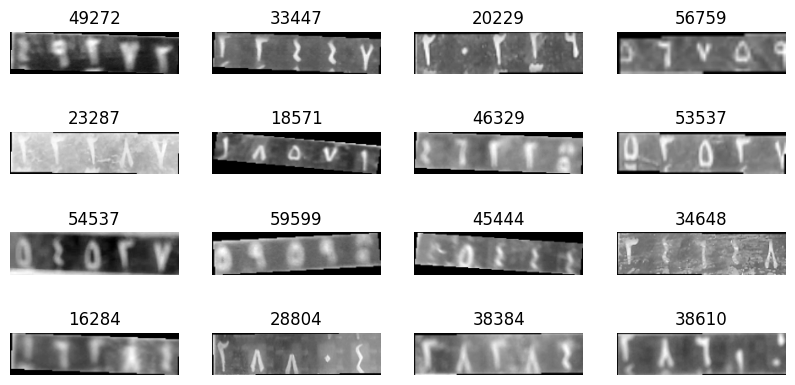

In [ ]:

_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_ds.take(2):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

*italicized text*# **Ensembling fourth and third model**

In [ ]:
from tqdm import tqdm
import cv2
def encode_single_sample(img_path):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img}

pred = []

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

for i in tqdm(range(len(test_images))):

  image_wo_label = cv2.imread(test_images[i])
  im = np.array(test_images[i:i+1])
  im = tf.data.Dataset.from_tensor_slices(im)
  img = im.map(encode_single_sample).batch(1)

  # prediction_model = keras.models.Model(
  #     model.get_layer(name="image").input, model.get_layer(name="dense2").output
  # )
  preds = ensemble_model.predict(img)
  preds = decode_batch_predictions(preds)
  pred.append(preds)

# **Model**

In [ ]:
def se(input, rate =16):
  #squeeze
  b, h, w, c = input.shape

  #excitation
  x = layers.GlobalAveragePooling2D()(input)
  x = layers.Dense(c//rate, activation='relu', use_bias=False)(x)
  x = layers.Dense(c, activation='sigmoid', use_bias=False)(x)
  x = tf.expand_dims(x, axis=1)
  x = tf.expand_dims(x, axis=1)
  x = input*x
  # x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
  # x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
  # x = layers.BatchNormalization()(x)
  return x


In [ ]:
def reshaping(output):
  _, h, w, c = output.shape
  print(output.shape)
  new_shape = ((h, w*c))
  x = layers.Reshape(target_shape=new_shape)(output)
  x = layers.Dense(256, activation="relu")(x)
  x = layers.Dropout(0.25)(x)
  return x

In [ ]:
def custom_model(input):
    x = layers.Conv2D(16, (5,5),  activation="relu", kernel_initializer="he_normal", padding="same", name="C1",)(input)
    x = layers.Conv2D(16, (5,5), activation="relu", kernel_initializer="he_normal", padding="same", name="C2",)(x)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Second conv block
    x = layers.Conv2D(32, (3,3),  activation="relu", kernel_initializer="he_normal", padding="same", name="C3",)(x)
    x = layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", name="C4",)(x)

    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    #Third conv block
    x = layers.Conv2D(64, (3,3),  activation="relu", kernel_initializer="he_normal", padding="same", name="C5",)(x)
    x = layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", name="C6",)(x)
    x = layers.MaxPooling2D((2, 2), name="pool3")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    #Fourth conv block
    x = layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", name="C7",)(x)
    x = layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", name="C8",)(x)
    x = layers.MaxPooling2D((2, 2), name="pool4")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    return x

In [ ]:
def custom_model2(input):
    x = layers.Conv2D(16, (5,5), activation="relu", kernel_initializer="he_normal", padding="same", name="C112",)(input)
    # x = layers.Conv2D(16, (5,5), activation="relu", kernel_initializer="he_normal", padding="same", name="C_",)(x)
    x = layers.MaxPooling2D((2, 2), name="pool1_1")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Second conv block
    # x = layers.Conv2D(32, (3,3), dilation_rate = 2,  activation="relu", kernel_initializer="he_normal", padding="same", name="C3",)(x)
    x = layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", name="C4_1",)(x)
    x = layers.MaxPooling2D((2, 2), name="pool2_1")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    #Third conv block
    # x = layers.Conv2D(64, (3,3), dilation_rate = 2,  activation="relu", kernel_initializer="he_normal", padding="same", name="C5",)(x)
    x = layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", name="C6_1",)(x)
    x = layers.MaxPooling2D((2, 2), name="pool3_")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    #Fourth conv block
    # x = layers.Conv2D(128, (3,3), dilation_rate = 2, activation="relu", kernel_initializer="he_normal", padding="same", name="C7",)(x)
    x = layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", name="C8_1",)(x)
    x = layers.MaxPooling2D((2, 2), name="pool4_1")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    return x

In [ ]:
input_img = layers.Input(shape=(50, 200, 3), name="image", dtype="float32")
   # x = layers.ZeroPadding2D(padding = (1, 1))(input_img)

x = custom_model3(input_img)
model = tf.keras.models.Model(inputs = input_img, outputs=x)
opt = keras.optimizers.Adam(lr=0.001)
    # Compile the model and return
model.compile(optimizer=opt)
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 50, 200, 3)]      0         
                                                                 
 conv2d_64 (Conv2D)          (None, 50, 200, 64)       1792      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 25, 100, 64)      0         
 g2D)                                                            
                                                                 
 zero_padding2d_32 (ZeroPadd  (None, 27, 102, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_65 (Conv2D)          (None, 25, 100, 128)      73856     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 12, 50, 128)      0  

In [ ]:

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred



def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 3), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")


    # ---------------------
    # Custom  MODEL
    # -------------------

    x1 = custom_model(input_img)
    x1 = se(x1)
    x1 = reshaping(x1)

    x2 = custom_model2(input_img)
    x2 = se(x2)
    x2 = reshaping(x2)


    #---------------------
    #Concatenate outputs
    #-------------------


    out_concat = layers.Concatenate()([x1,x2])
    # out_concat = se(out_concat)
    # out_concat = reshaping(out_concat)
    # print(out_concat)
    # # RNNs
    gru1 = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(out_concat)
    gru2 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(gru1)
    gru3 = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(gru2)
    # lstm1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    # lstm2= layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(lstm1)

    # x = layers.Concatenate()([gru2, lstm2])
    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary())+1, activation="softmax", name="dense2"
    )(gru3)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam(lr=0.001)
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

83683744/83683744 [==============================] - 3s 0us/step


KerasTensor(type_spec=TensorSpec(shape=(None, 25, 6, 728), dtype=tf.float32, name=None), name='block4_sepconv2_bn/FusedBatchNormV3:0', description="created by layer 'block4_sepconv2_bn'")
(None, 12, 3, 728)
KerasTensor(type_spec=TensorSpec(shape=(None, 25, 7, 192), dtype=tf.float32, name=None), name='block_6_expand_relu/Relu6:0', description="created by layer 'block_6_expand_relu'")
(None, 12, 3, 192)


Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 3)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 100, 25, 32)          864       ['image[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 100, 25, 32)          128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 100, 25, 32)          0         ['bn_Conv1[0][0]'] 

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
epochs = 200
early_stopping_patience = 20
checkpath = '/content/drive/MyDrive/Models/resnet-xcept'
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
reduced = keras.callbacks.ReduceLROnPlateau(factor=0.8, monitor='val_loss', patience = 5)
checkpoint = keras.callbacks.ModelCheckpoint(filepath = checkpath, monitor='val_loss', save_best_only = True, mode='min')
# Train the model
history = model.fit(
    train_ds,
    steps_per_epoch = len(x_train)//batch_size,
    batch_size=batch_size,
    validation_data=val_ds,
    validation_steps=len(x_valid)//batch_size,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint],
)


Epoch 1/200
1133/1133 [==============================] - 3893s 3s/step - loss: 2.8469 - val_loss: 0.6397
Epoch 2/200
1133/1133 [==============================] - 119s 105ms/step - loss: 0.4069 - val_loss: 0.4315
Epoch 3/200
1133/1133 [==============================] - 78s 69ms/step - loss: 0.3469 - val_loss: 0.5348
Epoch 4/200
1133/1133 [==============================] - 117s 103ms/step - loss: 0.2799 - val_loss: 0.3658
Epoch 5/200
1133/1133 [==============================] - 118s 104ms/step - loss: 0.2641 - val_loss: 0.3434
Epoch 6/200
1133/1133 [==============================] - 78s 69ms/step - loss: 0.2472 - val_loss: 0.3780
Epoch 7/200
1133/1133 [==============================] - 117s 103ms/step - loss: 0.2308 - val_loss: 0.3164
Epoch 8/200
1133/1133 [==============================] - 77s 68ms/step - loss: 0.2146 - val_loss: 0.3252
Epoch 9/200
1133/1133 [==============================] - 78s 69ms/step - loss: 0.1928 - val_loss: 0.3346
Epoch 10/200
1133/1133 [=======================

In [ ]:
np.save('/content/drive/MyDrive/mobi_xcept_hist/MX.npy', history.history)

In [ ]:
tf.keras.models.save_model(filepath = '/content/drive/MyDrive/Models/mobimobi/', model=model)

# Load the model for further analysis

In [ ]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/Models/model')
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model1.get_layer(name="image").input, model1.get_layer(name="dense2").output
)
prediction_model.summary()

In [ ]:
from tqdm import tqdm
import cv2
def encode_single_sample(img_path):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=3)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img}

pred = []

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

for i in tqdm(range(len(test_images))):

  image_wo_label = cv2.imread(test_images[i])
  im = np.array(test_images[i:i+1])
  im = tf.data.Dataset.from_tensor_slices(im)
  img = im.map(encode_single_sample).batch(1)


  preds = prediction_model.predict(img)
  preds = decode_batch_predictions(preds)
  pred.append(preds)

  0%|          | 0/1952 [00:00<?, ?it/s]

1/1 [==============================] - 5s 5s/step


  0%|          | 1/1952 [00:05<2:53:01,  5.32s/it]

1/1 [==============================] - 0s 88ms/step


  0%|          | 2/1952 [00:05<1:14:47,  2.30s/it]

1/1 [==============================] - 0s 87ms/step


  0%|          | 3/1952 [00:05<42:47,  1.32s/it]  

1/1 [==============================] - 0s 93ms/step


  0%|          | 4/1952 [00:05<28:39,  1.13it/s]

1/1 [==============================] - 0s 90ms/step


  0%|          | 5/1952 [00:06<20:03,  1.62it/s]

1/1 [==============================] - 0s 84ms/step


  0%|          | 6/1952 [00:06<14:54,  2.18it/s]

1/1 [==============================] - 0s 86ms/step


  0%|          | 7/1952 [00:06<11:26,  2.83it/s]

1/1 [==============================] - 0s 81ms/step


  0%|          | 8/1952 [00:06<09:05,  3.56it/s]

1/1 [==============================] - 0s 89ms/step


  0%|          | 9/1952 [00:06<07:36,  4.26it/s]

1/1 [==============================] - 0s 84ms/step


  1%|          | 10/1952 [00:06<06:32,  4.95it/s]

1/1 [==============================] - 0s 85ms/step


  1%|          | 11/1952 [00:06<05:48,  5.57it/s]

1/1 [==============================] - 0s 79ms/step


  1%|          | 12/1952 [00:06<05:21,  6.03it/s]

1/1 [==============================] - 0s 82ms/step


  1%|          | 13/1952 [00:07<04:58,  6.50it/s]

1/1 [==============================] - 0s 85ms/step


  1%|          | 14/1952 [00:07<04:45,  6.79it/s]

1/1 [==============================] - 0s 79ms/step


  1%|          | 15/1952 [00:07<04:32,  7.10it/s]

1/1 [==============================] - 0s 87ms/step


  1%|          | 16/1952 [00:07<05:11,  6.22it/s]

1/1 [==============================] - 0s 86ms/step


  1%|          | 17/1952 [00:07<04:55,  6.56it/s]

1/1 [==============================] - 0s 81ms/step


  1%|          | 18/1952 [00:07<04:43,  6.82it/s]

1/1 [==============================] - 0s 81ms/step


  1%|          | 19/1952 [00:07<04:40,  6.88it/s]

1/1 [==============================] - 0s 87ms/step


  1%|          | 20/1952 [00:08<04:35,  7.02it/s]

1/1 [==============================] - 0s 91ms/step


  1%|          | 21/1952 [00:08<05:14,  6.14it/s]

1/1 [==============================] - 0s 84ms/step


  1%|          | 22/1952 [00:08<04:56,  6.52it/s]

1/1 [==============================] - 0s 80ms/step


  1%|          | 23/1952 [00:08<04:40,  6.87it/s]

1/1 [==============================] - 0s 83ms/step


  1%|          | 24/1952 [00:08<04:32,  7.09it/s]

1/1 [==============================] - 0s 80ms/step


  1%|▏         | 25/1952 [00:08<04:23,  7.31it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▏         | 26/1952 [00:08<04:26,  7.24it/s]

1/1 [==============================] - 0s 85ms/step


  1%|▏         | 27/1952 [00:09<04:25,  7.26it/s]

1/1 [==============================] - 0s 79ms/step


  1%|▏         | 28/1952 [00:09<04:18,  7.44it/s]

1/1 [==============================] - 0s 86ms/step


  1%|▏         | 29/1952 [00:09<04:21,  7.35it/s]

1/1 [==============================] - 0s 86ms/step


  2%|▏         | 30/1952 [00:09<05:05,  6.30it/s]

1/1 [==============================] - 0s 82ms/step


  2%|▏         | 31/1952 [00:09<04:48,  6.67it/s]

1/1 [==============================] - 0s 90ms/step


  2%|▏         | 32/1952 [00:09<05:21,  5.98it/s]

1/1 [==============================] - 0s 80ms/step


  2%|▏         | 33/1952 [00:10<04:57,  6.46it/s]

1/1 [==============================] - 0s 83ms/step


  2%|▏         | 34/1952 [00:10<04:47,  6.68it/s]

1/1 [==============================] - 0s 82ms/step


  2%|▏         | 35/1952 [00:10<04:40,  6.84it/s]

1/1 [==============================] - 0s 91ms/step


  2%|▏         | 36/1952 [00:10<04:34,  6.97it/s]

1/1 [==============================] - 0s 81ms/step


  2%|▏         | 37/1952 [00:10<04:27,  7.16it/s]

1/1 [==============================] - 0s 83ms/step


  2%|▏         | 38/1952 [00:10<04:24,  7.24it/s]

1/1 [==============================] - 0s 84ms/step


  2%|▏         | 39/1952 [00:10<04:20,  7.35it/s]

1/1 [==============================] - 0s 89ms/step


  2%|▏         | 40/1952 [00:11<05:04,  6.27it/s]

1/1 [==============================] - 0s 81ms/step


  2%|▏         | 41/1952 [00:11<04:50,  6.58it/s]

1/1 [==============================] - 0s 81ms/step


  2%|▏         | 42/1952 [00:11<05:23,  5.90it/s]

1/1 [==============================] - 0s 82ms/step


  2%|▏         | 43/1952 [00:11<05:00,  6.34it/s]

1/1 [==============================] - 0s 80ms/step


  2%|▏         | 44/1952 [00:11<04:48,  6.62it/s]

1/1 [==============================] - 0s 78ms/step


  2%|▏         | 45/1952 [00:11<04:36,  6.90it/s]

1/1 [==============================] - 0s 78ms/step


  2%|▏         | 46/1952 [00:11<04:32,  6.99it/s]

1/1 [==============================] - 0s 78ms/step


  2%|▏         | 47/1952 [00:12<04:26,  7.16it/s]

1/1 [==============================] - 0s 81ms/step


  2%|▏         | 48/1952 [00:12<04:19,  7.34it/s]

1/1 [==============================] - 0s 79ms/step


  3%|▎         | 49/1952 [00:12<04:14,  7.47it/s]

1/1 [==============================] - 0s 90ms/step


  3%|▎         | 50/1952 [00:12<04:23,  7.21it/s]

1/1 [==============================] - 0s 91ms/step


  3%|▎         | 51/1952 [00:12<04:25,  7.17it/s]

1/1 [==============================] - 0s 81ms/step


  3%|▎         | 52/1952 [00:12<04:22,  7.23it/s]

1/1 [==============================] - 0s 94ms/step


  3%|▎         | 53/1952 [00:12<04:24,  7.17it/s]

1/1 [==============================] - 0s 89ms/step


  3%|▎         | 54/1952 [00:13<04:24,  7.18it/s]

1/1 [==============================] - 0s 85ms/step


  3%|▎         | 55/1952 [00:13<04:20,  7.27it/s]

1/1 [==============================] - 0s 83ms/step


  3%|▎         | 56/1952 [00:13<04:17,  7.35it/s]

1/1 [==============================] - 0s 88ms/step


  3%|▎         | 57/1952 [00:13<04:18,  7.34it/s]

1/1 [==============================] - 0s 92ms/step


  3%|▎         | 58/1952 [00:13<05:03,  6.23it/s]

1/1 [==============================] - 0s 81ms/step


  3%|▎         | 59/1952 [00:13<04:46,  6.60it/s]

1/1 [==============================] - 0s 85ms/step


  3%|▎         | 60/1952 [00:13<04:36,  6.84it/s]

1/1 [==============================] - 0s 108ms/step


  3%|▎         | 61/1952 [00:14<05:19,  5.92it/s]

1/1 [==============================] - 0s 80ms/step


  3%|▎         | 62/1952 [00:14<04:56,  6.37it/s]

1/1 [==============================] - 0s 83ms/step


  3%|▎         | 63/1952 [00:14<04:40,  6.74it/s]

1/1 [==============================] - 0s 122ms/step


  3%|▎         | 64/1952 [00:14<04:55,  6.39it/s]

1/1 [==============================] - 0s 125ms/step


  3%|▎         | 65/1952 [00:14<05:40,  5.54it/s]

1/1 [==============================] - 0s 127ms/step


  3%|▎         | 66/1952 [00:15<05:50,  5.39it/s]

1/1 [==============================] - 0s 132ms/step


  3%|▎         | 67/1952 [00:15<06:07,  5.12it/s]

1/1 [==============================] - 0s 141ms/step


  3%|▎         | 68/1952 [00:15<06:33,  4.79it/s]

1/1 [==============================] - 0s 141ms/step


  4%|▎         | 69/1952 [00:15<06:32,  4.79it/s]

1/1 [==============================] - 0s 139ms/step


  4%|▎         | 70/1952 [00:15<06:51,  4.58it/s]

1/1 [==============================] - 0s 151ms/step


  4%|▎         | 71/1952 [00:16<06:51,  4.57it/s]

1/1 [==============================] - 0s 128ms/step


  4%|▎         | 72/1952 [00:16<06:46,  4.62it/s]

1/1 [==============================] - 0s 119ms/step


  4%|▎         | 73/1952 [00:16<06:31,  4.80it/s]

1/1 [==============================] - 0s 133ms/step


  4%|▍         | 74/1952 [00:16<06:47,  4.61it/s]

1/1 [==============================] - 0s 140ms/step


  4%|▍         | 75/1952 [00:17<07:07,  4.39it/s]

1/1 [==============================] - 0s 141ms/step


  4%|▍         | 76/1952 [00:17<06:56,  4.51it/s]

1/1 [==============================] - 0s 138ms/step


  4%|▍         | 77/1952 [00:17<06:47,  4.60it/s]

1/1 [==============================] - 0s 133ms/step


  4%|▍         | 78/1952 [00:17<06:34,  4.75it/s]

1/1 [==============================] - 0s 139ms/step


  4%|▍         | 79/1952 [00:17<06:31,  4.78it/s]

1/1 [==============================] - 0s 135ms/step


  4%|▍         | 80/1952 [00:18<06:22,  4.89it/s]

1/1 [==============================] - 0s 152ms/step


  4%|▍         | 81/1952 [00:18<06:50,  4.56it/s]

1/1 [==============================] - 0s 133ms/step


  4%|▍         | 82/1952 [00:18<07:03,  4.41it/s]

1/1 [==============================] - 0s 142ms/step


  4%|▍         | 83/1952 [00:18<07:12,  4.32it/s]

1/1 [==============================] - 0s 85ms/step


  4%|▍         | 84/1952 [00:18<06:18,  4.93it/s]

1/1 [==============================] - 0s 84ms/step


  4%|▍         | 85/1952 [00:19<05:38,  5.52it/s]

1/1 [==============================] - 0s 85ms/step


  4%|▍         | 86/1952 [00:19<05:15,  5.91it/s]

1/1 [==============================] - 0s 95ms/step


  4%|▍         | 87/1952 [00:19<05:02,  6.17it/s]

1/1 [==============================] - 0s 87ms/step


  5%|▍         | 88/1952 [00:19<04:47,  6.49it/s]

1/1 [==============================] - 0s 83ms/step


  5%|▍         | 89/1952 [00:19<04:35,  6.77it/s]

1/1 [==============================] - 0s 88ms/step


  5%|▍         | 90/1952 [00:19<04:29,  6.92it/s]

1/1 [==============================] - 0s 84ms/step


  5%|▍         | 91/1952 [00:19<04:21,  7.11it/s]

1/1 [==============================] - 0s 79ms/step


  5%|▍         | 92/1952 [00:19<04:15,  7.27it/s]

1/1 [==============================] - 0s 86ms/step


  5%|▍         | 93/1952 [00:20<04:15,  7.29it/s]

1/1 [==============================] - 0s 100ms/step


  5%|▍         | 94/1952 [00:20<04:22,  7.09it/s]

1/1 [==============================] - 0s 82ms/step


  5%|▍         | 95/1952 [00:20<04:20,  7.14it/s]

1/1 [==============================] - 0s 83ms/step


  5%|▍         | 96/1952 [00:20<04:58,  6.22it/s]

1/1 [==============================] - 0s 79ms/step


  5%|▍         | 97/1952 [00:20<04:40,  6.62it/s]

1/1 [==============================] - 0s 79ms/step


  5%|▌         | 98/1952 [00:20<04:27,  6.93it/s]

1/1 [==============================] - 0s 82ms/step


  5%|▌         | 99/1952 [00:21<05:04,  6.08it/s]

1/1 [==============================] - 0s 79ms/step


  5%|▌         | 100/1952 [00:21<04:45,  6.49it/s]

1/1 [==============================] - 0s 88ms/step


  5%|▌         | 101/1952 [00:21<04:35,  6.71it/s]

1/1 [==============================] - 0s 84ms/step


  5%|▌         | 102/1952 [00:21<04:24,  7.00it/s]

1/1 [==============================] - 0s 88ms/step


  5%|▌         | 103/1952 [00:21<05:01,  6.13it/s]

1/1 [==============================] - 0s 81ms/step


  5%|▌         | 104/1952 [00:21<04:43,  6.52it/s]

1/1 [==============================] - 0s 84ms/step


  5%|▌         | 105/1952 [00:21<04:34,  6.73it/s]

1/1 [==============================] - 0s 80ms/step


  5%|▌         | 106/1952 [00:22<04:25,  6.95it/s]

1/1 [==============================] - 0s 85ms/step


  5%|▌         | 107/1952 [00:22<04:24,  6.97it/s]

1/1 [==============================] - 0s 95ms/step


  6%|▌         | 108/1952 [00:22<04:26,  6.91it/s]

1/1 [==============================] - 0s 85ms/step


  6%|▌         | 109/1952 [00:22<04:24,  6.96it/s]

1/1 [==============================] - 0s 94ms/step


  6%|▌         | 110/1952 [00:22<05:11,  5.90it/s]

1/1 [==============================] - 0s 86ms/step


  6%|▌         | 111/1952 [00:22<04:53,  6.27it/s]

1/1 [==============================] - 0s 79ms/step


  6%|▌         | 112/1952 [00:23<04:39,  6.59it/s]

1/1 [==============================] - 0s 89ms/step


  6%|▌         | 113/1952 [00:23<04:33,  6.73it/s]

1/1 [==============================] - 0s 86ms/step


  6%|▌         | 114/1952 [00:23<04:27,  6.87it/s]

1/1 [==============================] - 0s 84ms/step


  6%|▌         | 115/1952 [00:23<04:29,  6.82it/s]

1/1 [==============================] - 0s 85ms/step


  6%|▌         | 116/1952 [00:23<04:31,  6.77it/s]

1/1 [==============================] - 0s 94ms/step


  6%|▌         | 117/1952 [00:23<05:10,  5.91it/s]

1/1 [==============================] - 0s 91ms/step


  6%|▌         | 118/1952 [00:23<04:53,  6.25it/s]

1/1 [==============================] - 0s 87ms/step


  6%|▌         | 119/1952 [00:24<04:48,  6.36it/s]

1/1 [==============================] - 0s 82ms/step


  6%|▌         | 120/1952 [00:24<04:39,  6.55it/s]

1/1 [==============================] - 0s 99ms/step


  6%|▌         | 121/1952 [00:24<05:16,  5.79it/s]

1/1 [==============================] - 0s 83ms/step


  6%|▋         | 122/1952 [00:24<04:53,  6.24it/s]

1/1 [==============================] - 0s 85ms/step


  6%|▋         | 123/1952 [00:24<04:38,  6.56it/s]

1/1 [==============================] - 0s 82ms/step


  6%|▋         | 124/1952 [00:24<04:30,  6.75it/s]

1/1 [==============================] - 0s 89ms/step


  6%|▋         | 125/1952 [00:25<04:30,  6.75it/s]

1/1 [==============================] - 0s 91ms/step


  6%|▋         | 126/1952 [00:25<05:12,  5.85it/s]

1/1 [==============================] - 0s 98ms/step


  7%|▋         | 127/1952 [00:25<05:41,  5.35it/s]

1/1 [==============================] - 0s 89ms/step


  7%|▋         | 128/1952 [00:25<05:15,  5.78it/s]

1/1 [==============================] - 0s 87ms/step


  7%|▋         | 129/1952 [00:25<05:03,  6.00it/s]

1/1 [==============================] - 0s 98ms/step


  7%|▋         | 130/1952 [00:25<04:57,  6.13it/s]

1/1 [==============================] - 0s 85ms/step


  7%|▋         | 131/1952 [00:26<04:43,  6.43it/s]

1/1 [==============================] - 0s 87ms/step


  7%|▋         | 132/1952 [00:26<04:39,  6.52it/s]

1/1 [==============================] - 0s 89ms/step


  7%|▋         | 133/1952 [00:26<04:36,  6.59it/s]

1/1 [==============================] - 0s 86ms/step


  7%|▋         | 134/1952 [00:26<04:32,  6.67it/s]

1/1 [==============================] - 0s 82ms/step


  7%|▋         | 135/1952 [00:26<04:24,  6.87it/s]

1/1 [==============================] - 0s 86ms/step


  7%|▋         | 136/1952 [00:26<04:25,  6.84it/s]

1/1 [==============================] - 0s 89ms/step


  7%|▋         | 137/1952 [00:27<05:01,  6.01it/s]

1/1 [==============================] - 0s 95ms/step


  7%|▋         | 138/1952 [00:27<04:57,  6.11it/s]

1/1 [==============================] - 0s 83ms/step


  7%|▋         | 139/1952 [00:27<04:41,  6.45it/s]

1/1 [==============================] - 0s 96ms/step


  7%|▋         | 140/1952 [00:27<05:17,  5.72it/s]

1/1 [==============================] - 0s 88ms/step


  7%|▋         | 141/1952 [00:27<05:36,  5.39it/s]

1/1 [==============================] - 0s 84ms/step


  7%|▋         | 142/1952 [00:27<05:07,  5.89it/s]

1/1 [==============================] - 0s 86ms/step


  7%|▋         | 143/1952 [00:28<04:51,  6.21it/s]

1/1 [==============================] - 0s 80ms/step


  7%|▋         | 144/1952 [00:28<04:36,  6.55it/s]

1/1 [==============================] - 0s 78ms/step


  7%|▋         | 145/1952 [00:28<04:29,  6.71it/s]

1/1 [==============================] - 0s 83ms/step


  7%|▋         | 146/1952 [00:28<04:19,  6.95it/s]

1/1 [==============================] - 0s 85ms/step


  8%|▊         | 147/1952 [00:28<05:05,  5.91it/s]

1/1 [==============================] - 0s 102ms/step


  8%|▊         | 148/1952 [00:28<05:02,  5.96it/s]

1/1 [==============================] - 0s 147ms/step


  8%|▊         | 149/1952 [00:29<05:48,  5.17it/s]

1/1 [==============================] - 0s 142ms/step


  8%|▊         | 150/1952 [00:29<06:01,  4.98it/s]

1/1 [==============================] - 0s 142ms/step


  8%|▊         | 151/1952 [00:29<06:25,  4.67it/s]

1/1 [==============================] - 0s 142ms/step


  8%|▊         | 152/1952 [00:29<06:24,  4.68it/s]

1/1 [==============================] - 0s 139ms/step


  8%|▊         | 153/1952 [00:29<06:20,  4.72it/s]

1/1 [==============================] - 0s 160ms/step


  8%|▊         | 154/1952 [00:30<06:39,  4.50it/s]

1/1 [==============================] - 0s 139ms/step


  8%|▊         | 155/1952 [00:30<06:52,  4.35it/s]

1/1 [==============================] - 0s 143ms/step


  8%|▊         | 156/1952 [00:30<07:09,  4.18it/s]

1/1 [==============================] - 0s 143ms/step


  8%|▊         | 157/1952 [00:30<06:56,  4.31it/s]

1/1 [==============================] - 0s 134ms/step


  8%|▊         | 158/1952 [00:31<06:38,  4.51it/s]

1/1 [==============================] - 0s 132ms/step


  8%|▊         | 159/1952 [00:31<06:25,  4.65it/s]

1/1 [==============================] - 0s 135ms/step


  8%|▊         | 160/1952 [00:31<06:21,  4.70it/s]

1/1 [==============================] - 0s 128ms/step


  8%|▊         | 161/1952 [00:31<06:21,  4.70it/s]

1/1 [==============================] - 0s 139ms/step


  8%|▊         | 162/1952 [00:31<06:19,  4.72it/s]

1/1 [==============================] - 0s 150ms/step


  8%|▊         | 163/1952 [00:32<06:26,  4.63it/s]

1/1 [==============================] - 0s 136ms/step


  8%|▊         | 164/1952 [00:32<06:46,  4.40it/s]

1/1 [==============================] - 0s 152ms/step


  8%|▊         | 165/1952 [00:32<07:03,  4.22it/s]

1/1 [==============================] - 0s 137ms/step


  9%|▊         | 166/1952 [00:32<06:50,  4.35it/s]

1/1 [==============================] - 0s 137ms/step


  9%|▊         | 167/1952 [00:33<07:00,  4.24it/s]

1/1 [==============================] - 0s 87ms/step


  9%|▊         | 168/1952 [00:33<06:10,  4.82it/s]

1/1 [==============================] - 0s 84ms/step


  9%|▊         | 169/1952 [00:33<05:31,  5.38it/s]

1/1 [==============================] - 0s 82ms/step


  9%|▊         | 170/1952 [00:33<05:07,  5.80it/s]

1/1 [==============================] - 0s 104ms/step


  9%|▉         | 171/1952 [00:33<05:33,  5.34it/s]

1/1 [==============================] - 0s 78ms/step


  9%|▉         | 172/1952 [00:33<05:02,  5.89it/s]

1/1 [==============================] - 0s 95ms/step


  9%|▉         | 173/1952 [00:34<04:53,  6.07it/s]

1/1 [==============================] - 0s 78ms/step


  9%|▉         | 174/1952 [00:34<04:36,  6.44it/s]

1/1 [==============================] - 0s 84ms/step


  9%|▉         | 175/1952 [00:34<04:28,  6.63it/s]

1/1 [==============================] - 0s 85ms/step


  9%|▉         | 176/1952 [00:34<04:22,  6.77it/s]

1/1 [==============================] - 0s 80ms/step


  9%|▉         | 177/1952 [00:34<04:15,  6.96it/s]

1/1 [==============================] - 0s 93ms/step


  9%|▉         | 178/1952 [00:34<04:12,  7.02it/s]

1/1 [==============================] - 0s 80ms/step


  9%|▉         | 179/1952 [00:34<04:50,  6.11it/s]

1/1 [==============================] - 0s 94ms/step


  9%|▉         | 180/1952 [00:35<04:40,  6.32it/s]

1/1 [==============================] - 0s 97ms/step


  9%|▉         | 181/1952 [00:35<05:23,  5.48it/s]

1/1 [==============================] - 0s 94ms/step


  9%|▉         | 182/1952 [00:35<05:05,  5.80it/s]

1/1 [==============================] - 0s 94ms/step


  9%|▉         | 183/1952 [00:35<04:52,  6.04it/s]

1/1 [==============================] - 0s 94ms/step


  9%|▉         | 184/1952 [00:35<04:45,  6.20it/s]

1/1 [==============================] - 0s 84ms/step


  9%|▉         | 185/1952 [00:35<04:32,  6.48it/s]

1/1 [==============================] - 0s 87ms/step


 10%|▉         | 186/1952 [00:36<04:27,  6.60it/s]

1/1 [==============================] - 0s 83ms/step


 10%|▉         | 187/1952 [00:36<04:25,  6.64it/s]

1/1 [==============================] - 0s 82ms/step


 10%|▉         | 188/1952 [00:36<04:18,  6.82it/s]

1/1 [==============================] - 0s 84ms/step


 10%|▉         | 189/1952 [00:36<04:12,  6.97it/s]

1/1 [==============================] - 0s 83ms/step


 10%|▉         | 190/1952 [00:36<04:10,  7.03it/s]

1/1 [==============================] - 0s 92ms/step


 10%|▉         | 191/1952 [00:36<04:50,  6.06it/s]

1/1 [==============================] - 0s 88ms/step


 10%|▉         | 192/1952 [00:37<04:35,  6.38it/s]

1/1 [==============================] - 0s 89ms/step


 10%|▉         | 193/1952 [00:37<04:33,  6.42it/s]

1/1 [==============================] - 0s 81ms/step


 10%|▉         | 194/1952 [00:37<05:03,  5.80it/s]

1/1 [==============================] - 0s 88ms/step


 10%|▉         | 195/1952 [00:37<04:44,  6.17it/s]

1/1 [==============================] - 0s 85ms/step


 10%|█         | 196/1952 [00:37<04:31,  6.48it/s]

1/1 [==============================] - 0s 96ms/step


 10%|█         | 197/1952 [00:37<05:06,  5.72it/s]

1/1 [==============================] - 0s 83ms/step


 10%|█         | 198/1952 [00:37<04:44,  6.16it/s]

1/1 [==============================] - 0s 85ms/step


 10%|█         | 199/1952 [00:38<04:34,  6.39it/s]

1/1 [==============================] - 0s 82ms/step


 10%|█         | 200/1952 [00:38<04:23,  6.65it/s]

1/1 [==============================] - 0s 80ms/step


 10%|█         | 201/1952 [00:38<04:18,  6.79it/s]

1/1 [==============================] - 0s 86ms/step


 10%|█         | 202/1952 [00:38<04:13,  6.89it/s]

1/1 [==============================] - 0s 78ms/step


 10%|█         | 203/1952 [00:38<04:07,  7.08it/s]

1/1 [==============================] - 0s 91ms/step


 10%|█         | 204/1952 [00:38<04:08,  7.05it/s]

1/1 [==============================] - 0s 82ms/step


 11%|█         | 205/1952 [00:39<04:51,  6.00it/s]

1/1 [==============================] - 0s 86ms/step


 11%|█         | 206/1952 [00:39<04:36,  6.31it/s]

1/1 [==============================] - 0s 87ms/step


 11%|█         | 207/1952 [00:39<04:31,  6.44it/s]

1/1 [==============================] - 0s 83ms/step


 11%|█         | 208/1952 [00:39<04:25,  6.56it/s]

1/1 [==============================] - 0s 81ms/step


 11%|█         | 209/1952 [00:39<04:18,  6.75it/s]

1/1 [==============================] - 0s 80ms/step


 11%|█         | 210/1952 [00:39<04:10,  6.95it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█         | 211/1952 [00:39<04:07,  7.03it/s]

1/1 [==============================] - 0s 85ms/step


 11%|█         | 212/1952 [00:40<04:07,  7.02it/s]

1/1 [==============================] - 0s 86ms/step


 11%|█         | 213/1952 [00:40<04:07,  7.03it/s]

1/1 [==============================] - 0s 83ms/step


 11%|█         | 214/1952 [00:40<04:07,  7.02it/s]

1/1 [==============================] - 0s 84ms/step


 11%|█         | 215/1952 [00:40<04:05,  7.07it/s]

1/1 [==============================] - 0s 84ms/step


 11%|█         | 216/1952 [00:40<04:12,  6.88it/s]

1/1 [==============================] - 0s 89ms/step


 11%|█         | 217/1952 [00:40<04:12,  6.86it/s]

1/1 [==============================] - 0s 98ms/step


 11%|█         | 218/1952 [00:40<04:15,  6.78it/s]

1/1 [==============================] - 0s 93ms/step


 11%|█         | 219/1952 [00:41<04:19,  6.69it/s]

1/1 [==============================] - 0s 85ms/step


 11%|█▏        | 220/1952 [00:41<04:16,  6.74it/s]

1/1 [==============================] - 0s 84ms/step


 11%|█▏        | 221/1952 [00:41<04:52,  5.92it/s]

1/1 [==============================] - 0s 82ms/step


 11%|█▏        | 222/1952 [00:41<04:36,  6.25it/s]

1/1 [==============================] - 0s 87ms/step


 11%|█▏        | 223/1952 [00:41<04:26,  6.48it/s]

1/1 [==============================] - 0s 88ms/step


 11%|█▏        | 224/1952 [00:41<05:00,  5.75it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█▏        | 225/1952 [00:42<04:37,  6.21it/s]

1/1 [==============================] - 0s 89ms/step


 12%|█▏        | 226/1952 [00:42<04:29,  6.41it/s]

1/1 [==============================] - 0s 81ms/step


 12%|█▏        | 227/1952 [00:42<04:20,  6.63it/s]

1/1 [==============================] - 0s 84ms/step


 12%|█▏        | 228/1952 [00:42<04:13,  6.81it/s]

1/1 [==============================] - 0s 82ms/step


 12%|█▏        | 229/1952 [00:42<04:09,  6.90it/s]

1/1 [==============================] - 0s 92ms/step


 12%|█▏        | 230/1952 [00:42<04:47,  5.99it/s]

1/1 [==============================] - 0s 82ms/step


 12%|█▏        | 231/1952 [00:42<04:34,  6.27it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█▏        | 232/1952 [00:43<05:07,  5.59it/s]

1/1 [==============================] - 0s 138ms/step


 12%|█▏        | 233/1952 [00:43<05:39,  5.06it/s]

1/1 [==============================] - 0s 133ms/step


 12%|█▏        | 234/1952 [00:43<05:46,  4.95it/s]

1/1 [==============================] - 0s 140ms/step


 12%|█▏        | 235/1952 [00:43<05:54,  4.84it/s]

1/1 [==============================] - 0s 136ms/step


 12%|█▏        | 236/1952 [00:44<06:01,  4.74it/s]

1/1 [==============================] - 0s 136ms/step


 12%|█▏        | 237/1952 [00:44<05:58,  4.79it/s]

1/1 [==============================] - 0s 132ms/step


 12%|█▏        | 238/1952 [00:44<05:52,  4.87it/s]

1/1 [==============================] - 0s 133ms/step


 12%|█▏        | 239/1952 [00:44<05:51,  4.87it/s]

1/1 [==============================] - 0s 134ms/step


 12%|█▏        | 240/1952 [00:44<06:11,  4.61it/s]

1/1 [==============================] - 0s 154ms/step


 12%|█▏        | 241/1952 [00:45<06:20,  4.50it/s]

1/1 [==============================] - 0s 144ms/step


 12%|█▏        | 242/1952 [00:45<06:19,  4.51it/s]

1/1 [==============================] - 0s 132ms/step


 12%|█▏        | 243/1952 [00:45<06:30,  4.38it/s]

1/1 [==============================] - 0s 125ms/step


 12%|█▎        | 244/1952 [00:45<06:34,  4.33it/s]

1/1 [==============================] - 0s 145ms/step


 13%|█▎        | 245/1952 [00:46<06:24,  4.44it/s]

1/1 [==============================] - 0s 126ms/step


 13%|█▎        | 246/1952 [00:46<06:34,  4.32it/s]

1/1 [==============================] - 0s 129ms/step


 13%|█▎        | 247/1952 [00:46<06:15,  4.54it/s]

1/1 [==============================] - 0s 133ms/step


 13%|█▎        | 248/1952 [00:46<06:05,  4.66it/s]

1/1 [==============================] - 0s 142ms/step


 13%|█▎        | 249/1952 [00:46<06:15,  4.53it/s]

1/1 [==============================] - 0s 144ms/step


 13%|█▎        | 250/1952 [00:47<06:20,  4.47it/s]

1/1 [==============================] - 0s 152ms/step


 13%|█▎        | 251/1952 [00:47<06:23,  4.44it/s]

1/1 [==============================] - 0s 138ms/step


 13%|█▎        | 252/1952 [00:47<06:39,  4.26it/s]

1/1 [==============================] - 0s 91ms/step


 13%|█▎        | 253/1952 [00:47<05:52,  4.82it/s]

1/1 [==============================] - 0s 83ms/step


 13%|█▎        | 254/1952 [00:47<05:14,  5.40it/s]

1/1 [==============================] - 0s 96ms/step


 13%|█▎        | 255/1952 [00:48<05:28,  5.17it/s]

1/1 [==============================] - 0s 85ms/step


 13%|█▎        | 256/1952 [00:48<05:40,  4.98it/s]

1/1 [==============================] - 0s 83ms/step


 13%|█▎        | 257/1952 [00:48<05:07,  5.52it/s]

1/1 [==============================] - 0s 81ms/step


 13%|█▎        | 258/1952 [00:48<04:45,  5.94it/s]

1/1 [==============================] - 0s 83ms/step


 13%|█▎        | 259/1952 [00:48<04:28,  6.31it/s]

1/1 [==============================] - 0s 81ms/step


 13%|█▎        | 260/1952 [00:48<04:13,  6.68it/s]

1/1 [==============================] - 0s 84ms/step


 13%|█▎        | 261/1952 [00:49<04:06,  6.85it/s]

1/1 [==============================] - 0s 87ms/step


 13%|█▎        | 262/1952 [00:49<04:09,  6.76it/s]

1/1 [==============================] - 0s 81ms/step


 13%|█▎        | 263/1952 [00:49<04:03,  6.93it/s]

1/1 [==============================] - 0s 81ms/step


 14%|█▎        | 264/1952 [00:49<03:57,  7.12it/s]

1/1 [==============================] - 0s 84ms/step


 14%|█▎        | 265/1952 [00:49<04:32,  6.19it/s]

1/1 [==============================] - 0s 82ms/step


 14%|█▎        | 266/1952 [00:49<04:19,  6.50it/s]

1/1 [==============================] - 0s 77ms/step


 14%|█▎        | 267/1952 [00:49<04:06,  6.84it/s]

1/1 [==============================] - 0s 91ms/step


 14%|█▎        | 268/1952 [00:50<04:04,  6.90it/s]

1/1 [==============================] - 0s 84ms/step


 14%|█▍        | 269/1952 [00:50<04:43,  5.94it/s]

1/1 [==============================] - 0s 84ms/step


 14%|█▍        | 270/1952 [00:50<04:25,  6.34it/s]

1/1 [==============================] - 0s 84ms/step


 14%|█▍        | 271/1952 [00:50<04:14,  6.61it/s]

1/1 [==============================] - 0s 79ms/step


 14%|█▍        | 272/1952 [00:50<04:05,  6.85it/s]

1/1 [==============================] - 0s 77ms/step


 14%|█▍        | 273/1952 [00:50<03:57,  7.06it/s]

1/1 [==============================] - 0s 81ms/step


 14%|█▍        | 274/1952 [00:51<03:52,  7.23it/s]

1/1 [==============================] - 0s 82ms/step


 14%|█▍        | 275/1952 [00:51<03:51,  7.24it/s]

1/1 [==============================] - 0s 80ms/step


 14%|█▍        | 276/1952 [00:51<03:54,  7.14it/s]

1/1 [==============================] - 0s 80ms/step


 14%|█▍        | 277/1952 [00:51<03:51,  7.23it/s]

1/1 [==============================] - 0s 85ms/step


 14%|█▍        | 278/1952 [00:51<03:47,  7.36it/s]

1/1 [==============================] - 0s 89ms/step


 14%|█▍        | 279/1952 [00:51<03:56,  7.07it/s]

1/1 [==============================] - 0s 85ms/step


 14%|█▍        | 280/1952 [00:51<03:57,  7.04it/s]

1/1 [==============================] - 0s 90ms/step


 14%|█▍        | 281/1952 [00:51<03:58,  7.01it/s]

1/1 [==============================] - 0s 79ms/step


 14%|█▍        | 282/1952 [00:52<03:51,  7.20it/s]

1/1 [==============================] - 0s 90ms/step


 14%|█▍        | 283/1952 [00:52<03:54,  7.11it/s]

1/1 [==============================] - 0s 85ms/step


 15%|█▍        | 284/1952 [00:52<03:54,  7.12it/s]

1/1 [==============================] - 0s 91ms/step


 15%|█▍        | 285/1952 [00:52<04:34,  6.08it/s]

1/1 [==============================] - 0s 86ms/step


 15%|█▍        | 286/1952 [00:52<04:18,  6.44it/s]

1/1 [==============================] - 0s 87ms/step


 15%|█▍        | 287/1952 [00:52<04:47,  5.79it/s]

1/1 [==============================] - 0s 85ms/step


 15%|█▍        | 288/1952 [00:53<04:32,  6.10it/s]

1/1 [==============================] - 0s 89ms/step


 15%|█▍        | 289/1952 [00:53<04:57,  5.59it/s]

1/1 [==============================] - 0s 81ms/step


 15%|█▍        | 290/1952 [00:53<04:32,  6.09it/s]

1/1 [==============================] - 0s 89ms/step


 15%|█▍        | 291/1952 [00:53<04:57,  5.58it/s]

1/1 [==============================] - 0s 79ms/step


 15%|█▍        | 292/1952 [00:53<04:36,  6.00it/s]

1/1 [==============================] - 0s 77ms/step


 15%|█▌        | 293/1952 [00:53<04:18,  6.41it/s]

1/1 [==============================] - 0s 82ms/step


 15%|█▌        | 294/1952 [00:54<04:06,  6.72it/s]

1/1 [==============================] - 0s 79ms/step


 15%|█▌        | 295/1952 [00:54<04:00,  6.90it/s]

1/1 [==============================] - 0s 78ms/step


 15%|█▌        | 296/1952 [00:54<03:56,  6.99it/s]

1/1 [==============================] - 0s 77ms/step


 15%|█▌        | 297/1952 [00:54<03:51,  7.14it/s]

1/1 [==============================] - 0s 76ms/step


 15%|█▌        | 298/1952 [00:54<03:50,  7.19it/s]

1/1 [==============================] - 0s 77ms/step


 15%|█▌        | 299/1952 [00:54<03:44,  7.36it/s]

1/1 [==============================] - 0s 77ms/step


 15%|█▌        | 300/1952 [00:54<03:37,  7.58it/s]

1/1 [==============================] - 0s 81ms/step


 15%|█▌        | 301/1952 [00:55<04:20,  6.34it/s]

1/1 [==============================] - 0s 84ms/step


 15%|█▌        | 302/1952 [00:55<04:49,  5.71it/s]

1/1 [==============================] - 0s 83ms/step


 16%|█▌        | 303/1952 [00:55<04:32,  6.06it/s]

1/1 [==============================] - 0s 79ms/step


 16%|█▌        | 304/1952 [00:55<04:17,  6.39it/s]

1/1 [==============================] - 0s 79ms/step


 16%|█▌        | 305/1952 [00:55<04:06,  6.68it/s]

1/1 [==============================] - 0s 86ms/step


 16%|█▌        | 306/1952 [00:55<04:02,  6.80it/s]

1/1 [==============================] - 0s 80ms/step


 16%|█▌        | 307/1952 [00:55<03:53,  7.04it/s]

1/1 [==============================] - 0s 79ms/step


 16%|█▌        | 308/1952 [00:56<03:48,  7.21it/s]

1/1 [==============================] - 0s 83ms/step


 16%|█▌        | 309/1952 [00:56<03:55,  6.98it/s]

1/1 [==============================] - 0s 85ms/step


 16%|█▌        | 310/1952 [00:56<03:57,  6.92it/s]

1/1 [==============================] - 0s 84ms/step


 16%|█▌        | 311/1952 [00:56<03:56,  6.95it/s]

1/1 [==============================] - 0s 85ms/step


 16%|█▌        | 312/1952 [00:56<03:53,  7.02it/s]

1/1 [==============================] - 0s 79ms/step


 16%|█▌        | 313/1952 [00:56<03:55,  6.95it/s]

1/1 [==============================] - 0s 83ms/step


 16%|█▌        | 314/1952 [00:56<03:53,  7.01it/s]

1/1 [==============================] - 0s 81ms/step


 16%|█▌        | 315/1952 [00:57<03:50,  7.09it/s]

1/1 [==============================] - 0s 86ms/step


 16%|█▌        | 316/1952 [00:57<03:49,  7.14it/s]

1/1 [==============================] - 0s 78ms/step


 16%|█▌        | 317/1952 [00:57<03:51,  7.06it/s]

1/1 [==============================] - 0s 84ms/step


 16%|█▋        | 318/1952 [00:57<04:29,  6.07it/s]

1/1 [==============================] - 0s 138ms/step


 16%|█▋        | 319/1952 [00:57<05:10,  5.25it/s]

1/1 [==============================] - 0s 133ms/step


 16%|█▋        | 320/1952 [00:58<05:16,  5.16it/s]

1/1 [==============================] - 0s 125ms/step


 16%|█▋        | 321/1952 [00:58<05:39,  4.81it/s]

1/1 [==============================] - 0s 131ms/step


 16%|█▋        | 322/1952 [00:58<05:59,  4.54it/s]

1/1 [==============================] - 0s 139ms/step


 17%|█▋        | 323/1952 [00:58<05:49,  4.66it/s]

1/1 [==============================] - 0s 131ms/step


 17%|█▋        | 324/1952 [00:58<05:51,  4.64it/s]

1/1 [==============================] - 0s 142ms/step


 17%|█▋        | 325/1952 [00:59<05:49,  4.66it/s]

1/1 [==============================] - 0s 134ms/step


 17%|█▋        | 326/1952 [00:59<06:07,  4.42it/s]

1/1 [==============================] - 0s 147ms/step


 17%|█▋        | 327/1952 [00:59<06:17,  4.31it/s]

1/1 [==============================] - 0s 132ms/step


 17%|█▋        | 328/1952 [00:59<05:59,  4.52it/s]

1/1 [==============================] - 0s 139ms/step


 17%|█▋        | 329/1952 [01:00<05:53,  4.60it/s]

1/1 [==============================] - 0s 135ms/step


 17%|█▋        | 330/1952 [01:00<05:40,  4.76it/s]

1/1 [==============================] - 0s 138ms/step


 17%|█▋        | 331/1952 [01:00<05:39,  4.78it/s]

1/1 [==============================] - 0s 131ms/step


 17%|█▋        | 332/1952 [01:00<05:34,  4.84it/s]

1/1 [==============================] - 0s 133ms/step


 17%|█▋        | 333/1952 [01:00<05:40,  4.75it/s]

1/1 [==============================] - 0s 134ms/step


 17%|█▋        | 334/1952 [01:01<05:37,  4.80it/s]

1/1 [==============================] - 0s 133ms/step


 17%|█▋        | 335/1952 [01:01<05:53,  4.58it/s]

1/1 [==============================] - 0s 127ms/step


 17%|█▋        | 336/1952 [01:01<05:59,  4.50it/s]

1/1 [==============================] - 0s 132ms/step


 17%|█▋        | 337/1952 [01:01<05:51,  4.59it/s]

1/1 [==============================] - 0s 130ms/step


 17%|█▋        | 338/1952 [01:02<06:00,  4.47it/s]

1/1 [==============================] - 0s 92ms/step


 17%|█▋        | 339/1952 [01:02<05:25,  4.96it/s]

1/1 [==============================] - 0s 77ms/step


 17%|█▋        | 340/1952 [01:02<04:51,  5.53it/s]

1/1 [==============================] - 0s 78ms/step


 17%|█▋        | 341/1952 [01:02<04:27,  6.03it/s]

1/1 [==============================] - 0s 83ms/step


 18%|█▊        | 342/1952 [01:02<04:26,  6.05it/s]

1/1 [==============================] - 0s 86ms/step


 18%|█▊        | 343/1952 [01:02<04:14,  6.33it/s]

1/1 [==============================] - 0s 83ms/step


 18%|█▊        | 344/1952 [01:02<04:43,  5.67it/s]

1/1 [==============================] - 0s 87ms/step


 18%|█▊        | 345/1952 [01:03<04:25,  6.04it/s]

1/1 [==============================] - 0s 98ms/step


 18%|█▊        | 346/1952 [01:03<04:51,  5.51it/s]

1/1 [==============================] - 0s 81ms/step


 18%|█▊        | 347/1952 [01:03<04:28,  5.98it/s]

1/1 [==============================] - 0s 87ms/step


 18%|█▊        | 348/1952 [01:03<04:18,  6.21it/s]

1/1 [==============================] - 0s 99ms/step


 18%|█▊        | 349/1952 [01:03<04:50,  5.52it/s]

1/1 [==============================] - 0s 84ms/step


 18%|█▊        | 350/1952 [01:04<05:12,  5.12it/s]

1/1 [==============================] - 0s 82ms/step


 18%|█▊        | 351/1952 [01:04<04:42,  5.67it/s]

1/1 [==============================] - 0s 78ms/step


 18%|█▊        | 352/1952 [01:04<04:21,  6.13it/s]

1/1 [==============================] - 0s 81ms/step


 18%|█▊        | 353/1952 [01:04<04:06,  6.50it/s]

1/1 [==============================] - 0s 92ms/step


 18%|█▊        | 354/1952 [01:04<04:36,  5.79it/s]

1/1 [==============================] - 0s 76ms/step


 18%|█▊        | 355/1952 [01:04<04:17,  6.20it/s]

1/1 [==============================] - 0s 81ms/step


 18%|█▊        | 356/1952 [01:04<04:02,  6.58it/s]

1/1 [==============================] - 0s 79ms/step


 18%|█▊        | 357/1952 [01:05<03:55,  6.78it/s]

1/1 [==============================] - 0s 92ms/step


 18%|█▊        | 358/1952 [01:05<04:28,  5.94it/s]

1/1 [==============================] - 0s 77ms/step


 18%|█▊        | 359/1952 [01:05<04:10,  6.35it/s]

1/1 [==============================] - 0s 86ms/step


 18%|█▊        | 360/1952 [01:05<04:02,  6.57it/s]

1/1 [==============================] - 0s 79ms/step


 18%|█▊        | 361/1952 [01:05<03:58,  6.67it/s]

1/1 [==============================] - 0s 75ms/step


 19%|█▊        | 362/1952 [01:05<03:46,  7.02it/s]

1/1 [==============================] - 0s 78ms/step


 19%|█▊        | 363/1952 [01:05<03:39,  7.23it/s]

1/1 [==============================] - 0s 85ms/step


 19%|█▊        | 364/1952 [01:06<03:39,  7.22it/s]

1/1 [==============================] - 0s 79ms/step


 19%|█▊        | 365/1952 [01:06<03:36,  7.33it/s]

1/1 [==============================] - 0s 78ms/step


 19%|█▉        | 366/1952 [01:06<03:34,  7.40it/s]

1/1 [==============================] - 0s 83ms/step


 19%|█▉        | 367/1952 [01:06<03:33,  7.44it/s]

1/1 [==============================] - 0s 95ms/step


 19%|█▉        | 368/1952 [01:06<03:38,  7.24it/s]

1/1 [==============================] - 0s 77ms/step


 19%|█▉        | 369/1952 [01:06<03:35,  7.36it/s]

1/1 [==============================] - 0s 79ms/step


 19%|█▉        | 370/1952 [01:06<03:35,  7.34it/s]

1/1 [==============================] - 0s 83ms/step


 19%|█▉        | 371/1952 [01:07<03:36,  7.32it/s]

1/1 [==============================] - 0s 80ms/step


 19%|█▉        | 372/1952 [01:07<03:33,  7.40it/s]

1/1 [==============================] - 0s 77ms/step


 19%|█▉        | 373/1952 [01:07<03:31,  7.46it/s]

1/1 [==============================] - 0s 78ms/step


 19%|█▉        | 374/1952 [01:07<03:31,  7.46it/s]

1/1 [==============================] - 0s 84ms/step


 19%|█▉        | 375/1952 [01:07<03:39,  7.17it/s]

1/1 [==============================] - 0s 95ms/step


 19%|█▉        | 376/1952 [01:07<04:20,  6.04it/s]

1/1 [==============================] - 0s 79ms/step


 19%|█▉        | 377/1952 [01:07<04:06,  6.40it/s]

1/1 [==============================] - 0s 84ms/step


 19%|█▉        | 378/1952 [01:08<03:59,  6.56it/s]

1/1 [==============================] - 0s 85ms/step


 19%|█▉        | 379/1952 [01:08<03:52,  6.75it/s]

1/1 [==============================] - 0s 83ms/step


 19%|█▉        | 380/1952 [01:08<03:48,  6.89it/s]

1/1 [==============================] - 0s 82ms/step


 20%|█▉        | 381/1952 [01:08<04:21,  6.01it/s]

1/1 [==============================] - 0s 87ms/step


 20%|█▉        | 382/1952 [01:08<04:08,  6.31it/s]

1/1 [==============================] - 0s 83ms/step


 20%|█▉        | 383/1952 [01:08<03:56,  6.63it/s]

1/1 [==============================] - 0s 76ms/step


 20%|█▉        | 384/1952 [01:09<03:46,  6.93it/s]

1/1 [==============================] - 0s 81ms/step


 20%|█▉        | 385/1952 [01:09<03:42,  7.05it/s]

1/1 [==============================] - 0s 78ms/step


 20%|█▉        | 386/1952 [01:09<03:43,  7.00it/s]

1/1 [==============================] - 0s 83ms/step


 20%|█▉        | 387/1952 [01:09<03:40,  7.10it/s]

1/1 [==============================] - 0s 85ms/step


 20%|█▉        | 388/1952 [01:09<03:40,  7.10it/s]

1/1 [==============================] - 0s 87ms/step


 20%|█▉        | 389/1952 [01:09<04:13,  6.15it/s]

1/1 [==============================] - 0s 79ms/step


 20%|█▉        | 390/1952 [01:09<03:59,  6.52it/s]

1/1 [==============================] - 0s 80ms/step


 20%|██        | 391/1952 [01:10<03:52,  6.70it/s]

1/1 [==============================] - 0s 84ms/step


 20%|██        | 392/1952 [01:10<03:44,  6.94it/s]

1/1 [==============================] - 0s 94ms/step


 20%|██        | 393/1952 [01:10<04:20,  5.98it/s]

1/1 [==============================] - 0s 75ms/step


 20%|██        | 394/1952 [01:10<03:59,  6.51it/s]

1/1 [==============================] - 0s 84ms/step


 20%|██        | 395/1952 [01:10<03:55,  6.62it/s]

1/1 [==============================] - 0s 81ms/step


 20%|██        | 396/1952 [01:10<03:52,  6.69it/s]

1/1 [==============================] - 0s 80ms/step


 20%|██        | 397/1952 [01:10<03:45,  6.89it/s]

1/1 [==============================] - 0s 83ms/step


 20%|██        | 398/1952 [01:11<03:42,  6.99it/s]

1/1 [==============================] - 0s 84ms/step


 20%|██        | 399/1952 [01:11<03:44,  6.92it/s]

1/1 [==============================] - 0s 80ms/step


 20%|██        | 400/1952 [01:11<03:39,  7.07it/s]

1/1 [==============================] - 0s 78ms/step


 21%|██        | 401/1952 [01:11<03:35,  7.20it/s]

1/1 [==============================] - 0s 81ms/step


 21%|██        | 402/1952 [01:11<03:31,  7.32it/s]

1/1 [==============================] - 0s 94ms/step


 21%|██        | 403/1952 [01:11<03:38,  7.08it/s]

1/1 [==============================] - 0s 80ms/step


 21%|██        | 404/1952 [01:11<03:34,  7.22it/s]

1/1 [==============================] - 0s 82ms/step


 21%|██        | 405/1952 [01:12<04:09,  6.20it/s]

1/1 [==============================] - 0s 147ms/step


 21%|██        | 406/1952 [01:12<05:01,  5.12it/s]

1/1 [==============================] - 0s 139ms/step


 21%|██        | 407/1952 [01:12<05:09,  4.99it/s]

1/1 [==============================] - 0s 139ms/step


 21%|██        | 408/1952 [01:12<05:13,  4.92it/s]

1/1 [==============================] - 0s 150ms/step


 21%|██        | 409/1952 [01:13<05:46,  4.46it/s]

1/1 [==============================] - 0s 140ms/step


 21%|██        | 410/1952 [01:13<05:40,  4.52it/s]

1/1 [==============================] - 0s 138ms/step


 21%|██        | 411/1952 [01:13<05:35,  4.59it/s]

1/1 [==============================] - 0s 132ms/step


 21%|██        | 412/1952 [01:13<05:34,  4.61it/s]

1/1 [==============================] - 0s 157ms/step


 21%|██        | 413/1952 [01:13<05:35,  4.59it/s]

1/1 [==============================] - 0s 133ms/step


 21%|██        | 414/1952 [01:14<05:28,  4.68it/s]

1/1 [==============================] - 0s 131ms/step


 21%|██▏       | 415/1952 [01:14<05:27,  4.69it/s]

1/1 [==============================] - 0s 129ms/step


 21%|██▏       | 416/1952 [01:14<05:23,  4.75it/s]

1/1 [==============================] - 0s 130ms/step


 21%|██▏       | 417/1952 [01:14<05:42,  4.48it/s]

1/1 [==============================] - 0s 130ms/step


 21%|██▏       | 418/1952 [01:15<05:37,  4.54it/s]

1/1 [==============================] - 0s 133ms/step


 21%|██▏       | 419/1952 [01:15<05:31,  4.62it/s]

1/1 [==============================] - 0s 125ms/step


 22%|██▏       | 420/1952 [01:15<05:48,  4.40it/s]

1/1 [==============================] - 0s 136ms/step


 22%|██▏       | 421/1952 [01:15<05:41,  4.49it/s]

1/1 [==============================] - 0s 131ms/step


 22%|██▏       | 422/1952 [01:15<05:51,  4.35it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 423/1952 [01:16<05:31,  4.62it/s]

1/1 [==============================] - 0s 141ms/step


 22%|██▏       | 424/1952 [01:16<05:47,  4.40it/s]

1/1 [==============================] - 0s 130ms/step


 22%|██▏       | 425/1952 [01:16<05:53,  4.32it/s]

1/1 [==============================] - 0s 77ms/step


 22%|██▏       | 426/1952 [01:16<05:05,  4.99it/s]

1/1 [==============================] - 0s 78ms/step


 22%|██▏       | 427/1952 [01:16<04:37,  5.50it/s]

1/1 [==============================] - 0s 93ms/step


 22%|██▏       | 428/1952 [01:17<04:51,  5.22it/s]

1/1 [==============================] - 0s 77ms/step


 22%|██▏       | 429/1952 [01:17<04:24,  5.76it/s]

1/1 [==============================] - 0s 78ms/step


 22%|██▏       | 430/1952 [01:17<04:06,  6.18it/s]

1/1 [==============================] - 0s 79ms/step


 22%|██▏       | 431/1952 [01:17<03:52,  6.53it/s]

1/1 [==============================] - 0s 78ms/step


 22%|██▏       | 432/1952 [01:17<03:43,  6.80it/s]

1/1 [==============================] - 0s 81ms/step


 22%|██▏       | 433/1952 [01:17<03:39,  6.92it/s]

1/1 [==============================] - 0s 81ms/step


 22%|██▏       | 434/1952 [01:17<03:35,  7.03it/s]

1/1 [==============================] - 0s 84ms/step


 22%|██▏       | 435/1952 [01:18<03:40,  6.89it/s]

1/1 [==============================] - 0s 79ms/step


 22%|██▏       | 436/1952 [01:18<04:10,  6.05it/s]

1/1 [==============================] - 0s 80ms/step


 22%|██▏       | 437/1952 [01:18<03:54,  6.46it/s]

1/1 [==============================] - 0s 83ms/step


 22%|██▏       | 438/1952 [01:18<03:49,  6.59it/s]

1/1 [==============================] - 0s 85ms/step


 22%|██▏       | 439/1952 [01:18<03:44,  6.73it/s]

1/1 [==============================] - 0s 83ms/step


 23%|██▎       | 440/1952 [01:18<03:41,  6.83it/s]

1/1 [==============================] - 0s 84ms/step


 23%|██▎       | 441/1952 [01:19<03:42,  6.78it/s]

1/1 [==============================] - 0s 80ms/step


 23%|██▎       | 442/1952 [01:19<03:41,  6.81it/s]

1/1 [==============================] - 0s 84ms/step


 23%|██▎       | 443/1952 [01:19<03:37,  6.93it/s]

1/1 [==============================] - 0s 83ms/step


 23%|██▎       | 444/1952 [01:19<03:35,  6.98it/s]

1/1 [==============================] - 0s 82ms/step


 23%|██▎       | 445/1952 [01:19<03:34,  7.02it/s]

1/1 [==============================] - 0s 90ms/step


 23%|██▎       | 446/1952 [01:19<03:33,  7.06it/s]

1/1 [==============================] - 0s 78ms/step


 23%|██▎       | 447/1952 [01:19<03:27,  7.26it/s]

1/1 [==============================] - 0s 84ms/step


 23%|██▎       | 448/1952 [01:19<03:28,  7.21it/s]

1/1 [==============================] - 0s 88ms/step


 23%|██▎       | 449/1952 [01:20<03:30,  7.15it/s]

1/1 [==============================] - 0s 84ms/step


 23%|██▎       | 450/1952 [01:20<03:29,  7.17it/s]

1/1 [==============================] - 0s 83ms/step


 23%|██▎       | 451/1952 [01:20<04:03,  6.17it/s]

1/1 [==============================] - 0s 77ms/step


 23%|██▎       | 452/1952 [01:20<03:48,  6.56it/s]

1/1 [==============================] - 0s 81ms/step


 23%|██▎       | 453/1952 [01:20<03:39,  6.83it/s]

1/1 [==============================] - 0s 78ms/step


 23%|██▎       | 454/1952 [01:20<03:32,  7.05it/s]

1/1 [==============================] - 0s 75ms/step


 23%|██▎       | 455/1952 [01:21<03:28,  7.18it/s]

1/1 [==============================] - 0s 96ms/step


 23%|██▎       | 456/1952 [01:21<04:04,  6.11it/s]

1/1 [==============================] - 0s 75ms/step


 23%|██▎       | 457/1952 [01:21<03:47,  6.57it/s]

1/1 [==============================] - 0s 75ms/step


 23%|██▎       | 458/1952 [01:21<03:39,  6.80it/s]

1/1 [==============================] - 0s 78ms/step


 24%|██▎       | 459/1952 [01:21<03:31,  7.05it/s]

1/1 [==============================] - 0s 84ms/step


 24%|██▎       | 460/1952 [01:21<03:30,  7.10it/s]

1/1 [==============================] - 0s 78ms/step


 24%|██▎       | 461/1952 [01:21<03:25,  7.26it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██▎       | 462/1952 [01:22<03:24,  7.29it/s]

1/1 [==============================] - 0s 85ms/step


 24%|██▎       | 463/1952 [01:22<03:25,  7.24it/s]

1/1 [==============================] - 0s 77ms/step


 24%|██▍       | 464/1952 [01:22<03:23,  7.32it/s]

1/1 [==============================] - 0s 89ms/step


 24%|██▍       | 465/1952 [01:22<03:57,  6.25it/s]

1/1 [==============================] - 0s 77ms/step


 24%|██▍       | 466/1952 [01:22<03:40,  6.73it/s]

1/1 [==============================] - 0s 76ms/step


 24%|██▍       | 467/1952 [01:22<03:34,  6.91it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██▍       | 468/1952 [01:22<03:28,  7.13it/s]

1/1 [==============================] - 0s 85ms/step


 24%|██▍       | 469/1952 [01:23<03:35,  6.88it/s]

1/1 [==============================] - 0s 94ms/step


 24%|██▍       | 470/1952 [01:23<03:39,  6.75it/s]

1/1 [==============================] - 0s 82ms/step


 24%|██▍       | 471/1952 [01:23<03:33,  6.95it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██▍       | 472/1952 [01:23<03:29,  7.06it/s]

1/1 [==============================] - 0s 84ms/step


 24%|██▍       | 473/1952 [01:23<03:31,  6.99it/s]

1/1 [==============================] - 0s 79ms/step


 24%|██▍       | 474/1952 [01:23<03:26,  7.17it/s]

1/1 [==============================] - 0s 82ms/step


 24%|██▍       | 475/1952 [01:23<03:25,  7.18it/s]

1/1 [==============================] - 0s 78ms/step


 24%|██▍       | 476/1952 [01:24<03:24,  7.21it/s]

1/1 [==============================] - 0s 88ms/step


 24%|██▍       | 477/1952 [01:24<03:25,  7.18it/s]

1/1 [==============================] - 0s 77ms/step


 24%|██▍       | 478/1952 [01:24<03:23,  7.23it/s]

1/1 [==============================] - 0s 81ms/step


 25%|██▍       | 479/1952 [01:24<03:24,  7.22it/s]

1/1 [==============================] - 0s 79ms/step


 25%|██▍       | 480/1952 [01:24<03:21,  7.31it/s]

1/1 [==============================] - 0s 78ms/step


 25%|██▍       | 481/1952 [01:24<03:20,  7.33it/s]

1/1 [==============================] - 0s 83ms/step


 25%|██▍       | 482/1952 [01:24<03:19,  7.36it/s]

1/1 [==============================] - 0s 75ms/step


 25%|██▍       | 483/1952 [01:24<03:16,  7.49it/s]

1/1 [==============================] - 0s 80ms/step


 25%|██▍       | 484/1952 [01:25<03:19,  7.37it/s]

1/1 [==============================] - 0s 84ms/step


 25%|██▍       | 485/1952 [01:25<03:22,  7.26it/s]

1/1 [==============================] - 0s 81ms/step


 25%|██▍       | 486/1952 [01:25<03:19,  7.34it/s]

1/1 [==============================] - 0s 79ms/step


 25%|██▍       | 487/1952 [01:25<03:20,  7.31it/s]

1/1 [==============================] - 0s 86ms/step


 25%|██▌       | 488/1952 [01:25<03:21,  7.25it/s]

1/1 [==============================] - 0s 78ms/step


 25%|██▌       | 489/1952 [01:25<03:19,  7.32it/s]

1/1 [==============================] - 0s 87ms/step


 25%|██▌       | 490/1952 [01:26<03:53,  6.25it/s]

1/1 [==============================] - 0s 79ms/step


 25%|██▌       | 491/1952 [01:26<03:41,  6.59it/s]

1/1 [==============================] - 0s 77ms/step


 25%|██▌       | 492/1952 [01:26<03:35,  6.77it/s]

1/1 [==============================] - 0s 78ms/step


 25%|██▌       | 493/1952 [01:26<03:27,  7.02it/s]

1/1 [==============================] - 0s 76ms/step


 25%|██▌       | 494/1952 [01:26<03:24,  7.13it/s]

1/1 [==============================] - 0s 94ms/step


 25%|██▌       | 495/1952 [01:26<03:55,  6.18it/s]

1/1 [==============================] - 0s 127ms/step


 25%|██▌       | 496/1952 [01:26<04:08,  5.86it/s]

1/1 [==============================] - 0s 127ms/step


 25%|██▌       | 497/1952 [01:27<04:34,  5.30it/s]

1/1 [==============================] - 0s 123ms/step


 26%|██▌       | 498/1952 [01:27<05:00,  4.84it/s]

1/1 [==============================] - 0s 128ms/step


 26%|██▌       | 499/1952 [01:27<04:54,  4.94it/s]

1/1 [==============================] - 0s 125ms/step


 26%|██▌       | 500/1952 [01:27<05:10,  4.68it/s]

1/1 [==============================] - 0s 134ms/step


 26%|██▌       | 501/1952 [01:28<05:18,  4.56it/s]

1/1 [==============================] - 0s 133ms/step


 26%|██▌       | 502/1952 [01:28<05:23,  4.49it/s]

1/1 [==============================] - 0s 137ms/step


 26%|██▌       | 503/1952 [01:28<05:18,  4.55it/s]

1/1 [==============================] - 0s 143ms/step


 26%|██▌       | 504/1952 [01:28<05:41,  4.24it/s]

1/1 [==============================] - 0s 147ms/step


 26%|██▌       | 505/1952 [01:29<05:50,  4.13it/s]

1/1 [==============================] - 0s 155ms/step


 26%|██▌       | 506/1952 [01:29<05:43,  4.21it/s]

1/1 [==============================] - 0s 151ms/step


 26%|██▌       | 507/1952 [01:29<05:43,  4.21it/s]

1/1 [==============================] - 0s 146ms/step


 26%|██▌       | 508/1952 [01:29<06:01,  4.00it/s]

1/1 [==============================] - 0s 136ms/step


 26%|██▌       | 509/1952 [01:30<06:05,  3.95it/s]

1/1 [==============================] - 0s 132ms/step


 26%|██▌       | 510/1952 [01:30<05:44,  4.19it/s]

1/1 [==============================] - 0s 152ms/step


 26%|██▌       | 511/1952 [01:30<05:36,  4.28it/s]

1/1 [==============================] - 0s 149ms/step


 26%|██▌       | 512/1952 [01:30<05:52,  4.09it/s]

1/1 [==============================] - 0s 127ms/step


 26%|██▋       | 513/1952 [01:31<05:37,  4.26it/s]

1/1 [==============================] - 0s 131ms/step


 26%|██▋       | 514/1952 [01:31<05:51,  4.09it/s]

1/1 [==============================] - 0s 80ms/step


 26%|██▋       | 515/1952 [01:31<05:05,  4.70it/s]

1/1 [==============================] - 0s 90ms/step


 26%|██▋       | 516/1952 [01:31<05:06,  4.68it/s]

1/1 [==============================] - 0s 78ms/step


 26%|██▋       | 517/1952 [01:31<04:33,  5.25it/s]

1/1 [==============================] - 0s 85ms/step


 27%|██▋       | 518/1952 [01:31<04:42,  5.07it/s]

1/1 [==============================] - 0s 81ms/step


 27%|██▋       | 519/1952 [01:32<04:15,  5.60it/s]

1/1 [==============================] - 0s 77ms/step


 27%|██▋       | 520/1952 [01:32<03:56,  6.06it/s]

1/1 [==============================] - 0s 84ms/step


 27%|██▋       | 521/1952 [01:32<03:46,  6.31it/s]

1/1 [==============================] - 0s 87ms/step


 27%|██▋       | 522/1952 [01:32<03:39,  6.52it/s]

1/1 [==============================] - 0s 83ms/step


 27%|██▋       | 523/1952 [01:32<04:05,  5.83it/s]

1/1 [==============================] - 0s 84ms/step


 27%|██▋       | 524/1952 [01:32<03:53,  6.11it/s]

1/1 [==============================] - 0s 77ms/step


 27%|██▋       | 525/1952 [01:33<03:40,  6.47it/s]

1/1 [==============================] - 0s 78ms/step


 27%|██▋       | 526/1952 [01:33<03:31,  6.73it/s]

1/1 [==============================] - 0s 87ms/step


 27%|██▋       | 527/1952 [01:33<03:30,  6.78it/s]

1/1 [==============================] - 0s 87ms/step


 27%|██▋       | 528/1952 [01:33<03:31,  6.74it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██▋       | 529/1952 [01:33<03:38,  6.52it/s]

1/1 [==============================] - 0s 87ms/step


 27%|██▋       | 530/1952 [01:33<03:38,  6.52it/s]

1/1 [==============================] - 0s 80ms/step


 27%|██▋       | 531/1952 [01:33<03:35,  6.58it/s]

1/1 [==============================] - 0s 81ms/step


 27%|██▋       | 532/1952 [01:34<03:30,  6.74it/s]

1/1 [==============================] - 0s 77ms/step


 27%|██▋       | 533/1952 [01:34<03:24,  6.94it/s]

1/1 [==============================] - 0s 85ms/step


 27%|██▋       | 534/1952 [01:34<03:25,  6.90it/s]

1/1 [==============================] - 0s 81ms/step


 27%|██▋       | 535/1952 [01:34<03:24,  6.94it/s]

1/1 [==============================] - 0s 93ms/step


 27%|██▋       | 536/1952 [01:34<03:32,  6.67it/s]

1/1 [==============================] - 0s 84ms/step


 28%|██▊       | 537/1952 [01:34<03:28,  6.80it/s]

1/1 [==============================] - 0s 83ms/step


 28%|██▊       | 538/1952 [01:34<03:27,  6.81it/s]

1/1 [==============================] - 0s 86ms/step


 28%|██▊       | 539/1952 [01:35<03:24,  6.90it/s]

1/1 [==============================] - 0s 83ms/step


 28%|██▊       | 540/1952 [01:35<03:22,  6.96it/s]

1/1 [==============================] - 0s 86ms/step


 28%|██▊       | 541/1952 [01:35<03:55,  6.00it/s]

1/1 [==============================] - 0s 78ms/step


 28%|██▊       | 542/1952 [01:35<03:43,  6.32it/s]

1/1 [==============================] - 0s 77ms/step


 28%|██▊       | 543/1952 [01:35<03:37,  6.47it/s]

1/1 [==============================] - 0s 76ms/step


 28%|██▊       | 544/1952 [01:35<03:30,  6.69it/s]

1/1 [==============================] - 0s 83ms/step


 28%|██▊       | 545/1952 [01:35<03:26,  6.80it/s]

1/1 [==============================] - 0s 77ms/step


 28%|██▊       | 546/1952 [01:36<03:22,  6.96it/s]

1/1 [==============================] - 0s 83ms/step


 28%|██▊       | 547/1952 [01:36<03:16,  7.15it/s]

1/1 [==============================] - 0s 79ms/step


 28%|██▊       | 548/1952 [01:36<03:14,  7.21it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██▊       | 549/1952 [01:36<03:46,  6.20it/s]

1/1 [==============================] - 0s 86ms/step


 28%|██▊       | 550/1952 [01:36<03:37,  6.44it/s]

1/1 [==============================] - 0s 81ms/step


 28%|██▊       | 551/1952 [01:36<04:00,  5.83it/s]

1/1 [==============================] - 0s 80ms/step


 28%|██▊       | 552/1952 [01:37<03:45,  6.22it/s]

1/1 [==============================] - 0s 82ms/step


 28%|██▊       | 553/1952 [01:37<03:34,  6.52it/s]

1/1 [==============================] - 0s 82ms/step


 28%|██▊       | 554/1952 [01:37<03:34,  6.53it/s]

1/1 [==============================] - 0s 91ms/step


 28%|██▊       | 555/1952 [01:37<03:33,  6.54it/s]

1/1 [==============================] - 0s 89ms/step


 28%|██▊       | 556/1952 [01:37<03:59,  5.83it/s]

1/1 [==============================] - 0s 83ms/step


 29%|██▊       | 557/1952 [01:37<03:43,  6.23it/s]

1/1 [==============================] - 0s 85ms/step


 29%|██▊       | 558/1952 [01:38<04:07,  5.63it/s]

1/1 [==============================] - 0s 82ms/step


 29%|██▊       | 559/1952 [01:38<03:49,  6.06it/s]

1/1 [==============================] - 0s 84ms/step


 29%|██▊       | 560/1952 [01:38<03:40,  6.31it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██▊       | 561/1952 [01:38<03:30,  6.59it/s]

1/1 [==============================] - 0s 79ms/step


 29%|██▉       | 562/1952 [01:38<03:24,  6.80it/s]

1/1 [==============================] - 0s 75ms/step


 29%|██▉       | 563/1952 [01:38<03:19,  6.95it/s]

1/1 [==============================] - 0s 85ms/step


 29%|██▉       | 564/1952 [01:39<03:46,  6.12it/s]

1/1 [==============================] - 0s 75ms/step


 29%|██▉       | 565/1952 [01:39<03:34,  6.46it/s]

1/1 [==============================] - 0s 83ms/step


 29%|██▉       | 566/1952 [01:39<03:29,  6.61it/s]

1/1 [==============================] - 0s 93ms/step


 29%|██▉       | 567/1952 [01:39<03:31,  6.55it/s]

1/1 [==============================] - 0s 89ms/step


 29%|██▉       | 568/1952 [01:39<03:29,  6.61it/s]

1/1 [==============================] - 0s 99ms/step


 29%|██▉       | 569/1952 [01:39<03:57,  5.81it/s]

1/1 [==============================] - 0s 84ms/step


 29%|██▉       | 570/1952 [01:40<04:18,  5.34it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██▉       | 571/1952 [01:40<04:29,  5.12it/s]

1/1 [==============================] - 0s 87ms/step


 29%|██▉       | 572/1952 [01:40<04:09,  5.54it/s]

1/1 [==============================] - 0s 85ms/step


 29%|██▉       | 573/1952 [01:40<04:24,  5.22it/s]

1/1 [==============================] - 0s 95ms/step


 29%|██▉       | 574/1952 [01:40<04:33,  5.03it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██▉       | 575/1952 [01:40<04:10,  5.50it/s]

1/1 [==============================] - 0s 87ms/step


 30%|██▉       | 576/1952 [01:41<04:25,  5.17it/s]

1/1 [==============================] - 0s 130ms/step


 30%|██▉       | 577/1952 [01:41<04:49,  4.75it/s]

1/1 [==============================] - 0s 135ms/step


 30%|██▉       | 578/1952 [01:41<05:05,  4.50it/s]

1/1 [==============================] - 0s 128ms/step


 30%|██▉       | 579/1952 [01:41<05:09,  4.43it/s]

1/1 [==============================] - 0s 132ms/step


 30%|██▉       | 580/1952 [01:42<05:10,  4.42it/s]

1/1 [==============================] - 0s 146ms/step


 30%|██▉       | 581/1952 [01:42<05:23,  4.24it/s]

1/1 [==============================] - 0s 114ms/step


 30%|██▉       | 582/1952 [01:42<05:27,  4.18it/s]

1/1 [==============================] - 0s 139ms/step


 30%|██▉       | 583/1952 [01:42<05:14,  4.35it/s]

1/1 [==============================] - 0s 143ms/step


 30%|██▉       | 584/1952 [01:43<05:23,  4.23it/s]

1/1 [==============================] - 0s 132ms/step


 30%|██▉       | 585/1952 [01:43<05:23,  4.22it/s]

1/1 [==============================] - 0s 135ms/step


 30%|███       | 586/1952 [01:43<05:08,  4.43it/s]

1/1 [==============================] - 0s 144ms/step


 30%|███       | 587/1952 [01:43<05:31,  4.12it/s]

1/1 [==============================] - 0s 135ms/step


 30%|███       | 588/1952 [01:44<05:35,  4.07it/s]

1/1 [==============================] - 0s 135ms/step


 30%|███       | 589/1952 [01:44<05:23,  4.21it/s]

1/1 [==============================] - 0s 131ms/step


 30%|███       | 590/1952 [01:44<05:36,  4.04it/s]

1/1 [==============================] - 0s 124ms/step


 30%|███       | 591/1952 [01:44<05:39,  4.01it/s]

1/1 [==============================] - 0s 137ms/step


 30%|███       | 592/1952 [01:45<05:26,  4.16it/s]

1/1 [==============================] - 0s 132ms/step


 30%|███       | 593/1952 [01:45<05:28,  4.13it/s]

1/1 [==============================] - 0s 138ms/step


 30%|███       | 594/1952 [01:45<05:17,  4.27it/s]

1/1 [==============================] - 0s 106ms/step


 30%|███       | 595/1952 [01:45<05:27,  4.14it/s]

1/1 [==============================] - 0s 78ms/step


 31%|███       | 596/1952 [01:45<04:40,  4.83it/s]

1/1 [==============================] - 0s 85ms/step


 31%|███       | 597/1952 [01:46<04:18,  5.25it/s]

1/1 [==============================] - 0s 76ms/step


 31%|███       | 598/1952 [01:46<03:54,  5.78it/s]

1/1 [==============================] - 0s 80ms/step


 31%|███       | 599/1952 [01:46<04:09,  5.42it/s]

1/1 [==============================] - 0s 81ms/step


 31%|███       | 600/1952 [01:46<03:56,  5.71it/s]

1/1 [==============================] - 0s 81ms/step


 31%|███       | 601/1952 [01:46<03:41,  6.09it/s]

1/1 [==============================] - 0s 81ms/step


 31%|███       | 602/1952 [01:46<03:30,  6.40it/s]

1/1 [==============================] - 0s 80ms/step


 31%|███       | 603/1952 [01:46<03:28,  6.47it/s]

1/1 [==============================] - 0s 82ms/step


 31%|███       | 604/1952 [01:47<03:23,  6.64it/s]

1/1 [==============================] - 0s 82ms/step


 31%|███       | 605/1952 [01:47<03:18,  6.78it/s]

1/1 [==============================] - 0s 81ms/step


 31%|███       | 606/1952 [01:47<03:16,  6.84it/s]

1/1 [==============================] - 0s 80ms/step


 31%|███       | 607/1952 [01:47<03:13,  6.96it/s]

1/1 [==============================] - 0s 87ms/step


 31%|███       | 608/1952 [01:47<03:43,  6.02it/s]

1/1 [==============================] - 0s 80ms/step


 31%|███       | 609/1952 [01:47<03:29,  6.40it/s]

1/1 [==============================] - 0s 94ms/step


 31%|███▏      | 610/1952 [01:48<03:53,  5.74it/s]

1/1 [==============================] - 0s 77ms/step


 31%|███▏      | 611/1952 [01:48<03:36,  6.20it/s]

1/1 [==============================] - 0s 78ms/step


 31%|███▏      | 612/1952 [01:48<03:28,  6.43it/s]

1/1 [==============================] - 0s 80ms/step


 31%|███▏      | 613/1952 [01:48<03:49,  5.83it/s]

1/1 [==============================] - 0s 79ms/step


 31%|███▏      | 614/1952 [01:48<03:35,  6.21it/s]

1/1 [==============================] - 0s 83ms/step


 32%|███▏      | 615/1952 [01:48<03:26,  6.46it/s]

1/1 [==============================] - 0s 78ms/step


 32%|███▏      | 616/1952 [01:48<03:20,  6.66it/s]

1/1 [==============================] - 0s 83ms/step


 32%|███▏      | 617/1952 [01:49<03:19,  6.71it/s]

1/1 [==============================] - 0s 82ms/step


 32%|███▏      | 618/1952 [01:49<03:14,  6.85it/s]

1/1 [==============================] - 0s 85ms/step


 32%|███▏      | 619/1952 [01:49<03:46,  5.89it/s]

1/1 [==============================] - 0s 81ms/step


 32%|███▏      | 620/1952 [01:49<03:31,  6.30it/s]

1/1 [==============================] - 0s 80ms/step


 32%|███▏      | 621/1952 [01:49<03:27,  6.41it/s]

1/1 [==============================] - 0s 78ms/step


 32%|███▏      | 622/1952 [01:49<03:22,  6.56it/s]

1/1 [==============================] - 0s 92ms/step


 32%|███▏      | 623/1952 [01:50<03:48,  5.82it/s]

1/1 [==============================] - 0s 84ms/step


 32%|███▏      | 624/1952 [01:50<03:35,  6.15it/s]

1/1 [==============================] - 0s 77ms/step


 32%|███▏      | 625/1952 [01:50<03:27,  6.41it/s]

1/1 [==============================] - 0s 77ms/step


 32%|███▏      | 626/1952 [01:50<03:16,  6.76it/s]

1/1 [==============================] - 0s 87ms/step


 32%|███▏      | 627/1952 [01:50<03:16,  6.76it/s]

1/1 [==============================] - 0s 79ms/step


 32%|███▏      | 628/1952 [01:50<03:16,  6.74it/s]

1/1 [==============================] - 0s 81ms/step


 32%|███▏      | 629/1952 [01:50<03:13,  6.85it/s]

1/1 [==============================] - 0s 86ms/step


 32%|███▏      | 630/1952 [01:51<03:12,  6.86it/s]

1/1 [==============================] - 0s 77ms/step


 32%|███▏      | 631/1952 [01:51<03:10,  6.93it/s]

1/1 [==============================] - 0s 77ms/step


 32%|███▏      | 632/1952 [01:51<03:10,  6.93it/s]

1/1 [==============================] - 0s 86ms/step


 32%|███▏      | 633/1952 [01:51<03:45,  5.84it/s]

1/1 [==============================] - 0s 86ms/step


 32%|███▏      | 634/1952 [01:51<03:34,  6.14it/s]

1/1 [==============================] - 0s 90ms/step


 33%|███▎      | 635/1952 [01:51<03:29,  6.30it/s]

1/1 [==============================] - 0s 93ms/step


 33%|███▎      | 636/1952 [01:52<03:27,  6.34it/s]

1/1 [==============================] - 0s 78ms/step


 33%|███▎      | 637/1952 [01:52<03:21,  6.53it/s]

1/1 [==============================] - 0s 83ms/step


 33%|███▎      | 638/1952 [01:52<03:21,  6.51it/s]

1/1 [==============================] - 0s 82ms/step


 33%|███▎      | 639/1952 [01:52<03:17,  6.66it/s]

1/1 [==============================] - 0s 82ms/step


 33%|███▎      | 640/1952 [01:52<03:12,  6.81it/s]

1/1 [==============================] - 0s 83ms/step


 33%|███▎      | 641/1952 [01:52<03:43,  5.86it/s]

1/1 [==============================] - 0s 79ms/step


 33%|███▎      | 642/1952 [01:53<03:27,  6.31it/s]

1/1 [==============================] - 0s 98ms/step


 33%|███▎      | 643/1952 [01:53<03:54,  5.58it/s]

1/1 [==============================] - 0s 78ms/step


 33%|███▎      | 644/1952 [01:53<03:37,  6.01it/s]

1/1 [==============================] - 0s 81ms/step


 33%|███▎      | 645/1952 [01:53<03:26,  6.34it/s]

1/1 [==============================] - 0s 86ms/step


 33%|███▎      | 646/1952 [01:53<03:24,  6.40it/s]

1/1 [==============================] - 0s 80ms/step


 33%|███▎      | 647/1952 [01:53<03:17,  6.62it/s]

1/1 [==============================] - 0s 79ms/step


 33%|███▎      | 648/1952 [01:53<03:11,  6.83it/s]

1/1 [==============================] - 0s 81ms/step


 33%|███▎      | 649/1952 [01:54<03:13,  6.73it/s]

1/1 [==============================] - 0s 80ms/step


 33%|███▎      | 650/1952 [01:54<03:09,  6.86it/s]

1/1 [==============================] - 0s 79ms/step


 33%|███▎      | 651/1952 [01:54<03:38,  5.97it/s]

1/1 [==============================] - 0s 77ms/step


 33%|███▎      | 652/1952 [01:54<03:26,  6.30it/s]

1/1 [==============================] - 0s 85ms/step


 33%|███▎      | 653/1952 [01:54<03:47,  5.71it/s]

1/1 [==============================] - 0s 83ms/step


 34%|███▎      | 654/1952 [01:54<03:32,  6.12it/s]

1/1 [==============================] - 0s 79ms/step


 34%|███▎      | 655/1952 [01:55<03:22,  6.40it/s]

1/1 [==============================] - 0s 93ms/step


 34%|███▎      | 656/1952 [01:55<03:19,  6.51it/s]

1/1 [==============================] - 0s 78ms/step


 34%|███▎      | 657/1952 [01:55<03:13,  6.71it/s]

1/1 [==============================] - 0s 82ms/step


 34%|███▎      | 658/1952 [01:55<03:11,  6.76it/s]

1/1 [==============================] - 0s 108ms/step


 34%|███▍      | 659/1952 [01:55<03:16,  6.59it/s]

1/1 [==============================] - 0s 116ms/step


 34%|███▍      | 660/1952 [01:55<03:53,  5.54it/s]

1/1 [==============================] - 0s 123ms/step


 34%|███▍      | 661/1952 [01:56<04:16,  5.03it/s]

1/1 [==============================] - 0s 133ms/step


 34%|███▍      | 662/1952 [01:56<04:34,  4.70it/s]

1/1 [==============================] - 0s 131ms/step


 34%|███▍      | 663/1952 [01:56<04:25,  4.86it/s]

1/1 [==============================] - 0s 130ms/step


 34%|███▍      | 664/1952 [01:56<04:23,  4.89it/s]

1/1 [==============================] - 0s 130ms/step


 34%|███▍      | 665/1952 [01:57<04:48,  4.45it/s]

1/1 [==============================] - 0s 149ms/step


 34%|███▍      | 666/1952 [01:57<04:50,  4.43it/s]

1/1 [==============================] - 0s 147ms/step


 34%|███▍      | 667/1952 [01:57<04:55,  4.35it/s]

1/1 [==============================] - 0s 135ms/step


 34%|███▍      | 668/1952 [01:57<04:53,  4.38it/s]

1/1 [==============================] - 0s 141ms/step


 34%|███▍      | 669/1952 [01:58<05:06,  4.18it/s]

1/1 [==============================] - 0s 130ms/step


 34%|███▍      | 670/1952 [01:58<04:55,  4.34it/s]

1/1 [==============================] - 0s 142ms/step


 34%|███▍      | 671/1952 [01:58<05:07,  4.16it/s]

1/1 [==============================] - 0s 117ms/step


 34%|███▍      | 672/1952 [01:58<04:53,  4.36it/s]

1/1 [==============================] - 0s 143ms/step


 34%|███▍      | 673/1952 [01:58<04:52,  4.37it/s]

1/1 [==============================] - 0s 141ms/step


 35%|███▍      | 674/1952 [01:59<04:58,  4.28it/s]

1/1 [==============================] - 0s 143ms/step


 35%|███▍      | 675/1952 [01:59<05:02,  4.22it/s]

1/1 [==============================] - 0s 139ms/step


 35%|███▍      | 676/1952 [01:59<04:54,  4.33it/s]

1/1 [==============================] - 0s 153ms/step


 35%|███▍      | 677/1952 [01:59<05:13,  4.07it/s]

1/1 [==============================] - 0s 141ms/step


 35%|███▍      | 678/1952 [02:00<05:02,  4.21it/s]

1/1 [==============================] - 0s 125ms/step


 35%|███▍      | 679/1952 [02:00<04:59,  4.25it/s]

1/1 [==============================] - 0s 80ms/step


 35%|███▍      | 680/1952 [02:00<04:25,  4.80it/s]

1/1 [==============================] - 0s 91ms/step


 35%|███▍      | 681/1952 [02:00<04:06,  5.16it/s]

1/1 [==============================] - 0s 83ms/step


 35%|███▍      | 682/1952 [02:00<03:47,  5.58it/s]

1/1 [==============================] - 0s 79ms/step


 35%|███▍      | 683/1952 [02:00<03:34,  5.91it/s]

1/1 [==============================] - 0s 83ms/step


 35%|███▌      | 684/1952 [02:01<03:28,  6.08it/s]

1/1 [==============================] - 0s 83ms/step


 35%|███▌      | 685/1952 [02:01<03:49,  5.52it/s]

1/1 [==============================] - 0s 92ms/step


 35%|███▌      | 686/1952 [02:01<04:04,  5.18it/s]

1/1 [==============================] - 0s 97ms/step


 35%|███▌      | 687/1952 [02:01<03:47,  5.57it/s]

1/1 [==============================] - 0s 81ms/step


 35%|███▌      | 688/1952 [02:01<03:34,  5.90it/s]

1/1 [==============================] - 0s 85ms/step


 35%|███▌      | 689/1952 [02:02<03:25,  6.13it/s]

1/1 [==============================] - 0s 82ms/step


 35%|███▌      | 690/1952 [02:02<03:47,  5.54it/s]

1/1 [==============================] - 0s 81ms/step


 35%|███▌      | 691/1952 [02:02<03:30,  5.99it/s]

1/1 [==============================] - 0s 99ms/step


 35%|███▌      | 692/1952 [02:02<03:53,  5.40it/s]

1/1 [==============================] - 0s 84ms/step


 36%|███▌      | 693/1952 [02:02<03:36,  5.80it/s]

1/1 [==============================] - 0s 82ms/step


 36%|███▌      | 694/1952 [02:02<03:55,  5.35it/s]

1/1 [==============================] - 0s 90ms/step


 36%|███▌      | 695/1952 [02:03<03:40,  5.69it/s]

1/1 [==============================] - 0s 83ms/step


 36%|███▌      | 696/1952 [02:03<03:58,  5.27it/s]

1/1 [==============================] - 0s 87ms/step


 36%|███▌      | 697/1952 [02:03<04:08,  5.04it/s]

1/1 [==============================] - 0s 95ms/step


 36%|███▌      | 698/1952 [02:03<04:23,  4.77it/s]

1/1 [==============================] - 0s 86ms/step


 36%|███▌      | 699/1952 [02:03<04:01,  5.19it/s]

1/1 [==============================] - 0s 86ms/step


 36%|███▌      | 700/1952 [02:04<03:44,  5.57it/s]

1/1 [==============================] - 0s 93ms/step


 36%|███▌      | 701/1952 [02:04<04:01,  5.17it/s]

1/1 [==============================] - 0s 85ms/step


 36%|███▌      | 702/1952 [02:04<03:44,  5.57it/s]

1/1 [==============================] - 0s 89ms/step


 36%|███▌      | 703/1952 [02:04<03:30,  5.93it/s]

1/1 [==============================] - 0s 86ms/step


 36%|███▌      | 704/1952 [02:04<03:25,  6.08it/s]

1/1 [==============================] - 0s 92ms/step


 36%|███▌      | 705/1952 [02:05<03:46,  5.49it/s]

1/1 [==============================] - 0s 87ms/step


 36%|███▌      | 706/1952 [02:05<04:02,  5.15it/s]

1/1 [==============================] - 0s 90ms/step


 36%|███▌      | 707/1952 [02:05<03:44,  5.56it/s]

1/1 [==============================] - 0s 95ms/step


 36%|███▋      | 708/1952 [02:05<04:02,  5.13it/s]

1/1 [==============================] - 0s 87ms/step


 36%|███▋      | 709/1952 [02:05<03:44,  5.54it/s]

1/1 [==============================] - 0s 79ms/step


 36%|███▋      | 710/1952 [02:05<03:31,  5.88it/s]

1/1 [==============================] - 0s 88ms/step


 36%|███▋      | 711/1952 [02:06<03:20,  6.20it/s]

1/1 [==============================] - 0s 85ms/step


 36%|███▋      | 712/1952 [02:06<03:43,  5.55it/s]

1/1 [==============================] - 0s 82ms/step


 37%|███▋      | 713/1952 [02:06<03:27,  5.98it/s]

1/1 [==============================] - 0s 84ms/step


 37%|███▋      | 714/1952 [02:06<03:46,  5.47it/s]

1/1 [==============================] - 0s 87ms/step


 37%|███▋      | 715/1952 [02:06<03:31,  5.84it/s]

1/1 [==============================] - 0s 77ms/step


 37%|███▋      | 716/1952 [02:06<03:19,  6.20it/s]

1/1 [==============================] - 0s 87ms/step


 37%|███▋      | 717/1952 [02:07<03:41,  5.58it/s]

1/1 [==============================] - 0s 86ms/step


 37%|███▋      | 718/1952 [02:07<03:28,  5.91it/s]

1/1 [==============================] - 0s 80ms/step


 37%|███▋      | 719/1952 [02:07<03:18,  6.20it/s]

1/1 [==============================] - 0s 85ms/step


 37%|███▋      | 720/1952 [02:07<03:13,  6.36it/s]

1/1 [==============================] - 0s 86ms/step


 37%|███▋      | 721/1952 [02:07<03:11,  6.42it/s]

1/1 [==============================] - 0s 81ms/step


 37%|███▋      | 722/1952 [02:07<03:06,  6.59it/s]

1/1 [==============================] - 0s 95ms/step


 37%|███▋      | 723/1952 [02:08<03:06,  6.60it/s]

1/1 [==============================] - 0s 80ms/step


 37%|███▋      | 724/1952 [02:08<03:03,  6.68it/s]

1/1 [==============================] - 0s 86ms/step


 37%|███▋      | 725/1952 [02:08<03:02,  6.71it/s]

1/1 [==============================] - 0s 85ms/step


 37%|███▋      | 726/1952 [02:08<03:02,  6.70it/s]

1/1 [==============================] - 0s 82ms/step


 37%|███▋      | 727/1952 [02:08<03:01,  6.77it/s]

1/1 [==============================] - 0s 82ms/step


 37%|███▋      | 728/1952 [02:08<03:04,  6.62it/s]

1/1 [==============================] - 0s 80ms/step


 37%|███▋      | 729/1952 [02:08<03:00,  6.76it/s]

1/1 [==============================] - 0s 83ms/step


 37%|███▋      | 730/1952 [02:09<03:03,  6.65it/s]

1/1 [==============================] - 0s 95ms/step


 37%|███▋      | 731/1952 [02:09<03:09,  6.43it/s]

1/1 [==============================] - 0s 87ms/step


 38%|███▊      | 732/1952 [02:09<03:07,  6.49it/s]

1/1 [==============================] - 0s 89ms/step


 38%|███▊      | 733/1952 [02:09<03:09,  6.43it/s]

1/1 [==============================] - 0s 95ms/step


 38%|███▊      | 734/1952 [02:09<03:33,  5.70it/s]

1/1 [==============================] - 0s 88ms/step


 38%|███▊      | 735/1952 [02:09<03:26,  5.90it/s]

1/1 [==============================] - 0s 84ms/step


 38%|███▊      | 736/1952 [02:10<03:16,  6.20it/s]

1/1 [==============================] - 0s 84ms/step


 38%|███▊      | 737/1952 [02:10<03:12,  6.30it/s]

1/1 [==============================] - 0s 93ms/step


 38%|███▊      | 738/1952 [02:10<03:09,  6.39it/s]

1/1 [==============================] - 0s 136ms/step


 38%|███▊      | 739/1952 [02:10<03:29,  5.78it/s]

1/1 [==============================] - 0s 162ms/step


 38%|███▊      | 740/1952 [02:10<04:10,  4.85it/s]

1/1 [==============================] - 0s 141ms/step


 38%|███▊      | 741/1952 [02:11<04:18,  4.68it/s]

1/1 [==============================] - 0s 157ms/step


 38%|███▊      | 742/1952 [02:11<04:22,  4.61it/s]

1/1 [==============================] - 0s 148ms/step


 38%|███▊      | 743/1952 [02:11<04:27,  4.52it/s]

1/1 [==============================] - 0s 157ms/step


 38%|███▊      | 744/1952 [02:11<04:34,  4.40it/s]

1/1 [==============================] - 0s 144ms/step


 38%|███▊      | 745/1952 [02:12<04:44,  4.25it/s]

1/1 [==============================] - 0s 139ms/step


 38%|███▊      | 746/1952 [02:12<04:57,  4.05it/s]

1/1 [==============================] - 0s 135ms/step


 38%|███▊      | 747/1952 [02:12<05:00,  4.01it/s]

1/1 [==============================] - 0s 127ms/step


 38%|███▊      | 748/1952 [02:12<04:41,  4.28it/s]

1/1 [==============================] - 0s 130ms/step


 38%|███▊      | 749/1952 [02:12<04:35,  4.36it/s]

1/1 [==============================] - 0s 130ms/step


 38%|███▊      | 750/1952 [02:13<04:51,  4.12it/s]

1/1 [==============================] - 0s 130ms/step


 38%|███▊      | 751/1952 [02:13<04:39,  4.30it/s]

1/1 [==============================] - 0s 126ms/step


 39%|███▊      | 752/1952 [02:13<04:30,  4.44it/s]

1/1 [==============================] - 0s 141ms/step


 39%|███▊      | 753/1952 [02:13<04:42,  4.25it/s]

1/1 [==============================] - 0s 143ms/step


 39%|███▊      | 754/1952 [02:14<04:53,  4.08it/s]

1/1 [==============================] - 0s 139ms/step


 39%|███▊      | 755/1952 [02:14<04:56,  4.03it/s]

1/1 [==============================] - 0s 136ms/step


 39%|███▊      | 756/1952 [02:14<04:52,  4.09it/s]

1/1 [==============================] - 0s 129ms/step


 39%|███▉      | 757/1952 [02:14<04:35,  4.33it/s]

1/1 [==============================] - 0s 139ms/step


 39%|███▉      | 758/1952 [02:15<04:48,  4.14it/s]

1/1 [==============================] - 0s 79ms/step


 39%|███▉      | 759/1952 [02:15<04:08,  4.80it/s]

1/1 [==============================] - 0s 76ms/step


 39%|███▉      | 760/1952 [02:15<03:42,  5.35it/s]

1/1 [==============================] - 0s 78ms/step


 39%|███▉      | 761/1952 [02:15<03:25,  5.81it/s]

1/1 [==============================] - 0s 76ms/step


 39%|███▉      | 762/1952 [02:15<03:12,  6.20it/s]

1/1 [==============================] - 0s 78ms/step


 39%|███▉      | 763/1952 [02:15<03:03,  6.49it/s]

1/1 [==============================] - 0s 77ms/step


 39%|███▉      | 764/1952 [02:15<03:00,  6.60it/s]

1/1 [==============================] - 0s 84ms/step


 39%|███▉      | 765/1952 [02:16<03:06,  6.35it/s]

1/1 [==============================] - 0s 85ms/step


 39%|███▉      | 766/1952 [02:16<03:03,  6.46it/s]

1/1 [==============================] - 0s 82ms/step


 39%|███▉      | 767/1952 [02:16<03:00,  6.58it/s]

1/1 [==============================] - 0s 84ms/step


 39%|███▉      | 768/1952 [02:16<02:59,  6.61it/s]

1/1 [==============================] - 0s 82ms/step


 39%|███▉      | 769/1952 [02:16<02:56,  6.71it/s]

1/1 [==============================] - 0s 76ms/step


 39%|███▉      | 770/1952 [02:16<02:53,  6.81it/s]

1/1 [==============================] - 0s 93ms/step


 39%|███▉      | 771/1952 [02:17<03:18,  5.95it/s]

1/1 [==============================] - 0s 77ms/step


 40%|███▉      | 772/1952 [02:17<03:03,  6.43it/s]

1/1 [==============================] - 0s 81ms/step


 40%|███▉      | 773/1952 [02:17<03:00,  6.53it/s]

1/1 [==============================] - 0s 87ms/step


 40%|███▉      | 774/1952 [02:17<03:22,  5.82it/s]

1/1 [==============================] - 0s 89ms/step


 40%|███▉      | 775/1952 [02:17<03:10,  6.17it/s]

1/1 [==============================] - 0s 83ms/step


 40%|███▉      | 776/1952 [02:17<03:30,  5.59it/s]

1/1 [==============================] - 0s 89ms/step


 40%|███▉      | 777/1952 [02:18<03:20,  5.87it/s]

1/1 [==============================] - 0s 78ms/step


 40%|███▉      | 778/1952 [02:18<03:09,  6.21it/s]

1/1 [==============================] - 0s 79ms/step


 40%|███▉      | 779/1952 [02:18<03:28,  5.63it/s]

1/1 [==============================] - 0s 79ms/step


 40%|███▉      | 780/1952 [02:18<03:14,  6.01it/s]

1/1 [==============================] - 0s 83ms/step


 40%|████      | 781/1952 [02:18<03:05,  6.32it/s]

1/1 [==============================] - 0s 76ms/step


 40%|████      | 782/1952 [02:18<02:59,  6.53it/s]

1/1 [==============================] - 0s 76ms/step


 40%|████      | 783/1952 [02:19<02:58,  6.55it/s]

1/1 [==============================] - 0s 96ms/step


 40%|████      | 784/1952 [02:19<03:23,  5.73it/s]

1/1 [==============================] - 0s 81ms/step


 40%|████      | 785/1952 [02:19<03:13,  6.04it/s]

1/1 [==============================] - 0s 85ms/step


 40%|████      | 786/1952 [02:19<03:04,  6.31it/s]

1/1 [==============================] - 0s 79ms/step


 40%|████      | 787/1952 [02:19<02:56,  6.60it/s]

1/1 [==============================] - 0s 88ms/step


 40%|████      | 788/1952 [02:19<02:54,  6.67it/s]

1/1 [==============================] - 0s 79ms/step


 40%|████      | 789/1952 [02:19<02:48,  6.92it/s]

1/1 [==============================] - 0s 79ms/step


 40%|████      | 790/1952 [02:20<02:46,  6.97it/s]

1/1 [==============================] - 0s 79ms/step


 41%|████      | 791/1952 [02:20<02:49,  6.84it/s]

1/1 [==============================] - 0s 81ms/step


 41%|████      | 792/1952 [02:20<02:51,  6.76it/s]

1/1 [==============================] - 0s 85ms/step


 41%|████      | 793/1952 [02:20<03:14,  5.95it/s]

1/1 [==============================] - 0s 78ms/step


 41%|████      | 794/1952 [02:20<03:05,  6.25it/s]

1/1 [==============================] - 0s 78ms/step


 41%|████      | 795/1952 [02:20<03:01,  6.39it/s]

1/1 [==============================] - 0s 82ms/step


 41%|████      | 796/1952 [02:21<02:58,  6.46it/s]

1/1 [==============================] - 0s 86ms/step


 41%|████      | 797/1952 [02:21<03:18,  5.81it/s]

1/1 [==============================] - 0s 87ms/step


 41%|████      | 798/1952 [02:21<03:06,  6.19it/s]

1/1 [==============================] - 0s 80ms/step


 41%|████      | 799/1952 [02:21<02:59,  6.41it/s]

1/1 [==============================] - 0s 87ms/step


 41%|████      | 800/1952 [02:21<03:00,  6.37it/s]

1/1 [==============================] - 0s 83ms/step


 41%|████      | 801/1952 [02:21<03:22,  5.68it/s]

1/1 [==============================] - 0s 78ms/step


 41%|████      | 802/1952 [02:22<03:09,  6.07it/s]

1/1 [==============================] - 0s 97ms/step


 41%|████      | 803/1952 [02:22<03:05,  6.21it/s]

1/1 [==============================] - 0s 86ms/step


 41%|████      | 804/1952 [02:22<03:00,  6.36it/s]

1/1 [==============================] - 0s 86ms/step


 41%|████      | 805/1952 [02:22<02:57,  6.45it/s]

1/1 [==============================] - 0s 87ms/step


 41%|████▏     | 806/1952 [02:22<02:54,  6.55it/s]

1/1 [==============================] - 0s 81ms/step


 41%|████▏     | 807/1952 [02:22<02:52,  6.63it/s]

1/1 [==============================] - 0s 77ms/step


 41%|████▏     | 808/1952 [02:22<02:47,  6.81it/s]

1/1 [==============================] - 0s 80ms/step


 41%|████▏     | 809/1952 [02:23<02:47,  6.84it/s]

1/1 [==============================] - 0s 100ms/step


 41%|████▏     | 810/1952 [02:23<03:13,  5.90it/s]

1/1 [==============================] - 0s 80ms/step


 42%|████▏     | 811/1952 [02:23<03:02,  6.24it/s]

1/1 [==============================] - 0s 80ms/step


 42%|████▏     | 812/1952 [02:23<03:01,  6.29it/s]

1/1 [==============================] - 0s 81ms/step


 42%|████▏     | 813/1952 [02:23<02:56,  6.44it/s]

1/1 [==============================] - 0s 77ms/step


 42%|████▏     | 814/1952 [02:23<02:54,  6.51it/s]

1/1 [==============================] - 0s 82ms/step


 42%|████▏     | 815/1952 [02:24<02:50,  6.69it/s]

1/1 [==============================] - 0s 78ms/step


 42%|████▏     | 816/1952 [02:24<02:47,  6.80it/s]

1/1 [==============================] - 0s 87ms/step


 42%|████▏     | 817/1952 [02:24<02:48,  6.74it/s]

1/1 [==============================] - 0s 75ms/step


 42%|████▏     | 818/1952 [02:24<02:46,  6.82it/s]

1/1 [==============================] - 0s 77ms/step


 42%|████▏     | 819/1952 [02:24<03:09,  5.97it/s]

1/1 [==============================] - 0s 79ms/step


 42%|████▏     | 820/1952 [02:24<02:56,  6.41it/s]

1/1 [==============================] - 0s 82ms/step


 42%|████▏     | 821/1952 [02:24<02:52,  6.56it/s]

1/1 [==============================] - 0s 86ms/step


 42%|████▏     | 822/1952 [02:25<03:16,  5.76it/s]

1/1 [==============================] - 0s 144ms/step


 42%|████▏     | 823/1952 [02:25<03:27,  5.43it/s]

1/1 [==============================] - 0s 146ms/step


 42%|████▏     | 824/1952 [02:25<03:42,  5.06it/s]

1/1 [==============================] - 0s 140ms/step


 42%|████▏     | 825/1952 [02:25<04:09,  4.52it/s]

1/1 [==============================] - 0s 135ms/step


 42%|████▏     | 826/1952 [02:26<04:04,  4.61it/s]

1/1 [==============================] - 0s 160ms/step


 42%|████▏     | 827/1952 [02:26<04:32,  4.12it/s]

1/1 [==============================] - 0s 133ms/step


 42%|████▏     | 828/1952 [02:26<04:22,  4.29it/s]

1/1 [==============================] - 0s 143ms/step


 42%|████▏     | 829/1952 [02:26<04:29,  4.16it/s]

1/1 [==============================] - 0s 135ms/step


 43%|████▎     | 830/1952 [02:27<04:31,  4.13it/s]

1/1 [==============================] - 0s 137ms/step


 43%|████▎     | 831/1952 [02:27<04:29,  4.16it/s]

1/1 [==============================] - 0s 134ms/step


 43%|████▎     | 832/1952 [02:27<04:15,  4.38it/s]

1/1 [==============================] - 0s 142ms/step


 43%|████▎     | 833/1952 [02:27<04:23,  4.24it/s]

1/1 [==============================] - 0s 141ms/step


 43%|████▎     | 834/1952 [02:28<04:17,  4.35it/s]

1/1 [==============================] - 0s 159ms/step


 43%|████▎     | 835/1952 [02:28<04:33,  4.08it/s]

1/1 [==============================] - 0s 146ms/step


 43%|████▎     | 836/1952 [02:28<04:39,  3.99it/s]

1/1 [==============================] - 0s 138ms/step


 43%|████▎     | 837/1952 [02:28<04:27,  4.16it/s]

1/1 [==============================] - 0s 137ms/step


 43%|████▎     | 838/1952 [02:29<04:32,  4.09it/s]

1/1 [==============================] - 0s 138ms/step


 43%|████▎     | 839/1952 [02:29<04:37,  4.00it/s]

1/1 [==============================] - 0s 142ms/step


 43%|████▎     | 840/1952 [02:29<04:41,  3.95it/s]

1/1 [==============================] - 0s 130ms/step


 43%|████▎     | 841/1952 [02:29<04:23,  4.22it/s]

1/1 [==============================] - 0s 81ms/step


 43%|████▎     | 842/1952 [02:29<03:53,  4.75it/s]

1/1 [==============================] - 0s 84ms/step


 43%|████▎     | 843/1952 [02:30<03:31,  5.24it/s]

1/1 [==============================] - 0s 80ms/step


 43%|████▎     | 844/1952 [02:30<03:16,  5.64it/s]

1/1 [==============================] - 0s 83ms/step


 43%|████▎     | 845/1952 [02:30<03:06,  5.93it/s]

1/1 [==============================] - 0s 83ms/step


 43%|████▎     | 846/1952 [02:30<02:57,  6.24it/s]

1/1 [==============================] - 0s 78ms/step


 43%|████▎     | 847/1952 [02:30<02:53,  6.37it/s]

1/1 [==============================] - 0s 81ms/step


 43%|████▎     | 848/1952 [02:30<02:51,  6.46it/s]

1/1 [==============================] - 0s 77ms/step


 43%|████▎     | 849/1952 [02:30<02:44,  6.72it/s]

1/1 [==============================] - 0s 79ms/step


 44%|████▎     | 850/1952 [02:31<02:41,  6.81it/s]

1/1 [==============================] - 0s 79ms/step


 44%|████▎     | 851/1952 [02:31<02:40,  6.85it/s]

1/1 [==============================] - 0s 76ms/step


 44%|████▎     | 852/1952 [02:31<02:37,  6.96it/s]

1/1 [==============================] - 0s 89ms/step


 44%|████▎     | 853/1952 [02:31<03:03,  5.99it/s]

1/1 [==============================] - 0s 88ms/step


 44%|████▍     | 854/1952 [02:31<03:19,  5.52it/s]

1/1 [==============================] - 0s 74ms/step


 44%|████▍     | 855/1952 [02:31<03:01,  6.03it/s]

1/1 [==============================] - 0s 79ms/step


 44%|████▍     | 856/1952 [02:32<02:56,  6.23it/s]

1/1 [==============================] - 0s 79ms/step


 44%|████▍     | 857/1952 [02:32<02:49,  6.45it/s]

1/1 [==============================] - 0s 83ms/step


 44%|████▍     | 858/1952 [02:32<02:46,  6.59it/s]

1/1 [==============================] - 0s 86ms/step


 44%|████▍     | 859/1952 [02:32<02:44,  6.63it/s]

1/1 [==============================] - 0s 77ms/step


 44%|████▍     | 860/1952 [02:32<02:45,  6.60it/s]

1/1 [==============================] - 0s 87ms/step


 44%|████▍     | 861/1952 [02:32<02:44,  6.63it/s]

1/1 [==============================] - 0s 81ms/step


 44%|████▍     | 862/1952 [02:32<02:43,  6.67it/s]

1/1 [==============================] - 0s 78ms/step


 44%|████▍     | 863/1952 [02:33<02:39,  6.82it/s]

1/1 [==============================] - 0s 76ms/step


 44%|████▍     | 864/1952 [02:33<02:39,  6.83it/s]

1/1 [==============================] - 0s 83ms/step


 44%|████▍     | 865/1952 [02:33<02:38,  6.84it/s]

1/1 [==============================] - 0s 77ms/step


 44%|████▍     | 866/1952 [02:33<02:39,  6.82it/s]

1/1 [==============================] - 0s 82ms/step


 44%|████▍     | 867/1952 [02:33<02:40,  6.76it/s]

1/1 [==============================] - 0s 90ms/step


 44%|████▍     | 868/1952 [02:33<02:47,  6.47it/s]

1/1 [==============================] - 0s 96ms/step


 45%|████▍     | 869/1952 [02:34<02:55,  6.19it/s]

1/1 [==============================] - 0s 87ms/step


 45%|████▍     | 870/1952 [02:34<02:53,  6.25it/s]

1/1 [==============================] - 0s 90ms/step


 45%|████▍     | 871/1952 [02:34<03:18,  5.44it/s]

1/1 [==============================] - 0s 86ms/step


 45%|████▍     | 872/1952 [02:34<03:03,  5.87it/s]

1/1 [==============================] - 0s 90ms/step


 45%|████▍     | 873/1952 [02:34<03:02,  5.92it/s]

1/1 [==============================] - 0s 80ms/step


 45%|████▍     | 874/1952 [02:34<02:56,  6.12it/s]

1/1 [==============================] - 0s 84ms/step


 45%|████▍     | 875/1952 [02:35<02:49,  6.37it/s]

1/1 [==============================] - 0s 87ms/step


 45%|████▍     | 876/1952 [02:35<02:46,  6.48it/s]

1/1 [==============================] - 0s 84ms/step


 45%|████▍     | 877/1952 [02:35<02:48,  6.38it/s]

1/1 [==============================] - 0s 79ms/step


 45%|████▍     | 878/1952 [02:35<02:45,  6.51it/s]

1/1 [==============================] - 0s 84ms/step


 45%|████▌     | 879/1952 [02:35<03:08,  5.69it/s]

1/1 [==============================] - 0s 80ms/step


 45%|████▌     | 880/1952 [02:35<03:00,  5.95it/s]

1/1 [==============================] - 0s 77ms/step


 45%|████▌     | 881/1952 [02:35<02:50,  6.29it/s]

1/1 [==============================] - 0s 84ms/step


 45%|████▌     | 882/1952 [02:36<02:44,  6.49it/s]

1/1 [==============================] - 0s 80ms/step


 45%|████▌     | 883/1952 [02:36<02:43,  6.55it/s]

1/1 [==============================] - 0s 81ms/step


 45%|████▌     | 884/1952 [02:36<02:42,  6.56it/s]

1/1 [==============================] - 0s 85ms/step


 45%|████▌     | 885/1952 [02:36<03:04,  5.77it/s]

1/1 [==============================] - 0s 81ms/step


 45%|████▌     | 886/1952 [02:36<02:52,  6.18it/s]

1/1 [==============================] - 0s 84ms/step


 45%|████▌     | 887/1952 [02:36<02:47,  6.37it/s]

1/1 [==============================] - 0s 80ms/step


 45%|████▌     | 888/1952 [02:37<02:45,  6.42it/s]

1/1 [==============================] - 0s 79ms/step


 46%|████▌     | 889/1952 [02:37<02:42,  6.55it/s]

1/1 [==============================] - 0s 82ms/step


 46%|████▌     | 890/1952 [02:37<02:40,  6.61it/s]

1/1 [==============================] - 0s 87ms/step


 46%|████▌     | 891/1952 [02:37<02:41,  6.56it/s]

1/1 [==============================] - 0s 85ms/step


 46%|████▌     | 892/1952 [02:37<02:41,  6.56it/s]

1/1 [==============================] - 0s 79ms/step


 46%|████▌     | 893/1952 [02:37<02:41,  6.56it/s]

1/1 [==============================] - 0s 76ms/step


 46%|████▌     | 894/1952 [02:37<02:36,  6.76it/s]

1/1 [==============================] - 0s 79ms/step


 46%|████▌     | 895/1952 [02:38<02:59,  5.90it/s]

1/1 [==============================] - 0s 81ms/step


 46%|████▌     | 896/1952 [02:38<03:13,  5.45it/s]

1/1 [==============================] - 0s 80ms/step


 46%|████▌     | 897/1952 [02:38<02:57,  5.96it/s]

1/1 [==============================] - 0s 81ms/step


 46%|████▌     | 898/1952 [02:38<02:49,  6.21it/s]

1/1 [==============================] - 0s 85ms/step


 46%|████▌     | 899/1952 [02:38<02:50,  6.16it/s]

1/1 [==============================] - 0s 82ms/step


 46%|████▌     | 900/1952 [02:38<02:45,  6.36it/s]

1/1 [==============================] - 0s 86ms/step


 46%|████▌     | 901/1952 [02:39<02:43,  6.41it/s]

1/1 [==============================] - 0s 83ms/step


 46%|████▌     | 902/1952 [02:39<02:41,  6.50it/s]

1/1 [==============================] - 0s 79ms/step


 46%|████▋     | 903/1952 [02:39<02:39,  6.59it/s]

1/1 [==============================] - 0s 80ms/step


 46%|████▋     | 904/1952 [02:39<02:36,  6.69it/s]

1/1 [==============================] - 0s 83ms/step


 46%|████▋     | 905/1952 [02:39<02:38,  6.61it/s]

1/1 [==============================] - 0s 118ms/step


 46%|████▋     | 906/1952 [02:40<03:14,  5.38it/s]

1/1 [==============================] - 0s 133ms/step


 46%|████▋     | 907/1952 [02:40<03:35,  4.84it/s]

1/1 [==============================] - 0s 133ms/step


 47%|████▋     | 908/1952 [02:40<03:31,  4.94it/s]

1/1 [==============================] - 0s 147ms/step


 47%|████▋     | 909/1952 [02:40<03:42,  4.69it/s]

1/1 [==============================] - 0s 147ms/step


 47%|████▋     | 910/1952 [02:40<03:45,  4.62it/s]

1/1 [==============================] - 0s 156ms/step


 47%|████▋     | 911/1952 [02:41<04:12,  4.12it/s]

1/1 [==============================] - 0s 135ms/step


 47%|████▋     | 912/1952 [02:41<04:01,  4.30it/s]

1/1 [==============================] - 0s 130ms/step


 47%|████▋     | 913/1952 [02:41<03:52,  4.46it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 914/1952 [02:41<04:03,  4.26it/s]

1/1 [==============================] - 0s 129ms/step


 47%|████▋     | 915/1952 [02:42<04:06,  4.20it/s]

1/1 [==============================] - 0s 139ms/step


 47%|████▋     | 916/1952 [02:42<03:59,  4.32it/s]

1/1 [==============================] - 0s 156ms/step


 47%|████▋     | 917/1952 [02:42<04:03,  4.26it/s]

1/1 [==============================] - 0s 147ms/step


 47%|████▋     | 918/1952 [02:42<04:21,  3.95it/s]

1/1 [==============================] - 0s 139ms/step


 47%|████▋     | 919/1952 [02:43<04:11,  4.10it/s]

1/1 [==============================] - 0s 143ms/step


 47%|████▋     | 920/1952 [02:43<04:12,  4.09it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 921/1952 [02:43<04:24,  3.89it/s]

1/1 [==============================] - 0s 139ms/step


 47%|████▋     | 922/1952 [02:43<04:09,  4.13it/s]

1/1 [==============================] - 0s 129ms/step


 47%|████▋     | 923/1952 [02:44<04:24,  3.89it/s]

1/1 [==============================] - 0s 134ms/step


 47%|████▋     | 924/1952 [02:44<04:10,  4.10it/s]

1/1 [==============================] - 0s 122ms/step


 47%|████▋     | 925/1952 [02:44<03:56,  4.34it/s]

1/1 [==============================] - 0s 103ms/step


 47%|████▋     | 926/1952 [02:44<03:40,  4.66it/s]

1/1 [==============================] - 0s 81ms/step


 47%|████▋     | 927/1952 [02:44<03:18,  5.17it/s]

1/1 [==============================] - 0s 93ms/step


 48%|████▊     | 928/1952 [02:45<03:08,  5.43it/s]

1/1 [==============================] - 0s 79ms/step


 48%|████▊     | 929/1952 [02:45<02:57,  5.75it/s]

1/1 [==============================] - 0s 85ms/step


 48%|████▊     | 930/1952 [02:45<02:51,  5.95it/s]

1/1 [==============================] - 0s 83ms/step


 48%|████▊     | 931/1952 [02:45<03:08,  5.42it/s]

1/1 [==============================] - 0s 92ms/step


 48%|████▊     | 932/1952 [02:45<03:04,  5.54it/s]

1/1 [==============================] - 0s 91ms/step


 48%|████▊     | 933/1952 [02:45<03:20,  5.09it/s]

1/1 [==============================] - 0s 86ms/step


 48%|████▊     | 934/1952 [02:46<03:10,  5.36it/s]

1/1 [==============================] - 0s 93ms/step


 48%|████▊     | 935/1952 [02:46<03:22,  5.02it/s]

1/1 [==============================] - 0s 83ms/step


 48%|████▊     | 936/1952 [02:46<03:04,  5.50it/s]

1/1 [==============================] - 0s 81ms/step


 48%|████▊     | 937/1952 [02:46<02:58,  5.68it/s]

1/1 [==============================] - 0s 87ms/step


 48%|████▊     | 938/1952 [02:46<02:51,  5.90it/s]

1/1 [==============================] - 0s 84ms/step


 48%|████▊     | 939/1952 [02:46<02:45,  6.11it/s]

1/1 [==============================] - 0s 88ms/step


 48%|████▊     | 940/1952 [02:47<02:44,  6.17it/s]

1/1 [==============================] - 0s 86ms/step


 48%|████▊     | 941/1952 [02:47<02:38,  6.36it/s]

1/1 [==============================] - 0s 82ms/step


 48%|████▊     | 942/1952 [02:47<02:36,  6.43it/s]

1/1 [==============================] - 0s 81ms/step


 48%|████▊     | 943/1952 [02:47<02:34,  6.53it/s]

1/1 [==============================] - 0s 90ms/step


 48%|████▊     | 944/1952 [02:47<02:56,  5.70it/s]

1/1 [==============================] - 0s 83ms/step


 48%|████▊     | 945/1952 [02:47<02:44,  6.11it/s]

1/1 [==============================] - 0s 95ms/step


 48%|████▊     | 946/1952 [02:48<03:03,  5.48it/s]

1/1 [==============================] - 0s 78ms/step


 49%|████▊     | 947/1952 [02:48<02:49,  5.91it/s]

1/1 [==============================] - 0s 77ms/step


 49%|████▊     | 948/1952 [02:48<02:41,  6.21it/s]

1/1 [==============================] - 0s 87ms/step


 49%|████▊     | 949/1952 [02:48<02:42,  6.19it/s]

1/1 [==============================] - 0s 80ms/step


 49%|████▊     | 950/1952 [02:48<02:39,  6.27it/s]

1/1 [==============================] - 0s 77ms/step


 49%|████▊     | 951/1952 [02:48<02:32,  6.55it/s]

1/1 [==============================] - 0s 94ms/step


 49%|████▉     | 952/1952 [02:49<02:56,  5.67it/s]

1/1 [==============================] - 0s 79ms/step


 49%|████▉     | 953/1952 [02:49<02:44,  6.08it/s]

1/1 [==============================] - 0s 78ms/step


 49%|████▉     | 954/1952 [02:49<02:38,  6.28it/s]

1/1 [==============================] - 0s 80ms/step


 49%|████▉     | 955/1952 [02:49<02:35,  6.43it/s]

1/1 [==============================] - 0s 79ms/step


 49%|████▉     | 956/1952 [02:49<02:32,  6.53it/s]

1/1 [==============================] - 0s 81ms/step


 49%|████▉     | 957/1952 [02:49<02:30,  6.63it/s]

1/1 [==============================] - 0s 85ms/step


 49%|████▉     | 958/1952 [02:50<02:30,  6.58it/s]

1/1 [==============================] - 0s 92ms/step


 49%|████▉     | 959/1952 [02:50<02:33,  6.45it/s]

1/1 [==============================] - 0s 78ms/step


 49%|████▉     | 960/1952 [02:50<02:55,  5.65it/s]

1/1 [==============================] - 0s 79ms/step


 49%|████▉     | 961/1952 [02:50<02:43,  6.05it/s]

1/1 [==============================] - 0s 78ms/step


 49%|████▉     | 962/1952 [02:50<02:38,  6.26it/s]

1/1 [==============================] - 0s 89ms/step


 49%|████▉     | 963/1952 [02:50<02:56,  5.62it/s]

1/1 [==============================] - 0s 82ms/step


 49%|████▉     | 964/1952 [02:51<02:43,  6.04it/s]

1/1 [==============================] - 0s 91ms/step


 49%|████▉     | 965/1952 [02:51<02:39,  6.17it/s]

1/1 [==============================] - 0s 83ms/step


 49%|████▉     | 966/1952 [02:51<02:38,  6.22it/s]

1/1 [==============================] - 0s 99ms/step


 50%|████▉     | 967/1952 [02:51<02:40,  6.14it/s]

1/1 [==============================] - 0s 82ms/step


 50%|████▉     | 968/1952 [02:51<02:36,  6.30it/s]

1/1 [==============================] - 0s 81ms/step


 50%|████▉     | 969/1952 [02:51<02:32,  6.46it/s]

1/1 [==============================] - 0s 95ms/step


 50%|████▉     | 970/1952 [02:52<02:54,  5.64it/s]

1/1 [==============================] - 0s 91ms/step


 50%|████▉     | 971/1952 [02:52<03:05,  5.30it/s]

1/1 [==============================] - 0s 84ms/step


 50%|████▉     | 972/1952 [02:52<02:50,  5.75it/s]

1/1 [==============================] - 0s 83ms/step


 50%|████▉     | 973/1952 [02:52<02:43,  5.98it/s]

1/1 [==============================] - 0s 79ms/step


 50%|████▉     | 974/1952 [02:52<02:37,  6.19it/s]

1/1 [==============================] - 0s 84ms/step


 50%|████▉     | 975/1952 [02:52<02:34,  6.33it/s]

1/1 [==============================] - 0s 81ms/step


 50%|█████     | 976/1952 [02:53<02:30,  6.47it/s]

1/1 [==============================] - 0s 88ms/step


 50%|█████     | 977/1952 [02:53<02:28,  6.55it/s]

1/1 [==============================] - 0s 77ms/step


 50%|█████     | 978/1952 [02:53<02:27,  6.60it/s]

1/1 [==============================] - 0s 83ms/step


 50%|█████     | 979/1952 [02:53<02:25,  6.70it/s]

1/1 [==============================] - 0s 77ms/step


 50%|█████     | 980/1952 [02:53<02:24,  6.73it/s]

1/1 [==============================] - 0s 85ms/step


 50%|█████     | 981/1952 [02:53<02:23,  6.76it/s]

1/1 [==============================] - 0s 80ms/step


 50%|█████     | 982/1952 [02:53<02:23,  6.75it/s]

1/1 [==============================] - 0s 79ms/step


 50%|█████     | 983/1952 [02:54<02:24,  6.71it/s]

1/1 [==============================] - 0s 82ms/step


 50%|█████     | 984/1952 [02:54<02:23,  6.75it/s]

1/1 [==============================] - 0s 80ms/step


 50%|█████     | 985/1952 [02:54<02:27,  6.54it/s]

1/1 [==============================] - 0s 76ms/step


 51%|█████     | 986/1952 [02:54<02:22,  6.79it/s]

1/1 [==============================] - 0s 78ms/step


 51%|█████     | 987/1952 [02:54<02:19,  6.90it/s]

1/1 [==============================] - 0s 124ms/step


 51%|█████     | 988/1952 [02:54<02:32,  6.33it/s]

1/1 [==============================] - 0s 138ms/step


 51%|█████     | 989/1952 [02:55<02:52,  5.58it/s]

1/1 [==============================] - 0s 131ms/step


 51%|█████     | 990/1952 [02:55<03:15,  4.93it/s]

1/1 [==============================] - 0s 153ms/step


 51%|█████     | 991/1952 [02:55<03:23,  4.73it/s]

1/1 [==============================] - 0s 129ms/step


 51%|█████     | 992/1952 [02:55<03:30,  4.56it/s]

1/1 [==============================] - 0s 158ms/step


 51%|█████     | 993/1952 [02:56<03:48,  4.20it/s]

1/1 [==============================] - 0s 127ms/step


 51%|█████     | 994/1952 [02:56<03:38,  4.39it/s]

1/1 [==============================] - 0s 143ms/step


 51%|█████     | 995/1952 [02:56<03:45,  4.24it/s]

1/1 [==============================] - 0s 130ms/step


 51%|█████     | 996/1952 [02:56<03:38,  4.37it/s]

1/1 [==============================] - 0s 132ms/step


 51%|█████     | 997/1952 [02:56<03:34,  4.45it/s]

1/1 [==============================] - 0s 132ms/step


 51%|█████     | 998/1952 [02:57<03:47,  4.19it/s]

1/1 [==============================] - 0s 138ms/step


 51%|█████     | 999/1952 [02:57<03:40,  4.33it/s]

1/1 [==============================] - 0s 154ms/step


 51%|█████     | 1000/1952 [02:57<03:48,  4.16it/s]

1/1 [==============================] - 0s 139ms/step


 51%|█████▏    | 1001/1952 [02:57<03:48,  4.17it/s]

1/1 [==============================] - 0s 133ms/step


 51%|█████▏    | 1002/1952 [02:58<03:49,  4.14it/s]

1/1 [==============================] - 0s 135ms/step


 51%|█████▏    | 1003/1952 [02:58<03:53,  4.07it/s]

1/1 [==============================] - 0s 135ms/step


 51%|█████▏    | 1004/1952 [02:58<04:01,  3.93it/s]

1/1 [==============================] - 0s 125ms/step


 51%|█████▏    | 1005/1952 [02:58<04:01,  3.92it/s]

1/1 [==============================] - 0s 130ms/step


 52%|█████▏    | 1006/1952 [02:59<04:01,  3.91it/s]

1/1 [==============================] - 0s 142ms/step


 52%|█████▏    | 1007/1952 [02:59<03:58,  3.96it/s]

1/1 [==============================] - 0s 142ms/step


 52%|█████▏    | 1008/1952 [02:59<03:48,  4.14it/s]

1/1 [==============================] - 0s 93ms/step


 52%|█████▏    | 1009/1952 [02:59<03:27,  4.55it/s]

1/1 [==============================] - 0s 87ms/step


 52%|█████▏    | 1010/1952 [03:00<03:29,  4.51it/s]

1/1 [==============================] - 0s 82ms/step


 52%|█████▏    | 1011/1952 [03:00<03:06,  5.05it/s]

1/1 [==============================] - 0s 81ms/step


 52%|█████▏    | 1012/1952 [03:00<02:50,  5.51it/s]

1/1 [==============================] - 0s 79ms/step


 52%|█████▏    | 1013/1952 [03:00<02:42,  5.79it/s]

1/1 [==============================] - 0s 80ms/step


 52%|█████▏    | 1014/1952 [03:00<02:39,  5.87it/s]

1/1 [==============================] - 0s 90ms/step


 52%|█████▏    | 1015/1952 [03:00<02:35,  6.03it/s]

1/1 [==============================] - 0s 78ms/step


 52%|█████▏    | 1016/1952 [03:00<02:28,  6.29it/s]

1/1 [==============================] - 0s 81ms/step


 52%|█████▏    | 1017/1952 [03:01<02:24,  6.46it/s]

1/1 [==============================] - 0s 84ms/step


 52%|█████▏    | 1018/1952 [03:01<02:24,  6.48it/s]

1/1 [==============================] - 0s 81ms/step


 52%|█████▏    | 1019/1952 [03:01<02:22,  6.53it/s]

1/1 [==============================] - 0s 83ms/step


 52%|█████▏    | 1020/1952 [03:01<02:22,  6.52it/s]

1/1 [==============================] - 0s 93ms/step


 52%|█████▏    | 1021/1952 [03:01<02:46,  5.59it/s]

1/1 [==============================] - 0s 77ms/step


 52%|█████▏    | 1022/1952 [03:01<02:34,  6.02it/s]

1/1 [==============================] - 0s 82ms/step


 52%|█████▏    | 1023/1952 [03:02<02:29,  6.22it/s]

1/1 [==============================] - 0s 83ms/step


 52%|█████▏    | 1024/1952 [03:02<02:25,  6.37it/s]

1/1 [==============================] - 0s 81ms/step


 53%|█████▎    | 1025/1952 [03:02<02:22,  6.49it/s]

1/1 [==============================] - 0s 83ms/step


 53%|█████▎    | 1026/1952 [03:02<02:23,  6.45it/s]

1/1 [==============================] - 0s 91ms/step


 53%|█████▎    | 1027/1952 [03:02<02:23,  6.43it/s]

1/1 [==============================] - 0s 91ms/step


 53%|█████▎    | 1028/1952 [03:02<02:23,  6.42it/s]

1/1 [==============================] - 0s 84ms/step


 53%|█████▎    | 1029/1952 [03:03<02:45,  5.59it/s]

1/1 [==============================] - 0s 84ms/step


 53%|█████▎    | 1030/1952 [03:03<02:35,  5.93it/s]

1/1 [==============================] - 0s 86ms/step


 53%|█████▎    | 1031/1952 [03:03<02:31,  6.09it/s]

1/1 [==============================] - 0s 88ms/step


 53%|█████▎    | 1032/1952 [03:03<02:34,  5.96it/s]

1/1 [==============================] - 0s 104ms/step


 53%|█████▎    | 1033/1952 [03:03<02:59,  5.13it/s]

1/1 [==============================] - 0s 105ms/step


 53%|█████▎    | 1034/1952 [03:04<03:06,  4.91it/s]

1/1 [==============================] - 0s 87ms/step


 53%|█████▎    | 1035/1952 [03:04<02:53,  5.28it/s]

1/1 [==============================] - 0s 87ms/step


 53%|█████▎    | 1036/1952 [03:04<02:44,  5.58it/s]

1/1 [==============================] - 0s 85ms/step


 53%|█████▎    | 1037/1952 [03:04<02:38,  5.78it/s]

1/1 [==============================] - 0s 84ms/step


 53%|█████▎    | 1038/1952 [03:04<02:36,  5.84it/s]

1/1 [==============================] - 0s 83ms/step


 53%|█████▎    | 1039/1952 [03:04<02:33,  5.93it/s]

1/1 [==============================] - 0s 79ms/step


 53%|█████▎    | 1040/1952 [03:05<02:29,  6.11it/s]

1/1 [==============================] - 0s 99ms/step


 53%|█████▎    | 1041/1952 [03:05<02:31,  6.00it/s]

1/1 [==============================] - 0s 87ms/step


 53%|█████▎    | 1042/1952 [03:05<02:30,  6.05it/s]

1/1 [==============================] - 0s 83ms/step


 53%|█████▎    | 1043/1952 [03:05<02:27,  6.17it/s]

1/1 [==============================] - 0s 104ms/step


 53%|█████▎    | 1044/1952 [03:05<02:30,  6.02it/s]

1/1 [==============================] - 0s 87ms/step


 54%|█████▎    | 1045/1952 [03:05<02:27,  6.14it/s]

1/1 [==============================] - 0s 86ms/step


 54%|█████▎    | 1046/1952 [03:05<02:24,  6.28it/s]

1/1 [==============================] - 0s 87ms/step


 54%|█████▎    | 1047/1952 [03:06<02:44,  5.49it/s]

1/1 [==============================] - 0s 84ms/step


 54%|█████▎    | 1048/1952 [03:06<02:32,  5.91it/s]

1/1 [==============================] - 0s 80ms/step


 54%|█████▎    | 1049/1952 [03:06<02:26,  6.18it/s]

1/1 [==============================] - 0s 89ms/step


 54%|█████▍    | 1050/1952 [03:06<02:25,  6.21it/s]

1/1 [==============================] - 0s 95ms/step


 54%|█████▍    | 1051/1952 [03:06<02:27,  6.12it/s]

1/1 [==============================] - 0s 83ms/step


 54%|█████▍    | 1052/1952 [03:06<02:24,  6.21it/s]

1/1 [==============================] - 0s 95ms/step


 54%|█████▍    | 1053/1952 [03:07<02:26,  6.16it/s]

1/1 [==============================] - 0s 87ms/step


 54%|█████▍    | 1054/1952 [03:07<02:27,  6.08it/s]

1/1 [==============================] - 0s 97ms/step


 54%|█████▍    | 1055/1952 [03:07<02:31,  5.92it/s]

1/1 [==============================] - 0s 90ms/step


 54%|█████▍    | 1056/1952 [03:07<02:31,  5.91it/s]

1/1 [==============================] - 0s 104ms/step


 54%|█████▍    | 1057/1952 [03:07<02:53,  5.16it/s]

1/1 [==============================] - 0s 92ms/step


 54%|█████▍    | 1058/1952 [03:08<02:41,  5.53it/s]

1/1 [==============================] - 0s 82ms/step


 54%|█████▍    | 1059/1952 [03:08<02:35,  5.74it/s]

1/1 [==============================] - 0s 96ms/step


 54%|█████▍    | 1060/1952 [03:08<02:51,  5.21it/s]

1/1 [==============================] - 0s 82ms/step


 54%|█████▍    | 1061/1952 [03:08<02:41,  5.50it/s]

1/1 [==============================] - 0s 85ms/step


 54%|█████▍    | 1062/1952 [03:08<02:56,  5.04it/s]

1/1 [==============================] - 0s 80ms/step


 54%|█████▍    | 1063/1952 [03:08<02:42,  5.48it/s]

1/1 [==============================] - 0s 95ms/step


 55%|█████▍    | 1064/1952 [03:09<02:38,  5.62it/s]

1/1 [==============================] - 0s 89ms/step


 55%|█████▍    | 1065/1952 [03:09<02:31,  5.85it/s]

1/1 [==============================] - 0s 82ms/step


 55%|█████▍    | 1066/1952 [03:09<02:25,  6.10it/s]

1/1 [==============================] - 0s 85ms/step


 55%|█████▍    | 1067/1952 [03:09<02:27,  6.02it/s]

1/1 [==============================] - 0s 112ms/step


 55%|█████▍    | 1068/1952 [03:09<02:46,  5.31it/s]

1/1 [==============================] - 0s 126ms/step


 55%|█████▍    | 1069/1952 [03:10<03:06,  4.74it/s]

1/1 [==============================] - 0s 140ms/step


 55%|█████▍    | 1070/1952 [03:10<03:11,  4.61it/s]

1/1 [==============================] - 0s 163ms/step


 55%|█████▍    | 1071/1952 [03:10<03:18,  4.44it/s]

1/1 [==============================] - 0s 156ms/step


 55%|█████▍    | 1072/1952 [03:10<03:32,  4.15it/s]

1/1 [==============================] - 0s 143ms/step


 55%|█████▍    | 1073/1952 [03:11<03:37,  4.03it/s]

1/1 [==============================] - 0s 149ms/step


 55%|█████▌    | 1074/1952 [03:11<03:32,  4.14it/s]

1/1 [==============================] - 0s 140ms/step


 55%|█████▌    | 1075/1952 [03:11<03:34,  4.09it/s]

1/1 [==============================] - 0s 156ms/step


 55%|█████▌    | 1076/1952 [03:11<03:34,  4.09it/s]

1/1 [==============================] - 0s 165ms/step


 55%|█████▌    | 1077/1952 [03:12<03:41,  3.96it/s]

1/1 [==============================] - 0s 134ms/step


 55%|█████▌    | 1078/1952 [03:12<03:50,  3.79it/s]

1/1 [==============================] - 0s 152ms/step


 55%|█████▌    | 1079/1952 [03:12<03:46,  3.85it/s]

1/1 [==============================] - 0s 142ms/step


 55%|█████▌    | 1080/1952 [03:12<03:43,  3.91it/s]

1/1 [==============================] - 0s 159ms/step


 55%|█████▌    | 1081/1952 [03:13<03:50,  3.79it/s]

1/1 [==============================] - 0s 196ms/step


 55%|█████▌    | 1082/1952 [03:13<03:58,  3.65it/s]

1/1 [==============================] - 0s 151ms/step


 55%|█████▌    | 1083/1952 [03:13<03:54,  3.71it/s]

1/1 [==============================] - 0s 164ms/step


 56%|█████▌    | 1084/1952 [03:14<03:53,  3.72it/s]

1/1 [==============================] - 0s 156ms/step


 56%|█████▌    | 1085/1952 [03:14<04:02,  3.57it/s]

1/1 [==============================] - 0s 132ms/step


 56%|█████▌    | 1086/1952 [03:14<03:44,  3.86it/s]

1/1 [==============================] - 0s 129ms/step


 56%|█████▌    | 1087/1952 [03:14<03:44,  3.86it/s]

1/1 [==============================] - 0s 152ms/step


 56%|█████▌    | 1088/1952 [03:15<03:36,  3.99it/s]

1/1 [==============================] - 0s 111ms/step


 56%|█████▌    | 1089/1952 [03:15<03:18,  4.36it/s]

1/1 [==============================] - 0s 83ms/step


 56%|█████▌    | 1090/1952 [03:15<02:58,  4.84it/s]

1/1 [==============================] - 0s 82ms/step


 56%|█████▌    | 1091/1952 [03:15<02:44,  5.22it/s]

1/1 [==============================] - 0s 93ms/step


 56%|█████▌    | 1092/1952 [03:15<02:55,  4.91it/s]

1/1 [==============================] - 0s 89ms/step


 56%|█████▌    | 1093/1952 [03:15<02:39,  5.40it/s]

1/1 [==============================] - 0s 84ms/step


 56%|█████▌    | 1094/1952 [03:16<02:32,  5.64it/s]

1/1 [==============================] - 0s 92ms/step


 56%|█████▌    | 1095/1952 [03:16<02:43,  5.23it/s]

1/1 [==============================] - 0s 80ms/step


 56%|█████▌    | 1096/1952 [03:16<02:30,  5.68it/s]

1/1 [==============================] - 0s 80ms/step


 56%|█████▌    | 1097/1952 [03:16<02:25,  5.87it/s]

1/1 [==============================] - 0s 87ms/step


 56%|█████▋    | 1098/1952 [03:16<02:20,  6.06it/s]

1/1 [==============================] - 0s 83ms/step


 56%|█████▋    | 1099/1952 [03:16<02:19,  6.12it/s]

1/1 [==============================] - 0s 87ms/step


 56%|█████▋    | 1100/1952 [03:17<02:22,  6.00it/s]

1/1 [==============================] - 0s 95ms/step


 56%|█████▋    | 1101/1952 [03:17<02:38,  5.37it/s]

1/1 [==============================] - 0s 98ms/step


 56%|█████▋    | 1102/1952 [03:17<02:48,  5.06it/s]

1/1 [==============================] - 0s 96ms/step


 57%|█████▋    | 1103/1952 [03:17<02:37,  5.39it/s]

1/1 [==============================] - 0s 96ms/step


 57%|█████▋    | 1104/1952 [03:17<02:51,  4.95it/s]

1/1 [==============================] - 0s 96ms/step


 57%|█████▋    | 1105/1952 [03:18<03:00,  4.70it/s]

1/1 [==============================] - 0s 93ms/step


 57%|█████▋    | 1106/1952 [03:18<02:45,  5.11it/s]

1/1 [==============================] - 0s 100ms/step


 57%|█████▋    | 1107/1952 [03:18<02:39,  5.29it/s]

1/1 [==============================] - 0s 86ms/step


 57%|█████▋    | 1108/1952 [03:18<02:30,  5.60it/s]

1/1 [==============================] - 0s 89ms/step


 57%|█████▋    | 1109/1952 [03:18<02:28,  5.66it/s]

1/1 [==============================] - 0s 99ms/step


 57%|█████▋    | 1110/1952 [03:19<02:44,  5.12it/s]

1/1 [==============================] - 0s 93ms/step


 57%|█████▋    | 1111/1952 [03:19<02:52,  4.87it/s]

1/1 [==============================] - 0s 90ms/step


 57%|█████▋    | 1112/1952 [03:19<02:38,  5.29it/s]

1/1 [==============================] - 0s 83ms/step


 57%|█████▋    | 1113/1952 [03:19<02:29,  5.61it/s]

1/1 [==============================] - 0s 83ms/step


 57%|█████▋    | 1114/1952 [03:19<02:43,  5.13it/s]

1/1 [==============================] - 0s 87ms/step


 57%|█████▋    | 1115/1952 [03:20<02:50,  4.91it/s]

1/1 [==============================] - 0s 96ms/step


 57%|█████▋    | 1116/1952 [03:20<02:39,  5.24it/s]

1/1 [==============================] - 0s 86ms/step


 57%|█████▋    | 1117/1952 [03:20<02:31,  5.50it/s]

1/1 [==============================] - 0s 94ms/step


 57%|█████▋    | 1118/1952 [03:20<02:43,  5.12it/s]

1/1 [==============================] - 0s 80ms/step


 57%|█████▋    | 1119/1952 [03:20<02:29,  5.59it/s]

1/1 [==============================] - 0s 84ms/step


 57%|█████▋    | 1120/1952 [03:20<02:21,  5.88it/s]

1/1 [==============================] - 0s 82ms/step


 57%|█████▋    | 1121/1952 [03:21<02:16,  6.08it/s]

1/1 [==============================] - 0s 89ms/step


 57%|█████▋    | 1122/1952 [03:21<02:14,  6.17it/s]

1/1 [==============================] - 0s 92ms/step


 58%|█████▊    | 1123/1952 [03:21<02:13,  6.20it/s]

1/1 [==============================] - 0s 80ms/step


 58%|█████▊    | 1124/1952 [03:21<02:10,  6.36it/s]

1/1 [==============================] - 0s 86ms/step


 58%|█████▊    | 1125/1952 [03:21<02:09,  6.39it/s]

1/1 [==============================] - 0s 84ms/step


 58%|█████▊    | 1126/1952 [03:21<02:09,  6.40it/s]

1/1 [==============================] - 0s 79ms/step


 58%|█████▊    | 1127/1952 [03:21<02:07,  6.46it/s]

1/1 [==============================] - 0s 81ms/step


 58%|█████▊    | 1128/1952 [03:22<02:06,  6.50it/s]

1/1 [==============================] - 0s 82ms/step


 58%|█████▊    | 1129/1952 [03:22<02:04,  6.63it/s]

1/1 [==============================] - 0s 98ms/step


 58%|█████▊    | 1130/1952 [03:22<02:24,  5.67it/s]

1/1 [==============================] - 0s 80ms/step


 58%|█████▊    | 1131/1952 [03:22<02:13,  6.13it/s]

1/1 [==============================] - 0s 87ms/step


 58%|█████▊    | 1132/1952 [03:22<02:14,  6.11it/s]

1/1 [==============================] - 0s 92ms/step


 58%|█████▊    | 1133/1952 [03:22<02:13,  6.13it/s]

1/1 [==============================] - 0s 94ms/step


 58%|█████▊    | 1134/1952 [03:23<02:30,  5.42it/s]

1/1 [==============================] - 0s 84ms/step


 58%|█████▊    | 1135/1952 [03:23<02:20,  5.83it/s]

1/1 [==============================] - 0s 90ms/step


 58%|█████▊    | 1136/1952 [03:23<02:20,  5.79it/s]

1/1 [==============================] - 0s 85ms/step


 58%|█████▊    | 1137/1952 [03:23<02:16,  5.98it/s]

1/1 [==============================] - 0s 83ms/step


 58%|█████▊    | 1138/1952 [03:23<02:12,  6.16it/s]

1/1 [==============================] - 0s 84ms/step


 58%|█████▊    | 1139/1952 [03:23<02:09,  6.29it/s]

1/1 [==============================] - 0s 85ms/step


 58%|█████▊    | 1140/1952 [03:24<02:25,  5.58it/s]

1/1 [==============================] - 0s 78ms/step


 58%|█████▊    | 1141/1952 [03:24<02:35,  5.23it/s]

1/1 [==============================] - 0s 78ms/step


 59%|█████▊    | 1142/1952 [03:24<02:21,  5.72it/s]

1/1 [==============================] - 0s 83ms/step


 59%|█████▊    | 1143/1952 [03:24<02:17,  5.89it/s]

1/1 [==============================] - 0s 82ms/step


 59%|█████▊    | 1144/1952 [03:24<02:13,  6.05it/s]

1/1 [==============================] - 0s 85ms/step


 59%|█████▊    | 1145/1952 [03:25<02:10,  6.18it/s]

1/1 [==============================] - 0s 137ms/step


 59%|█████▊    | 1146/1952 [03:25<02:31,  5.31it/s]

1/1 [==============================] - 0s 147ms/step


 59%|█████▉    | 1147/1952 [03:25<02:38,  5.07it/s]

1/1 [==============================] - 0s 154ms/step


 59%|█████▉    | 1148/1952 [03:25<02:54,  4.62it/s]

1/1 [==============================] - 0s 138ms/step


 59%|█████▉    | 1149/1952 [03:25<02:52,  4.65it/s]

1/1 [==============================] - 0s 144ms/step


 59%|█████▉    | 1150/1952 [03:26<03:05,  4.33it/s]

1/1 [==============================] - 0s 132ms/step


 59%|█████▉    | 1151/1952 [03:26<03:13,  4.14it/s]

1/1 [==============================] - 0s 165ms/step


 59%|█████▉    | 1152/1952 [03:26<03:12,  4.17it/s]

1/1 [==============================] - 0s 178ms/step


 59%|█████▉    | 1153/1952 [03:27<03:26,  3.87it/s]

1/1 [==============================] - 0s 129ms/step


 59%|█████▉    | 1154/1952 [03:27<03:16,  4.06it/s]

1/1 [==============================] - 0s 150ms/step


 59%|█████▉    | 1155/1952 [03:27<03:10,  4.19it/s]

1/1 [==============================] - 0s 147ms/step


 59%|█████▉    | 1156/1952 [03:27<03:21,  3.95it/s]

1/1 [==============================] - 0s 134ms/step


 59%|█████▉    | 1157/1952 [03:28<03:19,  3.98it/s]

1/1 [==============================] - 0s 130ms/step


 59%|█████▉    | 1158/1952 [03:28<03:17,  4.02it/s]

1/1 [==============================] - 0s 131ms/step


 59%|█████▉    | 1159/1952 [03:28<03:17,  4.02it/s]

1/1 [==============================] - 0s 150ms/step


 59%|█████▉    | 1160/1952 [03:28<03:20,  3.94it/s]

1/1 [==============================] - 0s 136ms/step


 59%|█████▉    | 1161/1952 [03:29<03:24,  3.86it/s]

1/1 [==============================] - 0s 136ms/step


 60%|█████▉    | 1162/1952 [03:29<03:20,  3.93it/s]

1/1 [==============================] - 0s 135ms/step


 60%|█████▉    | 1163/1952 [03:29<03:11,  4.11it/s]

1/1 [==============================] - 0s 162ms/step


 60%|█████▉    | 1164/1952 [03:29<03:14,  4.05it/s]

1/1 [==============================] - 0s 144ms/step


 60%|█████▉    | 1165/1952 [03:30<03:15,  4.03it/s]

1/1 [==============================] - 0s 115ms/step


 60%|█████▉    | 1166/1952 [03:30<03:20,  3.92it/s]

1/1 [==============================] - 0s 88ms/step


 60%|█████▉    | 1167/1952 [03:30<02:54,  4.50it/s]

1/1 [==============================] - 0s 82ms/step


 60%|█████▉    | 1168/1952 [03:30<02:37,  4.98it/s]

1/1 [==============================] - 0s 124ms/step


 60%|█████▉    | 1169/1952 [03:30<02:45,  4.72it/s]

1/1 [==============================] - 0s 83ms/step


 60%|█████▉    | 1170/1952 [03:30<02:27,  5.30it/s]

1/1 [==============================] - 0s 90ms/step


 60%|█████▉    | 1171/1952 [03:31<02:20,  5.56it/s]

1/1 [==============================] - 0s 84ms/step


 60%|██████    | 1172/1952 [03:31<02:14,  5.82it/s]

1/1 [==============================] - 0s 81ms/step


 60%|██████    | 1173/1952 [03:31<02:10,  5.99it/s]

1/1 [==============================] - 0s 82ms/step


 60%|██████    | 1174/1952 [03:31<02:05,  6.18it/s]

1/1 [==============================] - 0s 90ms/step


 60%|██████    | 1175/1952 [03:31<02:04,  6.25it/s]

1/1 [==============================] - 0s 83ms/step


 60%|██████    | 1176/1952 [03:31<02:08,  6.02it/s]

1/1 [==============================] - 0s 89ms/step


 60%|██████    | 1177/1952 [03:32<02:07,  6.09it/s]

1/1 [==============================] - 0s 90ms/step


 60%|██████    | 1178/1952 [03:32<02:23,  5.40it/s]

1/1 [==============================] - 0s 81ms/step


 60%|██████    | 1179/1952 [03:32<02:12,  5.85it/s]

1/1 [==============================] - 0s 86ms/step


 60%|██████    | 1180/1952 [03:32<02:07,  6.06it/s]

1/1 [==============================] - 0s 84ms/step


 61%|██████    | 1181/1952 [03:32<02:04,  6.19it/s]

1/1 [==============================] - 0s 94ms/step


 61%|██████    | 1182/1952 [03:32<02:04,  6.16it/s]

1/1 [==============================] - 0s 81ms/step


 61%|██████    | 1183/1952 [03:33<02:03,  6.25it/s]

1/1 [==============================] - 0s 80ms/step


 61%|██████    | 1184/1952 [03:33<02:01,  6.32it/s]

1/1 [==============================] - 0s 81ms/step


 61%|██████    | 1185/1952 [03:33<01:59,  6.41it/s]

1/1 [==============================] - 0s 89ms/step


 61%|██████    | 1186/1952 [03:33<01:58,  6.46it/s]

1/1 [==============================] - 0s 83ms/step


 61%|██████    | 1187/1952 [03:33<01:58,  6.47it/s]

1/1 [==============================] - 0s 85ms/step


 61%|██████    | 1188/1952 [03:33<02:15,  5.63it/s]

1/1 [==============================] - 0s 103ms/step


 61%|██████    | 1189/1952 [03:34<02:24,  5.30it/s]

1/1 [==============================] - 0s 83ms/step


 61%|██████    | 1190/1952 [03:34<02:17,  5.56it/s]

1/1 [==============================] - 0s 78ms/step


 61%|██████    | 1191/1952 [03:34<02:08,  5.94it/s]

1/1 [==============================] - 0s 84ms/step


 61%|██████    | 1192/1952 [03:34<02:21,  5.39it/s]

1/1 [==============================] - 0s 80ms/step


 61%|██████    | 1193/1952 [03:34<02:13,  5.69it/s]

1/1 [==============================] - 0s 93ms/step


 61%|██████    | 1194/1952 [03:34<02:09,  5.86it/s]

1/1 [==============================] - 0s 80ms/step


 61%|██████    | 1195/1952 [03:35<02:05,  6.04it/s]

1/1 [==============================] - 0s 86ms/step


 61%|██████▏   | 1196/1952 [03:35<02:20,  5.37it/s]

1/1 [==============================] - 0s 84ms/step


 61%|██████▏   | 1197/1952 [03:35<02:10,  5.77it/s]

1/1 [==============================] - 0s 80ms/step


 61%|██████▏   | 1198/1952 [03:35<02:05,  6.01it/s]

1/1 [==============================] - 0s 91ms/step


 61%|██████▏   | 1199/1952 [03:35<02:02,  6.13it/s]

1/1 [==============================] - 0s 88ms/step


 61%|██████▏   | 1200/1952 [03:35<02:01,  6.21it/s]

1/1 [==============================] - 0s 91ms/step


 62%|██████▏   | 1201/1952 [03:36<01:59,  6.31it/s]

1/1 [==============================] - 0s 78ms/step


 62%|██████▏   | 1202/1952 [03:36<01:58,  6.31it/s]

1/1 [==============================] - 0s 84ms/step


 62%|██████▏   | 1203/1952 [03:36<01:56,  6.40it/s]

1/1 [==============================] - 0s 90ms/step


 62%|██████▏   | 1204/1952 [03:36<02:13,  5.62it/s]

1/1 [==============================] - 0s 82ms/step


 62%|██████▏   | 1205/1952 [03:36<02:03,  6.04it/s]

1/1 [==============================] - 0s 83ms/step


 62%|██████▏   | 1206/1952 [03:37<02:19,  5.33it/s]

1/1 [==============================] - 0s 81ms/step


 62%|██████▏   | 1207/1952 [03:37<02:09,  5.74it/s]

1/1 [==============================] - 0s 81ms/step


 62%|██████▏   | 1208/1952 [03:37<02:21,  5.25it/s]

1/1 [==============================] - 0s 81ms/step


 62%|██████▏   | 1209/1952 [03:37<02:09,  5.72it/s]

1/1 [==============================] - 0s 86ms/step


 62%|██████▏   | 1210/1952 [03:37<02:04,  5.97it/s]

1/1 [==============================] - 0s 79ms/step


 62%|██████▏   | 1211/1952 [03:37<01:59,  6.20it/s]

1/1 [==============================] - 0s 95ms/step


 62%|██████▏   | 1212/1952 [03:38<02:13,  5.54it/s]

1/1 [==============================] - 0s 84ms/step


 62%|██████▏   | 1213/1952 [03:38<02:05,  5.90it/s]

1/1 [==============================] - 0s 82ms/step


 62%|██████▏   | 1214/1952 [03:38<02:01,  6.07it/s]

1/1 [==============================] - 0s 89ms/step


 62%|██████▏   | 1215/1952 [03:38<02:15,  5.44it/s]

1/1 [==============================] - 0s 78ms/step


 62%|██████▏   | 1216/1952 [03:38<02:03,  5.95it/s]

1/1 [==============================] - 0s 87ms/step


 62%|██████▏   | 1217/1952 [03:38<01:59,  6.13it/s]

1/1 [==============================] - 0s 93ms/step


 62%|██████▏   | 1218/1952 [03:39<02:00,  6.11it/s]

1/1 [==============================] - 0s 81ms/step


 62%|██████▏   | 1219/1952 [03:39<01:56,  6.29it/s]

1/1 [==============================] - 0s 83ms/step


 62%|██████▎   | 1220/1952 [03:39<01:56,  6.26it/s]

1/1 [==============================] - 0s 85ms/step


 63%|██████▎   | 1221/1952 [03:39<01:56,  6.27it/s]

1/1 [==============================] - 0s 81ms/step


 63%|██████▎   | 1222/1952 [03:39<01:53,  6.46it/s]

1/1 [==============================] - 0s 81ms/step


 63%|██████▎   | 1223/1952 [03:39<01:52,  6.50it/s]

1/1 [==============================] - 0s 81ms/step


 63%|██████▎   | 1224/1952 [03:39<01:51,  6.52it/s]

1/1 [==============================] - 0s 88ms/step


 63%|██████▎   | 1225/1952 [03:40<01:51,  6.49it/s]

1/1 [==============================] - 0s 121ms/step


 63%|██████▎   | 1226/1952 [03:40<02:00,  6.01it/s]

1/1 [==============================] - 0s 136ms/step


 63%|██████▎   | 1227/1952 [03:40<02:17,  5.29it/s]

1/1 [==============================] - 0s 148ms/step


 63%|██████▎   | 1228/1952 [03:40<02:34,  4.68it/s]

1/1 [==============================] - 0s 144ms/step


 63%|██████▎   | 1229/1952 [03:41<02:33,  4.72it/s]

1/1 [==============================] - 0s 159ms/step


 63%|██████▎   | 1230/1952 [03:41<02:39,  4.53it/s]

1/1 [==============================] - 0s 166ms/step


 63%|██████▎   | 1231/1952 [03:41<02:54,  4.13it/s]

1/1 [==============================] - 0s 152ms/step


 63%|██████▎   | 1232/1952 [03:41<02:51,  4.19it/s]

1/1 [==============================] - 0s 129ms/step


 63%|██████▎   | 1233/1952 [03:42<03:00,  3.99it/s]

1/1 [==============================] - 0s 157ms/step


 63%|██████▎   | 1234/1952 [03:42<02:57,  4.05it/s]

1/1 [==============================] - 0s 135ms/step


 63%|██████▎   | 1235/1952 [03:42<02:52,  4.14it/s]

1/1 [==============================] - 0s 140ms/step


 63%|██████▎   | 1236/1952 [03:42<02:49,  4.23it/s]

1/1 [==============================] - 0s 166ms/step


 63%|██████▎   | 1237/1952 [03:43<02:55,  4.08it/s]

1/1 [==============================] - 0s 193ms/step


 63%|██████▎   | 1238/1952 [03:43<03:01,  3.93it/s]

1/1 [==============================] - 0s 165ms/step


 63%|██████▎   | 1239/1952 [03:43<03:03,  3.88it/s]

1/1 [==============================] - 0s 133ms/step


 64%|██████▎   | 1240/1952 [03:43<03:06,  3.81it/s]

1/1 [==============================] - 0s 139ms/step


 64%|██████▎   | 1241/1952 [03:44<03:06,  3.82it/s]

1/1 [==============================] - 0s 147ms/step


 64%|██████▎   | 1242/1952 [03:44<03:07,  3.79it/s]

1/1 [==============================] - 0s 120ms/step


 64%|██████▎   | 1243/1952 [03:44<03:00,  3.93it/s]

1/1 [==============================] - 0s 129ms/step


 64%|██████▎   | 1244/1952 [03:44<02:56,  4.02it/s]

1/1 [==============================] - 0s 133ms/step


 64%|██████▍   | 1245/1952 [03:45<02:57,  3.97it/s]

1/1 [==============================] - 0s 120ms/step


 64%|██████▍   | 1246/1952 [03:45<02:57,  3.99it/s]

1/1 [==============================] - 0s 77ms/step


 64%|██████▍   | 1247/1952 [03:45<02:30,  4.67it/s]

1/1 [==============================] - 0s 85ms/step


 64%|██████▍   | 1248/1952 [03:45<02:18,  5.07it/s]

1/1 [==============================] - 0s 85ms/step


 64%|██████▍   | 1249/1952 [03:45<02:24,  4.85it/s]

1/1 [==============================] - 0s 77ms/step


 64%|██████▍   | 1250/1952 [03:45<02:10,  5.40it/s]

1/1 [==============================] - 0s 86ms/step


 64%|██████▍   | 1251/1952 [03:46<02:01,  5.78it/s]

1/1 [==============================] - 0s 83ms/step


 64%|██████▍   | 1252/1952 [03:46<01:55,  6.04it/s]

1/1 [==============================] - 0s 84ms/step


 64%|██████▍   | 1253/1952 [03:46<01:54,  6.13it/s]

1/1 [==============================] - 0s 76ms/step


 64%|██████▍   | 1254/1952 [03:46<01:48,  6.42it/s]

1/1 [==============================] - 0s 92ms/step


 64%|██████▍   | 1255/1952 [03:46<02:04,  5.60it/s]

1/1 [==============================] - 0s 78ms/step


 64%|██████▍   | 1256/1952 [03:47<02:11,  5.28it/s]

1/1 [==============================] - 0s 75ms/step


 64%|██████▍   | 1257/1952 [03:47<02:01,  5.73it/s]

1/1 [==============================] - 0s 96ms/step


 64%|██████▍   | 1258/1952 [03:47<02:12,  5.25it/s]

1/1 [==============================] - 0s 77ms/step


 64%|██████▍   | 1259/1952 [03:47<02:00,  5.77it/s]

1/1 [==============================] - 0s 81ms/step


 65%|██████▍   | 1260/1952 [03:47<01:54,  6.05it/s]

1/1 [==============================] - 0s 77ms/step


 65%|██████▍   | 1261/1952 [03:47<01:50,  6.26it/s]

1/1 [==============================] - 0s 91ms/step


 65%|██████▍   | 1262/1952 [03:47<01:51,  6.17it/s]

1/1 [==============================] - 0s 88ms/step


 65%|██████▍   | 1263/1952 [03:48<01:49,  6.29it/s]

1/1 [==============================] - 0s 88ms/step


 65%|██████▍   | 1264/1952 [03:48<01:47,  6.40it/s]

1/1 [==============================] - 0s 88ms/step


 65%|██████▍   | 1265/1952 [03:48<02:05,  5.49it/s]

1/1 [==============================] - 0s 86ms/step


 65%|██████▍   | 1266/1952 [03:48<02:11,  5.22it/s]

1/1 [==============================] - 0s 79ms/step


 65%|██████▍   | 1267/1952 [03:48<02:01,  5.65it/s]

1/1 [==============================] - 0s 88ms/step


 65%|██████▍   | 1268/1952 [03:49<02:10,  5.22it/s]

1/1 [==============================] - 0s 77ms/step


 65%|██████▌   | 1269/1952 [03:49<01:59,  5.72it/s]

1/1 [==============================] - 0s 88ms/step


 65%|██████▌   | 1270/1952 [03:49<01:55,  5.89it/s]

1/1 [==============================] - 0s 85ms/step


 65%|██████▌   | 1271/1952 [03:49<01:51,  6.11it/s]

1/1 [==============================] - 0s 76ms/step


 65%|██████▌   | 1272/1952 [03:49<01:47,  6.30it/s]

1/1 [==============================] - 0s 77ms/step


 65%|██████▌   | 1273/1952 [03:49<01:43,  6.53it/s]

1/1 [==============================] - 0s 80ms/step


 65%|██████▌   | 1274/1952 [03:49<01:41,  6.70it/s]

1/1 [==============================] - 0s 84ms/step


 65%|██████▌   | 1275/1952 [03:50<01:40,  6.72it/s]

1/1 [==============================] - 0s 84ms/step


 65%|██████▌   | 1276/1952 [03:50<01:40,  6.74it/s]

1/1 [==============================] - 0s 91ms/step


 65%|██████▌   | 1277/1952 [03:50<01:41,  6.64it/s]

1/1 [==============================] - 0s 85ms/step


 65%|██████▌   | 1278/1952 [03:50<01:42,  6.57it/s]

1/1 [==============================] - 0s 85ms/step


 66%|██████▌   | 1279/1952 [03:50<01:42,  6.57it/s]

1/1 [==============================] - 0s 78ms/step


 66%|██████▌   | 1280/1952 [03:50<01:42,  6.57it/s]

1/1 [==============================] - 0s 76ms/step


 66%|██████▌   | 1281/1952 [03:51<01:40,  6.71it/s]

1/1 [==============================] - 0s 84ms/step


 66%|██████▌   | 1282/1952 [03:51<01:39,  6.70it/s]

1/1 [==============================] - 0s 88ms/step


 66%|██████▌   | 1283/1952 [03:51<01:40,  6.67it/s]

1/1 [==============================] - 0s 91ms/step


 66%|██████▌   | 1284/1952 [03:51<01:54,  5.81it/s]

1/1 [==============================] - 0s 79ms/step


 66%|██████▌   | 1285/1952 [03:51<02:03,  5.42it/s]

1/1 [==============================] - 0s 79ms/step


 66%|██████▌   | 1286/1952 [03:51<02:09,  5.15it/s]

1/1 [==============================] - 0s 90ms/step


 66%|██████▌   | 1287/1952 [03:52<02:13,  4.97it/s]

1/1 [==============================] - 0s 80ms/step


 66%|██████▌   | 1288/1952 [03:52<01:59,  5.55it/s]

1/1 [==============================] - 0s 92ms/step


 66%|██████▌   | 1289/1952 [03:52<02:09,  5.13it/s]

1/1 [==============================] - 0s 81ms/step


 66%|██████▌   | 1290/1952 [03:52<01:58,  5.59it/s]

1/1 [==============================] - 0s 86ms/step


 66%|██████▌   | 1291/1952 [03:52<01:50,  5.97it/s]

1/1 [==============================] - 0s 85ms/step


 66%|██████▌   | 1292/1952 [03:52<01:48,  6.10it/s]

1/1 [==============================] - 0s 82ms/step


 66%|██████▌   | 1293/1952 [03:53<01:44,  6.32it/s]

1/1 [==============================] - 0s 80ms/step


 66%|██████▋   | 1294/1952 [03:53<01:44,  6.27it/s]

1/1 [==============================] - 0s 88ms/step


 66%|██████▋   | 1295/1952 [03:53<01:43,  6.35it/s]

1/1 [==============================] - 0s 86ms/step


 66%|██████▋   | 1296/1952 [03:53<01:45,  6.23it/s]

1/1 [==============================] - 0s 88ms/step


 66%|██████▋   | 1297/1952 [03:53<01:43,  6.35it/s]

1/1 [==============================] - 0s 88ms/step


 66%|██████▋   | 1298/1952 [03:53<01:41,  6.47it/s]

1/1 [==============================] - 0s 85ms/step


 67%|██████▋   | 1299/1952 [03:54<01:43,  6.29it/s]

1/1 [==============================] - 0s 84ms/step


 67%|██████▋   | 1300/1952 [03:54<01:41,  6.40it/s]

1/1 [==============================] - 0s 85ms/step


 67%|██████▋   | 1301/1952 [03:54<01:41,  6.44it/s]

1/1 [==============================] - 0s 96ms/step


 67%|██████▋   | 1302/1952 [03:54<01:56,  5.58it/s]

1/1 [==============================] - 0s 85ms/step


 67%|██████▋   | 1303/1952 [03:54<01:49,  5.92it/s]

1/1 [==============================] - 0s 82ms/step


 67%|██████▋   | 1304/1952 [03:54<01:45,  6.17it/s]

1/1 [==============================] - 0s 90ms/step


 67%|██████▋   | 1305/1952 [03:55<01:42,  6.31it/s]

1/1 [==============================] - 0s 79ms/step


 67%|██████▋   | 1306/1952 [03:55<01:42,  6.32it/s]

1/1 [==============================] - 0s 133ms/step


 67%|██████▋   | 1307/1952 [03:55<02:01,  5.31it/s]

1/1 [==============================] - 0s 131ms/step


 67%|██████▋   | 1308/1952 [03:55<02:04,  5.17it/s]

1/1 [==============================] - 0s 185ms/step


 67%|██████▋   | 1309/1952 [03:55<02:24,  4.43it/s]

1/1 [==============================] - 0s 147ms/step


 67%|██████▋   | 1310/1952 [03:56<02:27,  4.34it/s]

1/1 [==============================] - 0s 169ms/step


 67%|██████▋   | 1311/1952 [03:56<02:41,  3.98it/s]

1/1 [==============================] - 0s 151ms/step


 67%|██████▋   | 1312/1952 [03:56<02:47,  3.82it/s]

1/1 [==============================] - 0s 142ms/step


 67%|██████▋   | 1313/1952 [03:57<02:41,  3.96it/s]

1/1 [==============================] - 0s 129ms/step


 67%|██████▋   | 1314/1952 [03:57<02:41,  3.95it/s]

1/1 [==============================] - 0s 148ms/step


 67%|██████▋   | 1315/1952 [03:57<02:44,  3.88it/s]

1/1 [==============================] - 0s 154ms/step


 67%|██████▋   | 1316/1952 [03:57<02:38,  4.02it/s]

1/1 [==============================] - 0s 162ms/step


 67%|██████▋   | 1317/1952 [03:58<02:41,  3.93it/s]

1/1 [==============================] - 0s 161ms/step


 68%|██████▊   | 1318/1952 [03:58<02:52,  3.67it/s]

1/1 [==============================] - 0s 146ms/step


 68%|██████▊   | 1319/1952 [03:58<02:46,  3.81it/s]

1/1 [==============================] - 0s 148ms/step


 68%|██████▊   | 1320/1952 [03:58<02:52,  3.65it/s]

1/1 [==============================] - 0s 146ms/step


 68%|██████▊   | 1321/1952 [03:59<02:52,  3.66it/s]

1/1 [==============================] - 0s 156ms/step


 68%|██████▊   | 1322/1952 [03:59<02:50,  3.69it/s]

1/1 [==============================] - 0s 155ms/step


 68%|██████▊   | 1323/1952 [03:59<02:44,  3.83it/s]

1/1 [==============================] - 0s 119ms/step


 68%|██████▊   | 1324/1952 [03:59<02:46,  3.76it/s]

1/1 [==============================] - 0s 86ms/step


 68%|██████▊   | 1325/1952 [04:00<02:31,  4.14it/s]

1/1 [==============================] - 0s 85ms/step


 68%|██████▊   | 1326/1952 [04:00<02:16,  4.60it/s]

1/1 [==============================] - 0s 90ms/step


 68%|██████▊   | 1327/1952 [04:00<02:05,  4.99it/s]

1/1 [==============================] - 0s 88ms/step


 68%|██████▊   | 1328/1952 [04:00<01:56,  5.37it/s]

1/1 [==============================] - 0s 94ms/step


 68%|██████▊   | 1329/1952 [04:00<01:51,  5.58it/s]

1/1 [==============================] - 0s 87ms/step


 68%|██████▊   | 1330/1952 [04:00<01:48,  5.73it/s]

1/1 [==============================] - 0s 91ms/step


 68%|██████▊   | 1331/1952 [04:01<01:44,  5.97it/s]

1/1 [==============================] - 0s 83ms/step


 68%|██████▊   | 1332/1952 [04:01<01:41,  6.12it/s]

1/1 [==============================] - 0s 100ms/step


 68%|██████▊   | 1333/1952 [04:01<01:43,  5.98it/s]

1/1 [==============================] - 0s 85ms/step


 68%|██████▊   | 1334/1952 [04:01<01:41,  6.08it/s]

1/1 [==============================] - 0s 92ms/step


 68%|██████▊   | 1335/1952 [04:01<01:54,  5.37it/s]

1/1 [==============================] - 0s 81ms/step


 68%|██████▊   | 1336/1952 [04:01<01:46,  5.80it/s]

1/1 [==============================] - 0s 94ms/step


 68%|██████▊   | 1337/1952 [04:02<01:43,  5.95it/s]

1/1 [==============================] - 0s 84ms/step


 69%|██████▊   | 1338/1952 [04:02<01:42,  6.01it/s]

1/1 [==============================] - 0s 87ms/step


 69%|██████▊   | 1339/1952 [04:02<01:55,  5.32it/s]

1/1 [==============================] - 0s 79ms/step


 69%|██████▊   | 1340/1952 [04:02<01:45,  5.82it/s]

1/1 [==============================] - 0s 96ms/step


 69%|██████▊   | 1341/1952 [04:02<01:56,  5.23it/s]

1/1 [==============================] - 0s 89ms/step


 69%|██████▉   | 1342/1952 [04:03<01:48,  5.64it/s]

1/1 [==============================] - 0s 88ms/step


 69%|██████▉   | 1343/1952 [04:03<01:45,  5.76it/s]

1/1 [==============================] - 0s 90ms/step


 69%|██████▉   | 1344/1952 [04:03<01:56,  5.24it/s]

1/1 [==============================] - 0s 81ms/step


 69%|██████▉   | 1345/1952 [04:03<02:02,  4.97it/s]

1/1 [==============================] - 0s 82ms/step


 69%|██████▉   | 1346/1952 [04:03<01:52,  5.38it/s]

1/1 [==============================] - 0s 93ms/step


 69%|██████▉   | 1347/1952 [04:03<01:51,  5.42it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████▉   | 1348/1952 [04:04<02:06,  4.78it/s]

1/1 [==============================] - 0s 88ms/step


 69%|██████▉   | 1349/1952 [04:04<01:56,  5.17it/s]

1/1 [==============================] - 0s 89ms/step


 69%|██████▉   | 1350/1952 [04:04<01:49,  5.50it/s]

1/1 [==============================] - 0s 87ms/step


 69%|██████▉   | 1351/1952 [04:04<01:44,  5.76it/s]

1/1 [==============================] - 0s 95ms/step


 69%|██████▉   | 1352/1952 [04:04<01:55,  5.21it/s]

1/1 [==============================] - 0s 80ms/step


 69%|██████▉   | 1353/1952 [04:05<01:46,  5.65it/s]

1/1 [==============================] - 0s 85ms/step


 69%|██████▉   | 1354/1952 [04:05<01:41,  5.87it/s]

1/1 [==============================] - 0s 87ms/step


 69%|██████▉   | 1355/1952 [04:05<01:51,  5.34it/s]

1/1 [==============================] - 0s 79ms/step


 69%|██████▉   | 1356/1952 [04:05<01:42,  5.84it/s]

1/1 [==============================] - 0s 82ms/step


 70%|██████▉   | 1357/1952 [04:05<01:42,  5.82it/s]

1/1 [==============================] - 0s 91ms/step


 70%|██████▉   | 1358/1952 [04:05<01:42,  5.79it/s]

1/1 [==============================] - 0s 84ms/step


 70%|██████▉   | 1359/1952 [04:06<01:39,  5.99it/s]

1/1 [==============================] - 0s 83ms/step


 70%|██████▉   | 1360/1952 [04:06<01:36,  6.15it/s]

1/1 [==============================] - 0s 99ms/step


 70%|██████▉   | 1361/1952 [04:06<01:36,  6.13it/s]

1/1 [==============================] - 0s 91ms/step


 70%|██████▉   | 1362/1952 [04:06<01:35,  6.21it/s]

1/1 [==============================] - 0s 80ms/step


 70%|██████▉   | 1363/1952 [04:06<01:33,  6.31it/s]

1/1 [==============================] - 0s 83ms/step


 70%|██████▉   | 1364/1952 [04:06<01:34,  6.25it/s]

1/1 [==============================] - 0s 97ms/step


 70%|██████▉   | 1365/1952 [04:07<01:34,  6.19it/s]

1/1 [==============================] - 0s 86ms/step


 70%|██████▉   | 1366/1952 [04:07<01:47,  5.46it/s]

1/1 [==============================] - 0s 79ms/step


 70%|███████   | 1367/1952 [04:07<01:38,  5.91it/s]

1/1 [==============================] - 0s 84ms/step


 70%|███████   | 1368/1952 [04:07<01:36,  6.04it/s]

1/1 [==============================] - 0s 86ms/step


 70%|███████   | 1369/1952 [04:07<01:33,  6.25it/s]

1/1 [==============================] - 0s 93ms/step


 70%|███████   | 1370/1952 [04:07<01:33,  6.25it/s]

1/1 [==============================] - 0s 90ms/step


 70%|███████   | 1371/1952 [04:08<01:47,  5.40it/s]

1/1 [==============================] - 0s 82ms/step


 70%|███████   | 1372/1952 [04:08<01:53,  5.11it/s]

1/1 [==============================] - 0s 81ms/step


 70%|███████   | 1373/1952 [04:08<01:44,  5.56it/s]

1/1 [==============================] - 0s 88ms/step


 70%|███████   | 1374/1952 [04:08<01:55,  5.02it/s]

1/1 [==============================] - 0s 76ms/step


 70%|███████   | 1375/1952 [04:08<01:43,  5.56it/s]

1/1 [==============================] - 0s 98ms/step


 70%|███████   | 1376/1952 [04:09<01:40,  5.71it/s]

1/1 [==============================] - 0s 95ms/step


 71%|███████   | 1377/1952 [04:09<01:37,  5.90it/s]

1/1 [==============================] - 0s 88ms/step


 71%|███████   | 1378/1952 [04:09<01:34,  6.09it/s]

1/1 [==============================] - 0s 87ms/step


 71%|███████   | 1379/1952 [04:09<01:31,  6.23it/s]

1/1 [==============================] - 0s 83ms/step


 71%|███████   | 1380/1952 [04:09<01:32,  6.21it/s]

1/1 [==============================] - 0s 89ms/step


 71%|███████   | 1381/1952 [04:09<01:31,  6.23it/s]

1/1 [==============================] - 0s 86ms/step


 71%|███████   | 1382/1952 [04:10<01:32,  6.19it/s]

1/1 [==============================] - 0s 126ms/step


 71%|███████   | 1383/1952 [04:10<01:48,  5.23it/s]

1/1 [==============================] - 0s 128ms/step


 71%|███████   | 1384/1952 [04:10<01:58,  4.79it/s]

1/1 [==============================] - 0s 135ms/step


 71%|███████   | 1385/1952 [04:10<02:06,  4.48it/s]

1/1 [==============================] - 0s 116ms/step


 71%|███████   | 1386/1952 [04:10<02:03,  4.57it/s]

1/1 [==============================] - 0s 143ms/step


 71%|███████   | 1387/1952 [04:11<02:17,  4.11it/s]

1/1 [==============================] - 0s 120ms/step


 71%|███████   | 1388/1952 [04:11<02:20,  4.01it/s]

1/1 [==============================] - 0s 148ms/step


 71%|███████   | 1389/1952 [04:11<02:22,  3.96it/s]

1/1 [==============================] - 0s 141ms/step


 71%|███████   | 1390/1952 [04:12<02:26,  3.83it/s]

1/1 [==============================] - 0s 146ms/step


 71%|███████▏  | 1391/1952 [04:12<02:21,  3.96it/s]

1/1 [==============================] - 0s 159ms/step


 71%|███████▏  | 1392/1952 [04:12<02:28,  3.77it/s]

1/1 [==============================] - 0s 164ms/step


 71%|███████▏  | 1393/1952 [04:12<02:32,  3.67it/s]

1/1 [==============================] - 0s 140ms/step


 71%|███████▏  | 1394/1952 [04:13<02:39,  3.49it/s]

1/1 [==============================] - 0s 148ms/step


 71%|███████▏  | 1395/1952 [04:13<02:37,  3.54it/s]

1/1 [==============================] - 0s 142ms/step


 72%|███████▏  | 1396/1952 [04:13<02:34,  3.60it/s]

1/1 [==============================] - 0s 182ms/step


 72%|███████▏  | 1397/1952 [04:14<02:32,  3.65it/s]

1/1 [==============================] - 0s 150ms/step


 72%|███████▏  | 1398/1952 [04:14<02:36,  3.54it/s]

1/1 [==============================] - 0s 149ms/step


 72%|███████▏  | 1399/1952 [04:14<02:28,  3.73it/s]

1/1 [==============================] - 0s 150ms/step


 72%|███████▏  | 1400/1952 [04:14<02:24,  3.81it/s]

1/1 [==============================] - 0s 195ms/step


 72%|███████▏  | 1401/1952 [04:15<02:29,  3.69it/s]

1/1 [==============================] - 0s 146ms/step


 72%|███████▏  | 1402/1952 [04:15<02:29,  3.68it/s]

1/1 [==============================] - 0s 108ms/step


 72%|███████▏  | 1403/1952 [04:15<02:27,  3.71it/s]

1/1 [==============================] - 0s 99ms/step


 72%|███████▏  | 1404/1952 [04:15<02:21,  3.87it/s]

1/1 [==============================] - 0s 100ms/step


 72%|███████▏  | 1405/1952 [04:16<02:15,  4.03it/s]

1/1 [==============================] - 0s 85ms/step


 72%|███████▏  | 1406/1952 [04:16<01:59,  4.56it/s]

1/1 [==============================] - 0s 91ms/step


 72%|███████▏  | 1407/1952 [04:16<02:03,  4.40it/s]

1/1 [==============================] - 0s 80ms/step


 72%|███████▏  | 1408/1952 [04:16<01:49,  4.95it/s]

1/1 [==============================] - 0s 97ms/step


 72%|███████▏  | 1409/1952 [04:16<01:44,  5.17it/s]

1/1 [==============================] - 0s 87ms/step


 72%|███████▏  | 1410/1952 [04:17<01:51,  4.87it/s]

1/1 [==============================] - 0s 79ms/step


 72%|███████▏  | 1411/1952 [04:17<01:40,  5.39it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████▏  | 1412/1952 [04:17<01:37,  5.53it/s]

1/1 [==============================] - 0s 97ms/step


 72%|███████▏  | 1413/1952 [04:17<01:35,  5.66it/s]

1/1 [==============================] - 0s 97ms/step


 72%|███████▏  | 1414/1952 [04:17<01:33,  5.77it/s]

1/1 [==============================] - 0s 99ms/step


 72%|███████▏  | 1415/1952 [04:17<01:45,  5.08it/s]

1/1 [==============================] - 0s 100ms/step


 73%|███████▎  | 1416/1952 [04:18<01:39,  5.37it/s]

1/1 [==============================] - 0s 86ms/step


 73%|███████▎  | 1417/1952 [04:18<01:35,  5.59it/s]

1/1 [==============================] - 0s 111ms/step


 73%|███████▎  | 1418/1952 [04:18<01:45,  5.08it/s]

1/1 [==============================] - 0s 85ms/step


 73%|███████▎  | 1419/1952 [04:18<01:36,  5.50it/s]

1/1 [==============================] - 0s 93ms/step


 73%|███████▎  | 1420/1952 [04:18<01:47,  4.93it/s]

1/1 [==============================] - 0s 93ms/step


 73%|███████▎  | 1421/1952 [04:19<01:41,  5.24it/s]

1/1 [==============================] - 0s 100ms/step


 73%|███████▎  | 1422/1952 [04:19<01:53,  4.67it/s]

1/1 [==============================] - 0s 106ms/step


 73%|███████▎  | 1423/1952 [04:19<01:46,  4.95it/s]

1/1 [==============================] - 0s 89ms/step


 73%|███████▎  | 1424/1952 [04:19<01:40,  5.25it/s]

1/1 [==============================] - 0s 89ms/step


 73%|███████▎  | 1425/1952 [04:19<01:38,  5.36it/s]

1/1 [==============================] - 0s 93ms/step


 73%|███████▎  | 1426/1952 [04:20<01:47,  4.89it/s]

1/1 [==============================] - 0s 86ms/step


 73%|███████▎  | 1427/1952 [04:20<01:38,  5.34it/s]

1/1 [==============================] - 0s 90ms/step


 73%|███████▎  | 1428/1952 [04:20<01:46,  4.94it/s]

1/1 [==============================] - 0s 83ms/step


 73%|███████▎  | 1429/1952 [04:20<01:37,  5.39it/s]

1/1 [==============================] - 0s 90ms/step


 73%|███████▎  | 1430/1952 [04:20<01:34,  5.51it/s]

1/1 [==============================] - 0s 95ms/step


 73%|███████▎  | 1431/1952 [04:20<01:30,  5.76it/s]

1/1 [==============================] - 0s 92ms/step


 73%|███████▎  | 1432/1952 [04:21<01:40,  5.15it/s]

1/1 [==============================] - 0s 90ms/step


 73%|███████▎  | 1433/1952 [04:21<01:33,  5.56it/s]

1/1 [==============================] - 0s 98ms/step


 73%|███████▎  | 1434/1952 [04:21<01:41,  5.08it/s]

1/1 [==============================] - 0s 86ms/step


 74%|███████▎  | 1435/1952 [04:21<01:34,  5.44it/s]

1/1 [==============================] - 0s 85ms/step


 74%|███████▎  | 1436/1952 [04:21<01:31,  5.63it/s]

1/1 [==============================] - 0s 98ms/step


 74%|███████▎  | 1437/1952 [04:22<01:40,  5.10it/s]

1/1 [==============================] - 0s 86ms/step


 74%|███████▎  | 1438/1952 [04:22<01:43,  4.95it/s]

1/1 [==============================] - 0s 94ms/step


 74%|███████▎  | 1439/1952 [04:22<01:36,  5.30it/s]

1/1 [==============================] - 0s 85ms/step


 74%|███████▍  | 1440/1952 [04:22<01:31,  5.59it/s]

1/1 [==============================] - 0s 95ms/step


 74%|███████▍  | 1441/1952 [04:22<01:29,  5.73it/s]

1/1 [==============================] - 0s 98ms/step


 74%|███████▍  | 1442/1952 [04:22<01:27,  5.83it/s]

1/1 [==============================] - 0s 94ms/step


 74%|███████▍  | 1443/1952 [04:23<01:25,  5.97it/s]

1/1 [==============================] - 0s 80ms/step


 74%|███████▍  | 1444/1952 [04:23<01:22,  6.13it/s]

1/1 [==============================] - 0s 84ms/step


 74%|███████▍  | 1445/1952 [04:23<01:20,  6.27it/s]

1/1 [==============================] - 0s 120ms/step


 74%|███████▍  | 1446/1952 [04:23<01:35,  5.30it/s]

1/1 [==============================] - 0s 83ms/step


 74%|███████▍  | 1447/1952 [04:23<01:27,  5.75it/s]

1/1 [==============================] - 0s 88ms/step


 74%|███████▍  | 1448/1952 [04:24<01:24,  5.95it/s]

1/1 [==============================] - 0s 93ms/step


 74%|███████▍  | 1449/1952 [04:24<01:35,  5.27it/s]

1/1 [==============================] - 0s 87ms/step


 74%|███████▍  | 1450/1952 [04:24<01:29,  5.58it/s]

1/1 [==============================] - 0s 87ms/step


 74%|███████▍  | 1451/1952 [04:24<01:26,  5.78it/s]

1/1 [==============================] - 0s 86ms/step


 74%|███████▍  | 1452/1952 [04:24<01:25,  5.86it/s]

1/1 [==============================] - 0s 90ms/step


 74%|███████▍  | 1453/1952 [04:24<01:22,  6.05it/s]

1/1 [==============================] - 0s 88ms/step


 74%|███████▍  | 1454/1952 [04:25<01:20,  6.16it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████▍  | 1455/1952 [04:25<01:35,  5.23it/s]

1/1 [==============================] - 0s 152ms/step


 75%|███████▍  | 1456/1952 [04:25<01:42,  4.85it/s]

1/1 [==============================] - 0s 158ms/step


 75%|███████▍  | 1457/1952 [04:25<01:55,  4.30it/s]

1/1 [==============================] - 0s 152ms/step


 75%|███████▍  | 1458/1952 [04:26<02:00,  4.11it/s]

1/1 [==============================] - 0s 161ms/step


 75%|███████▍  | 1459/1952 [04:26<02:01,  4.05it/s]

1/1 [==============================] - 0s 141ms/step


 75%|███████▍  | 1460/1952 [04:26<01:59,  4.13it/s]

1/1 [==============================] - 0s 178ms/step


 75%|███████▍  | 1461/1952 [04:26<02:05,  3.91it/s]

1/1 [==============================] - 0s 179ms/step


 75%|███████▍  | 1462/1952 [04:27<02:14,  3.64it/s]

1/1 [==============================] - 0s 139ms/step


 75%|███████▍  | 1463/1952 [04:27<02:14,  3.63it/s]

1/1 [==============================] - 0s 150ms/step


 75%|███████▌  | 1464/1952 [04:27<02:10,  3.74it/s]

1/1 [==============================] - 0s 167ms/step


 75%|███████▌  | 1465/1952 [04:28<02:15,  3.58it/s]

1/1 [==============================] - 0s 154ms/step


 75%|███████▌  | 1466/1952 [04:28<02:09,  3.76it/s]

1/1 [==============================] - 0s 144ms/step


 75%|███████▌  | 1467/1952 [04:28<02:05,  3.85it/s]

1/1 [==============================] - 0s 145ms/step


 75%|███████▌  | 1468/1952 [04:28<02:03,  3.91it/s]

1/1 [==============================] - 0s 177ms/step


 75%|███████▌  | 1469/1952 [04:29<02:04,  3.89it/s]

1/1 [==============================] - 0s 183ms/step


 75%|███████▌  | 1470/1952 [04:29<02:07,  3.78it/s]

1/1 [==============================] - 0s 152ms/step


 75%|███████▌  | 1471/1952 [04:29<02:07,  3.78it/s]

1/1 [==============================] - 0s 141ms/step


 75%|███████▌  | 1472/1952 [04:29<02:02,  3.92it/s]

1/1 [==============================] - 0s 179ms/step


 75%|███████▌  | 1473/1952 [04:30<02:01,  3.93it/s]

1/1 [==============================] - 0s 185ms/step


 76%|███████▌  | 1474/1952 [04:30<02:05,  3.79it/s]

1/1 [==============================] - 0s 147ms/step


 76%|███████▌  | 1475/1952 [04:30<02:02,  3.89it/s]

1/1 [==============================] - 0s 110ms/step


 76%|███████▌  | 1476/1952 [04:30<01:52,  4.21it/s]

1/1 [==============================] - 0s 96ms/step


 76%|███████▌  | 1477/1952 [04:30<01:52,  4.24it/s]

1/1 [==============================] - 0s 88ms/step


 76%|███████▌  | 1478/1952 [04:31<01:40,  4.73it/s]

1/1 [==============================] - 0s 84ms/step


 76%|███████▌  | 1479/1952 [04:31<01:33,  5.08it/s]

1/1 [==============================] - 0s 90ms/step


 76%|███████▌  | 1480/1952 [04:31<01:29,  5.29it/s]

1/1 [==============================] - 0s 82ms/step


 76%|███████▌  | 1481/1952 [04:31<01:23,  5.61it/s]

1/1 [==============================] - 0s 93ms/step


 76%|███████▌  | 1482/1952 [04:31<01:21,  5.77it/s]

1/1 [==============================] - 0s 98ms/step


 76%|███████▌  | 1483/1952 [04:32<01:29,  5.22it/s]

1/1 [==============================] - 0s 81ms/step


 76%|███████▌  | 1484/1952 [04:32<01:22,  5.67it/s]

1/1 [==============================] - 0s 96ms/step


 76%|███████▌  | 1485/1952 [04:32<01:21,  5.72it/s]

1/1 [==============================] - 0s 111ms/step


 76%|███████▌  | 1486/1952 [04:32<01:31,  5.11it/s]

1/1 [==============================] - 0s 116ms/step


 76%|███████▌  | 1487/1952 [04:32<01:36,  4.81it/s]

1/1 [==============================] - 0s 104ms/step


 76%|███████▌  | 1488/1952 [04:33<01:41,  4.57it/s]

1/1 [==============================] - 0s 86ms/step


 76%|███████▋  | 1489/1952 [04:33<01:32,  5.02it/s]

1/1 [==============================] - 0s 94ms/step


 76%|███████▋  | 1490/1952 [04:33<01:27,  5.26it/s]

1/1 [==============================] - 0s 91ms/step


 76%|███████▋  | 1491/1952 [04:33<01:24,  5.48it/s]

1/1 [==============================] - 0s 106ms/step


 76%|███████▋  | 1492/1952 [04:33<01:24,  5.47it/s]

1/1 [==============================] - 0s 89ms/step


 76%|███████▋  | 1493/1952 [04:33<01:20,  5.69it/s]

1/1 [==============================] - 0s 110ms/step


 77%|███████▋  | 1494/1952 [04:34<01:29,  5.10it/s]

1/1 [==============================] - 0s 95ms/step


 77%|███████▋  | 1495/1952 [04:34<01:24,  5.39it/s]

1/1 [==============================] - 0s 91ms/step


 77%|███████▋  | 1496/1952 [04:34<01:22,  5.51it/s]

1/1 [==============================] - 0s 98ms/step


 77%|███████▋  | 1497/1952 [04:34<01:22,  5.55it/s]

1/1 [==============================] - 0s 87ms/step


 77%|███████▋  | 1498/1952 [04:34<01:19,  5.73it/s]

1/1 [==============================] - 0s 83ms/step


 77%|███████▋  | 1499/1952 [04:34<01:17,  5.82it/s]

1/1 [==============================] - 0s 94ms/step


 77%|███████▋  | 1500/1952 [04:35<01:19,  5.68it/s]

1/1 [==============================] - 0s 91ms/step


 77%|███████▋  | 1501/1952 [04:35<01:29,  5.06it/s]

1/1 [==============================] - 0s 88ms/step


 77%|███████▋  | 1502/1952 [04:35<01:21,  5.51it/s]

1/1 [==============================] - 0s 106ms/step


 77%|███████▋  | 1503/1952 [04:35<01:19,  5.61it/s]

1/1 [==============================] - 0s 95ms/step


 77%|███████▋  | 1504/1952 [04:35<01:17,  5.78it/s]

1/1 [==============================] - 0s 93ms/step


 77%|███████▋  | 1505/1952 [04:36<01:25,  5.20it/s]

1/1 [==============================] - 0s 86ms/step


 77%|███████▋  | 1506/1952 [04:36<01:19,  5.61it/s]

1/1 [==============================] - 0s 87ms/step


 77%|███████▋  | 1507/1952 [04:36<01:16,  5.80it/s]

1/1 [==============================] - 0s 97ms/step


 77%|███████▋  | 1508/1952 [04:36<01:25,  5.22it/s]

1/1 [==============================] - 0s 85ms/step


 77%|███████▋  | 1509/1952 [04:36<01:19,  5.59it/s]

1/1 [==============================] - 0s 88ms/step


 77%|███████▋  | 1510/1952 [04:36<01:16,  5.76it/s]

1/1 [==============================] - 0s 109ms/step


 77%|███████▋  | 1511/1952 [04:37<01:26,  5.12it/s]

1/1 [==============================] - 0s 84ms/step


 77%|███████▋  | 1512/1952 [04:37<01:19,  5.55it/s]

1/1 [==============================] - 0s 91ms/step


 78%|███████▊  | 1513/1952 [04:37<01:15,  5.79it/s]

1/1 [==============================] - 0s 83ms/step


 78%|███████▊  | 1514/1952 [04:37<01:13,  6.00it/s]

1/1 [==============================] - 0s 91ms/step


 78%|███████▊  | 1515/1952 [04:37<01:11,  6.08it/s]

1/1 [==============================] - 0s 86ms/step


 78%|███████▊  | 1516/1952 [04:37<01:09,  6.26it/s]

1/1 [==============================] - 0s 97ms/step


 78%|███████▊  | 1517/1952 [04:38<01:10,  6.17it/s]

1/1 [==============================] - 0s 93ms/step


 78%|███████▊  | 1518/1952 [04:38<01:09,  6.24it/s]

1/1 [==============================] - 0s 88ms/step


 78%|███████▊  | 1519/1952 [04:38<01:08,  6.35it/s]

1/1 [==============================] - 0s 98ms/step


 78%|███████▊  | 1520/1952 [04:38<01:09,  6.24it/s]

1/1 [==============================] - 0s 86ms/step


 78%|███████▊  | 1521/1952 [04:38<01:08,  6.25it/s]

1/1 [==============================] - 0s 82ms/step


 78%|███████▊  | 1522/1952 [04:38<01:08,  6.28it/s]

1/1 [==============================] - 0s 89ms/step


 78%|███████▊  | 1523/1952 [04:39<01:09,  6.17it/s]

1/1 [==============================] - 0s 118ms/step


 78%|███████▊  | 1524/1952 [04:39<01:11,  5.98it/s]

1/1 [==============================] - 0s 87ms/step


 78%|███████▊  | 1525/1952 [04:39<01:10,  6.07it/s]

1/1 [==============================] - 0s 79ms/step


 78%|███████▊  | 1526/1952 [04:39<01:08,  6.25it/s]

1/1 [==============================] - 0s 92ms/step


 78%|███████▊  | 1527/1952 [04:39<01:08,  6.16it/s]

1/1 [==============================] - 0s 83ms/step


 78%|███████▊  | 1528/1952 [04:39<01:06,  6.34it/s]

1/1 [==============================] - 0s 92ms/step


 78%|███████▊  | 1529/1952 [04:40<01:07,  6.28it/s]

1/1 [==============================] - 0s 96ms/step


 78%|███████▊  | 1530/1952 [04:40<01:17,  5.42it/s]

1/1 [==============================] - 0s 90ms/step


 78%|███████▊  | 1531/1952 [04:40<01:22,  5.11it/s]

1/1 [==============================] - 0s 130ms/step


 78%|███████▊  | 1532/1952 [04:40<01:29,  4.69it/s]

1/1 [==============================] - 0s 136ms/step


 79%|███████▊  | 1533/1952 [04:41<01:35,  4.37it/s]

1/1 [==============================] - 0s 157ms/step


 79%|███████▊  | 1534/1952 [04:41<01:36,  4.33it/s]

1/1 [==============================] - 0s 177ms/step


 79%|███████▊  | 1535/1952 [04:41<01:41,  4.12it/s]

1/1 [==============================] - 0s 141ms/step


 79%|███████▊  | 1536/1952 [04:41<01:41,  4.11it/s]

1/1 [==============================] - 0s 168ms/step


 79%|███████▊  | 1537/1952 [04:42<01:43,  4.00it/s]

1/1 [==============================] - 0s 201ms/step


 79%|███████▉  | 1538/1952 [04:42<02:07,  3.26it/s]

1/1 [==============================] - 0s 131ms/step


 79%|███████▉  | 1539/1952 [04:42<02:01,  3.39it/s]

1/1 [==============================] - 0s 176ms/step


 79%|███████▉  | 1540/1952 [04:43<02:02,  3.37it/s]

1/1 [==============================] - 0s 145ms/step


 79%|███████▉  | 1541/1952 [04:43<01:57,  3.50it/s]

1/1 [==============================] - 0s 148ms/step


 79%|███████▉  | 1542/1952 [04:43<01:54,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 79%|███████▉  | 1543/1952 [04:43<01:50,  3.71it/s]

1/1 [==============================] - 0s 184ms/step


 79%|███████▉  | 1544/1952 [04:44<01:48,  3.77it/s]

1/1 [==============================] - 0s 193ms/step


 79%|███████▉  | 1545/1952 [04:44<01:53,  3.59it/s]

1/1 [==============================] - 0s 186ms/step


 79%|███████▉  | 1546/1952 [04:44<01:54,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 79%|███████▉  | 1547/1952 [04:44<01:50,  3.67it/s]

1/1 [==============================] - 0s 155ms/step


 79%|███████▉  | 1548/1952 [04:45<01:50,  3.64it/s]

1/1 [==============================] - 0s 180ms/step


 79%|███████▉  | 1549/1952 [04:45<01:55,  3.49it/s]

1/1 [==============================] - 0s 150ms/step


 79%|███████▉  | 1550/1952 [04:45<01:48,  3.70it/s]

1/1 [==============================] - 0s 96ms/step


 79%|███████▉  | 1551/1952 [04:46<01:46,  3.77it/s]

1/1 [==============================] - 0s 101ms/step


 80%|███████▉  | 1552/1952 [04:46<01:44,  3.84it/s]

1/1 [==============================] - 0s 84ms/step


 80%|███████▉  | 1553/1952 [04:46<01:30,  4.40it/s]

1/1 [==============================] - 0s 103ms/step


 80%|███████▉  | 1554/1952 [04:46<01:31,  4.34it/s]

1/1 [==============================] - 0s 85ms/step


 80%|███████▉  | 1555/1952 [04:46<01:21,  4.87it/s]

1/1 [==============================] - 0s 94ms/step


 80%|███████▉  | 1556/1952 [04:47<01:18,  5.04it/s]

1/1 [==============================] - 0s 103ms/step


 80%|███████▉  | 1557/1952 [04:47<01:26,  4.57it/s]

1/1 [==============================] - 0s 94ms/step


 80%|███████▉  | 1558/1952 [04:47<01:19,  4.94it/s]

1/1 [==============================] - 0s 119ms/step


 80%|███████▉  | 1559/1952 [04:47<01:26,  4.57it/s]

1/1 [==============================] - 0s 88ms/step


 80%|███████▉  | 1560/1952 [04:47<01:20,  4.84it/s]

1/1 [==============================] - 0s 109ms/step


 80%|███████▉  | 1561/1952 [04:48<01:26,  4.51it/s]

1/1 [==============================] - 0s 95ms/step


 80%|████████  | 1562/1952 [04:48<01:20,  4.82it/s]

1/1 [==============================] - 0s 101ms/step


 80%|████████  | 1563/1952 [04:48<01:17,  5.02it/s]

1/1 [==============================] - 0s 110ms/step


 80%|████████  | 1564/1952 [04:48<01:23,  4.67it/s]

1/1 [==============================] - 0s 97ms/step


 80%|████████  | 1565/1952 [04:48<01:26,  4.46it/s]

1/1 [==============================] - 0s 88ms/step


 80%|████████  | 1566/1952 [04:49<01:19,  4.88it/s]

1/1 [==============================] - 0s 115ms/step


 80%|████████  | 1567/1952 [04:49<01:24,  4.57it/s]

1/1 [==============================] - 0s 95ms/step


 80%|████████  | 1568/1952 [04:49<01:18,  4.92it/s]

1/1 [==============================] - 0s 111ms/step


 80%|████████  | 1569/1952 [04:49<01:16,  4.99it/s]

1/1 [==============================] - 0s 94ms/step


 80%|████████  | 1570/1952 [04:49<01:12,  5.30it/s]

1/1 [==============================] - 0s 90ms/step


 80%|████████  | 1571/1952 [04:50<01:09,  5.51it/s]

1/1 [==============================] - 0s 100ms/step


 81%|████████  | 1572/1952 [04:50<01:08,  5.55it/s]

1/1 [==============================] - 0s 96ms/step


 81%|████████  | 1573/1952 [04:50<01:06,  5.66it/s]

1/1 [==============================] - 0s 83ms/step


 81%|████████  | 1574/1952 [04:50<01:04,  5.82it/s]

1/1 [==============================] - 0s 113ms/step


 81%|████████  | 1575/1952 [04:50<01:13,  5.16it/s]

1/1 [==============================] - 0s 88ms/step


 81%|████████  | 1576/1952 [04:51<01:15,  4.96it/s]

1/1 [==============================] - 0s 90ms/step


 81%|████████  | 1577/1952 [04:51<01:11,  5.24it/s]

1/1 [==============================] - 0s 88ms/step


 81%|████████  | 1578/1952 [04:51<01:07,  5.53it/s]

1/1 [==============================] - 0s 96ms/step


 81%|████████  | 1579/1952 [04:51<01:15,  4.97it/s]

1/1 [==============================] - 0s 104ms/step


 81%|████████  | 1580/1952 [04:51<01:18,  4.74it/s]

1/1 [==============================] - 0s 81ms/step


 81%|████████  | 1581/1952 [04:51<01:10,  5.24it/s]

1/1 [==============================] - 0s 98ms/step


 81%|████████  | 1582/1952 [04:52<01:17,  4.79it/s]

1/1 [==============================] - 0s 88ms/step


 81%|████████  | 1583/1952 [04:52<01:10,  5.24it/s]

1/1 [==============================] - 0s 94ms/step


 81%|████████  | 1584/1952 [04:52<01:08,  5.34it/s]

1/1 [==============================] - 0s 98ms/step


 81%|████████  | 1585/1952 [04:52<01:07,  5.45it/s]

1/1 [==============================] - 0s 104ms/step


 81%|████████▏ | 1586/1952 [04:52<01:06,  5.49it/s]

1/1 [==============================] - 0s 101ms/step


 81%|████████▏ | 1587/1952 [04:53<01:06,  5.45it/s]

1/1 [==============================] - 0s 95ms/step


 81%|████████▏ | 1588/1952 [04:53<01:05,  5.59it/s]

1/1 [==============================] - 0s 94ms/step


 81%|████████▏ | 1589/1952 [04:53<01:03,  5.70it/s]

1/1 [==============================] - 0s 100ms/step


 81%|████████▏ | 1590/1952 [04:53<01:04,  5.60it/s]

1/1 [==============================] - 0s 107ms/step


 82%|████████▏ | 1591/1952 [04:53<01:11,  5.05it/s]

1/1 [==============================] - 0s 87ms/step


 82%|████████▏ | 1592/1952 [04:54<01:05,  5.46it/s]

1/1 [==============================] - 0s 95ms/step


 82%|████████▏ | 1593/1952 [04:54<01:04,  5.55it/s]

1/1 [==============================] - 0s 96ms/step


 82%|████████▏ | 1594/1952 [04:54<01:02,  5.71it/s]

1/1 [==============================] - 0s 95ms/step


 82%|████████▏ | 1595/1952 [04:54<01:01,  5.83it/s]

1/1 [==============================] - 0s 93ms/step


 82%|████████▏ | 1596/1952 [04:54<01:00,  5.84it/s]

1/1 [==============================] - 0s 101ms/step


 82%|████████▏ | 1597/1952 [04:54<01:07,  5.25it/s]

1/1 [==============================] - 0s 83ms/step


 82%|████████▏ | 1598/1952 [04:55<01:02,  5.69it/s]

1/1 [==============================] - 0s 87ms/step


 82%|████████▏ | 1599/1952 [04:55<01:01,  5.78it/s]

1/1 [==============================] - 0s 88ms/step


 82%|████████▏ | 1600/1952 [04:55<00:59,  5.92it/s]

1/1 [==============================] - 0s 86ms/step


 82%|████████▏ | 1601/1952 [04:55<01:05,  5.32it/s]

1/1 [==============================] - 0s 94ms/step


 82%|████████▏ | 1602/1952 [04:55<01:10,  4.99it/s]

1/1 [==============================] - 0s 129ms/step


 82%|████████▏ | 1603/1952 [04:56<01:09,  5.02it/s]

1/1 [==============================] - 0s 164ms/step


 82%|████████▏ | 1604/1952 [04:56<01:20,  4.33it/s]

1/1 [==============================] - 0s 143ms/step


 82%|████████▏ | 1605/1952 [04:56<01:25,  4.07it/s]

1/1 [==============================] - 0s 135ms/step


 82%|████████▏ | 1606/1952 [04:56<01:25,  4.03it/s]

1/1 [==============================] - 0s 151ms/step


 82%|████████▏ | 1607/1952 [04:57<01:25,  4.01it/s]

1/1 [==============================] - 0s 157ms/step


 82%|████████▏ | 1608/1952 [04:57<01:27,  3.93it/s]

1/1 [==============================] - 0s 158ms/step


 82%|████████▏ | 1609/1952 [04:57<01:27,  3.94it/s]

1/1 [==============================] - 0s 174ms/step


 82%|████████▏ | 1610/1952 [04:57<01:28,  3.86it/s]

1/1 [==============================] - 0s 163ms/step


 83%|████████▎ | 1611/1952 [04:58<01:27,  3.88it/s]

1/1 [==============================] - 0s 160ms/step


 83%|████████▎ | 1612/1952 [04:58<01:32,  3.66it/s]

1/1 [==============================] - 0s 139ms/step


 83%|████████▎ | 1613/1952 [04:58<01:32,  3.67it/s]

1/1 [==============================] - 0s 145ms/step


 83%|████████▎ | 1614/1952 [04:59<01:31,  3.71it/s]

1/1 [==============================] - 0s 134ms/step


 83%|████████▎ | 1615/1952 [04:59<01:29,  3.75it/s]

1/1 [==============================] - 0s 147ms/step


 83%|████████▎ | 1616/1952 [04:59<01:26,  3.89it/s]

1/1 [==============================] - 0s 162ms/step


 83%|████████▎ | 1617/1952 [04:59<01:25,  3.92it/s]

1/1 [==============================] - 0s 169ms/step


 83%|████████▎ | 1618/1952 [05:00<01:25,  3.88it/s]

1/1 [==============================] - 0s 149ms/step


 83%|████████▎ | 1619/1952 [05:00<01:28,  3.75it/s]

1/1 [==============================] - 0s 146ms/step


 83%|████████▎ | 1620/1952 [05:00<01:25,  3.87it/s]

1/1 [==============================] - 0s 162ms/step


 83%|████████▎ | 1621/1952 [05:00<01:33,  3.55it/s]

1/1 [==============================] - 0s 95ms/step


 83%|████████▎ | 1622/1952 [05:01<01:20,  4.09it/s]

1/1 [==============================] - 0s 95ms/step


 83%|████████▎ | 1623/1952 [05:01<01:13,  4.50it/s]

1/1 [==============================] - 0s 94ms/step


 83%|████████▎ | 1624/1952 [05:01<01:07,  4.86it/s]

1/1 [==============================] - 0s 87ms/step


 83%|████████▎ | 1625/1952 [05:01<01:02,  5.24it/s]

1/1 [==============================] - 0s 101ms/step


 83%|████████▎ | 1626/1952 [05:01<01:00,  5.42it/s]

1/1 [==============================] - 0s 90ms/step


 83%|████████▎ | 1627/1952 [05:01<00:58,  5.56it/s]

1/1 [==============================] - 0s 91ms/step


 83%|████████▎ | 1628/1952 [05:02<00:56,  5.74it/s]

1/1 [==============================] - 0s 87ms/step


 83%|████████▎ | 1629/1952 [05:02<00:56,  5.77it/s]

1/1 [==============================] - 0s 94ms/step


 84%|████████▎ | 1630/1952 [05:02<00:54,  5.85it/s]

1/1 [==============================] - 0s 92ms/step


 84%|████████▎ | 1631/1952 [05:02<00:53,  5.99it/s]

1/1 [==============================] - 0s 90ms/step


 84%|████████▎ | 1632/1952 [05:02<00:52,  6.07it/s]

1/1 [==============================] - 0s 92ms/step


 84%|████████▎ | 1633/1952 [05:02<00:51,  6.14it/s]

1/1 [==============================] - 0s 89ms/step


 84%|████████▎ | 1634/1952 [05:03<00:51,  6.12it/s]

1/1 [==============================] - 0s 103ms/step


 84%|████████▍ | 1635/1952 [05:03<00:52,  5.99it/s]

1/1 [==============================] - 0s 91ms/step


 84%|████████▍ | 1636/1952 [05:03<00:52,  6.02it/s]

1/1 [==============================] - 0s 81ms/step


 84%|████████▍ | 1637/1952 [05:03<00:52,  6.01it/s]

1/1 [==============================] - 0s 92ms/step


 84%|████████▍ | 1638/1952 [05:03<00:52,  6.02it/s]

1/1 [==============================] - 0s 88ms/step


 84%|████████▍ | 1639/1952 [05:03<00:51,  6.07it/s]

1/1 [==============================] - 0s 93ms/step


 84%|████████▍ | 1640/1952 [05:04<00:51,  6.02it/s]

1/1 [==============================] - 0s 115ms/step


 84%|████████▍ | 1641/1952 [05:04<00:52,  5.87it/s]

1/1 [==============================] - 0s 96ms/step


 84%|████████▍ | 1642/1952 [05:04<00:52,  5.91it/s]

1/1 [==============================] - 0s 97ms/step


 84%|████████▍ | 1643/1952 [05:04<00:51,  5.98it/s]

1/1 [==============================] - 0s 90ms/step


 84%|████████▍ | 1644/1952 [05:04<00:50,  6.06it/s]

1/1 [==============================] - 0s 85ms/step


 84%|████████▍ | 1645/1952 [05:04<00:51,  5.98it/s]

1/1 [==============================] - 0s 90ms/step


 84%|████████▍ | 1646/1952 [05:05<00:51,  5.92it/s]

1/1 [==============================] - 0s 104ms/step


 84%|████████▍ | 1647/1952 [05:05<00:58,  5.22it/s]

1/1 [==============================] - 0s 80ms/step


 84%|████████▍ | 1648/1952 [05:05<00:53,  5.65it/s]

1/1 [==============================] - 0s 90ms/step


 84%|████████▍ | 1649/1952 [05:05<00:52,  5.78it/s]

1/1 [==============================] - 0s 100ms/step


 85%|████████▍ | 1650/1952 [05:05<00:58,  5.12it/s]

1/1 [==============================] - 0s 78ms/step


 85%|████████▍ | 1651/1952 [05:05<00:54,  5.57it/s]

1/1 [==============================] - 0s 99ms/step


 85%|████████▍ | 1652/1952 [05:06<00:59,  5.05it/s]

1/1 [==============================] - 0s 84ms/step


 85%|████████▍ | 1653/1952 [05:06<00:54,  5.44it/s]

1/1 [==============================] - 0s 92ms/step


 85%|████████▍ | 1654/1952 [05:06<00:53,  5.54it/s]

1/1 [==============================] - 0s 98ms/step


 85%|████████▍ | 1655/1952 [05:06<00:52,  5.70it/s]

1/1 [==============================] - 0s 93ms/step


 85%|████████▍ | 1656/1952 [05:06<00:51,  5.72it/s]

1/1 [==============================] - 0s 95ms/step


 85%|████████▍ | 1657/1952 [05:07<00:50,  5.80it/s]

1/1 [==============================] - 0s 103ms/step


 85%|████████▍ | 1658/1952 [05:07<00:57,  5.10it/s]

1/1 [==============================] - 0s 91ms/step


 85%|████████▍ | 1659/1952 [05:07<01:00,  4.87it/s]

1/1 [==============================] - 0s 97ms/step


 85%|████████▌ | 1660/1952 [05:07<00:56,  5.17it/s]

1/1 [==============================] - 0s 96ms/step


 85%|████████▌ | 1661/1952 [05:07<00:54,  5.35it/s]

1/1 [==============================] - 0s 93ms/step


 85%|████████▌ | 1662/1952 [05:08<00:52,  5.57it/s]

1/1 [==============================] - 0s 106ms/step


 85%|████████▌ | 1663/1952 [05:08<00:57,  5.04it/s]

1/1 [==============================] - 0s 82ms/step


 85%|████████▌ | 1664/1952 [05:08<00:59,  4.82it/s]

1/1 [==============================] - 0s 82ms/step


 85%|████████▌ | 1665/1952 [05:08<00:53,  5.32it/s]

1/1 [==============================] - 0s 105ms/step


 85%|████████▌ | 1666/1952 [05:08<00:52,  5.45it/s]

1/1 [==============================] - 0s 89ms/step


 85%|████████▌ | 1667/1952 [05:08<00:49,  5.72it/s]

1/1 [==============================] - 0s 98ms/step


 85%|████████▌ | 1668/1952 [05:09<00:56,  5.05it/s]

1/1 [==============================] - 0s 87ms/step


 86%|████████▌ | 1669/1952 [05:09<00:54,  5.23it/s]

1/1 [==============================] - 0s 92ms/step


 86%|████████▌ | 1670/1952 [05:09<00:52,  5.37it/s]

1/1 [==============================] - 0s 100ms/step


 86%|████████▌ | 1671/1952 [05:09<00:50,  5.54it/s]

1/1 [==============================] - 0s 87ms/step


 86%|████████▌ | 1672/1952 [05:09<00:49,  5.69it/s]

1/1 [==============================] - 0s 102ms/step


 86%|████████▌ | 1673/1952 [05:10<00:54,  5.08it/s]

1/1 [==============================] - 0s 86ms/step


 86%|████████▌ | 1674/1952 [05:10<00:52,  5.33it/s]

1/1 [==============================] - 0s 87ms/step


 86%|████████▌ | 1675/1952 [05:10<00:50,  5.50it/s]

1/1 [==============================] - 0s 104ms/step


 86%|████████▌ | 1676/1952 [05:10<00:57,  4.82it/s]

1/1 [==============================] - 0s 106ms/step


 86%|████████▌ | 1677/1952 [05:10<00:54,  5.05it/s]

1/1 [==============================] - 0s 145ms/step


 86%|████████▌ | 1678/1952 [05:11<00:58,  4.68it/s]

1/1 [==============================] - 0s 161ms/step


 86%|████████▌ | 1679/1952 [05:11<01:03,  4.30it/s]

1/1 [==============================] - 0s 164ms/step


 86%|████████▌ | 1680/1952 [05:11<01:08,  3.96it/s]

1/1 [==============================] - 0s 166ms/step


 86%|████████▌ | 1681/1952 [05:12<01:08,  3.94it/s]

1/1 [==============================] - 0s 147ms/step


 86%|████████▌ | 1682/1952 [05:12<01:11,  3.77it/s]

1/1 [==============================] - 0s 169ms/step


 86%|████████▌ | 1683/1952 [05:12<01:11,  3.79it/s]

1/1 [==============================] - 0s 176ms/step


 86%|████████▋ | 1684/1952 [05:12<01:10,  3.82it/s]

1/1 [==============================] - 0s 163ms/step


 86%|████████▋ | 1685/1952 [05:13<01:09,  3.84it/s]

1/1 [==============================] - 0s 163ms/step


 86%|████████▋ | 1686/1952 [05:13<01:10,  3.75it/s]

1/1 [==============================] - 0s 175ms/step


 86%|████████▋ | 1687/1952 [05:13<01:11,  3.70it/s]

1/1 [==============================] - 0s 143ms/step


 86%|████████▋ | 1688/1952 [05:13<01:10,  3.73it/s]

1/1 [==============================] - 0s 164ms/step


 87%|████████▋ | 1689/1952 [05:14<01:11,  3.67it/s]

1/1 [==============================] - 0s 203ms/step


 87%|████████▋ | 1690/1952 [05:14<01:16,  3.44it/s]

1/1 [==============================] - 0s 138ms/step


 87%|████████▋ | 1691/1952 [05:14<01:15,  3.47it/s]

1/1 [==============================] - 0s 170ms/step


 87%|████████▋ | 1692/1952 [05:15<01:16,  3.38it/s]

1/1 [==============================] - 0s 171ms/step


 87%|████████▋ | 1693/1952 [05:15<01:13,  3.50it/s]

1/1 [==============================] - 0s 165ms/step


 87%|████████▋ | 1694/1952 [05:15<01:15,  3.42it/s]

1/1 [==============================] - 0s 157ms/step


 87%|████████▋ | 1695/1952 [05:15<01:12,  3.54it/s]

1/1 [==============================] - 0s 160ms/step


 87%|████████▋ | 1696/1952 [05:16<01:11,  3.58it/s]

1/1 [==============================] - 0s 109ms/step


 87%|████████▋ | 1697/1952 [05:16<01:10,  3.64it/s]

1/1 [==============================] - 0s 82ms/step


 87%|████████▋ | 1698/1952 [05:16<01:00,  4.18it/s]

1/1 [==============================] - 0s 93ms/step


 87%|████████▋ | 1699/1952 [05:16<00:55,  4.57it/s]

1/1 [==============================] - 0s 96ms/step


 87%|████████▋ | 1700/1952 [05:17<00:56,  4.46it/s]

1/1 [==============================] - 0s 79ms/step


 87%|████████▋ | 1701/1952 [05:17<00:50,  5.01it/s]

1/1 [==============================] - 0s 95ms/step


 87%|████████▋ | 1702/1952 [05:17<00:47,  5.29it/s]

1/1 [==============================] - 0s 97ms/step


 87%|████████▋ | 1703/1952 [05:17<00:46,  5.41it/s]

1/1 [==============================] - 0s 98ms/step


 87%|████████▋ | 1704/1952 [05:17<00:44,  5.58it/s]

1/1 [==============================] - 0s 93ms/step


 87%|████████▋ | 1705/1952 [05:17<00:43,  5.65it/s]

1/1 [==============================] - 0s 92ms/step


 87%|████████▋ | 1706/1952 [05:18<00:42,  5.80it/s]

1/1 [==============================] - 0s 90ms/step


 87%|████████▋ | 1707/1952 [05:18<00:41,  5.94it/s]

1/1 [==============================] - 0s 90ms/step


 88%|████████▊ | 1708/1952 [05:18<00:45,  5.31it/s]

1/1 [==============================] - 0s 82ms/step


 88%|████████▊ | 1709/1952 [05:18<00:42,  5.70it/s]

1/1 [==============================] - 0s 101ms/step


 88%|████████▊ | 1710/1952 [05:18<00:42,  5.65it/s]

1/1 [==============================] - 0s 91ms/step


 88%|████████▊ | 1711/1952 [05:18<00:42,  5.70it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████▊ | 1712/1952 [05:19<00:42,  5.62it/s]

1/1 [==============================] - 0s 105ms/step


 88%|████████▊ | 1713/1952 [05:19<00:43,  5.55it/s]

1/1 [==============================] - 0s 97ms/step


 88%|████████▊ | 1714/1952 [05:19<00:42,  5.57it/s]

1/1 [==============================] - 0s 91ms/step


 88%|████████▊ | 1715/1952 [05:19<00:41,  5.76it/s]

1/1 [==============================] - 0s 94ms/step


 88%|████████▊ | 1716/1952 [05:19<00:40,  5.79it/s]

1/1 [==============================] - 0s 96ms/step


 88%|████████▊ | 1717/1952 [05:19<00:39,  5.88it/s]

1/1 [==============================] - 0s 95ms/step


 88%|████████▊ | 1718/1952 [05:20<00:40,  5.81it/s]

1/1 [==============================] - 0s 98ms/step


 88%|████████▊ | 1719/1952 [05:20<00:40,  5.75it/s]

1/1 [==============================] - 0s 102ms/step


 88%|████████▊ | 1720/1952 [05:20<00:44,  5.20it/s]

1/1 [==============================] - 0s 87ms/step


 88%|████████▊ | 1721/1952 [05:20<00:41,  5.60it/s]

1/1 [==============================] - 0s 109ms/step


 88%|████████▊ | 1722/1952 [05:20<00:41,  5.60it/s]

1/1 [==============================] - 0s 93ms/step


 88%|████████▊ | 1723/1952 [05:21<00:39,  5.73it/s]

1/1 [==============================] - 0s 89ms/step


 88%|████████▊ | 1724/1952 [05:21<00:39,  5.74it/s]

1/1 [==============================] - 0s 94ms/step


 88%|████████▊ | 1725/1952 [05:21<00:39,  5.73it/s]

1/1 [==============================] - 0s 92ms/step


 88%|████████▊ | 1726/1952 [05:21<00:38,  5.81it/s]

1/1 [==============================] - 0s 99ms/step


 88%|████████▊ | 1727/1952 [05:21<00:38,  5.79it/s]

1/1 [==============================] - 0s 106ms/step


 89%|████████▊ | 1728/1952 [05:21<00:38,  5.80it/s]

1/1 [==============================] - 0s 90ms/step


 89%|████████▊ | 1729/1952 [05:22<00:38,  5.81it/s]

1/1 [==============================] - 0s 96ms/step


 89%|████████▊ | 1730/1952 [05:22<00:38,  5.80it/s]

1/1 [==============================] - 0s 92ms/step


 89%|████████▊ | 1731/1952 [05:22<00:37,  5.85it/s]

1/1 [==============================] - 0s 103ms/step


 89%|████████▊ | 1732/1952 [05:22<00:38,  5.75it/s]

1/1 [==============================] - 0s 91ms/step


 89%|████████▉ | 1733/1952 [05:22<00:37,  5.89it/s]

1/1 [==============================] - 0s 114ms/step


 89%|████████▉ | 1734/1952 [05:23<00:41,  5.24it/s]

1/1 [==============================] - 0s 87ms/step


 89%|████████▉ | 1735/1952 [05:23<00:39,  5.51it/s]

1/1 [==============================] - 0s 86ms/step


 89%|████████▉ | 1736/1952 [05:23<00:38,  5.68it/s]

1/1 [==============================] - 0s 91ms/step


 89%|████████▉ | 1737/1952 [05:23<00:36,  5.89it/s]

1/1 [==============================] - 0s 96ms/step


 89%|████████▉ | 1738/1952 [05:23<00:36,  5.81it/s]

1/1 [==============================] - 0s 114ms/step


 89%|████████▉ | 1739/1952 [05:23<00:43,  4.94it/s]

1/1 [==============================] - 0s 95ms/step


 89%|████████▉ | 1740/1952 [05:24<00:44,  4.77it/s]

1/1 [==============================] - 0s 90ms/step


 89%|████████▉ | 1741/1952 [05:24<00:40,  5.21it/s]

1/1 [==============================] - 0s 93ms/step


 89%|████████▉ | 1742/1952 [05:24<00:38,  5.42it/s]

1/1 [==============================] - 0s 90ms/step


 89%|████████▉ | 1743/1952 [05:24<00:37,  5.59it/s]

1/1 [==============================] - 0s 98ms/step


 89%|████████▉ | 1744/1952 [05:24<00:36,  5.72it/s]

1/1 [==============================] - 0s 105ms/step


 89%|████████▉ | 1745/1952 [05:25<00:40,  5.15it/s]

1/1 [==============================] - 0s 87ms/step


 89%|████████▉ | 1746/1952 [05:25<00:37,  5.53it/s]

1/1 [==============================] - 0s 98ms/step


 89%|████████▉ | 1747/1952 [05:25<00:40,  5.01it/s]

1/1 [==============================] - 0s 84ms/step


 90%|████████▉ | 1748/1952 [05:25<00:37,  5.43it/s]

1/1 [==============================] - 0s 94ms/step


 90%|████████▉ | 1749/1952 [05:25<00:36,  5.57it/s]

1/1 [==============================] - 0s 92ms/step


 90%|████████▉ | 1750/1952 [05:25<00:34,  5.82it/s]

1/1 [==============================] - 0s 121ms/step


 90%|████████▉ | 1751/1952 [05:26<00:39,  5.09it/s]

1/1 [==============================] - 0s 118ms/step


 90%|████████▉ | 1752/1952 [05:26<00:42,  4.74it/s]

1/1 [==============================] - 0s 150ms/step


 90%|████████▉ | 1753/1952 [05:26<00:43,  4.58it/s]

1/1 [==============================] - 0s 182ms/step


 90%|████████▉ | 1754/1952 [05:26<00:47,  4.13it/s]

1/1 [==============================] - 0s 180ms/step


 90%|████████▉ | 1755/1952 [05:27<00:49,  3.96it/s]

1/1 [==============================] - 0s 151ms/step


 90%|████████▉ | 1756/1952 [05:27<00:47,  4.10it/s]

1/1 [==============================] - 0s 171ms/step


 90%|█████████ | 1757/1952 [05:27<00:48,  4.06it/s]

1/1 [==============================] - 0s 183ms/step


 90%|█████████ | 1758/1952 [05:28<00:54,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 90%|█████████ | 1759/1952 [05:28<00:54,  3.55it/s]

1/1 [==============================] - 0s 174ms/step


 90%|█████████ | 1760/1952 [05:28<00:57,  3.37it/s]

1/1 [==============================] - 0s 150ms/step


 90%|█████████ | 1761/1952 [05:28<00:55,  3.44it/s]

1/1 [==============================] - 0s 171ms/step


 90%|█████████ | 1762/1952 [05:29<00:53,  3.53it/s]

1/1 [==============================] - 0s 150ms/step


 90%|█████████ | 1763/1952 [05:29<00:51,  3.66it/s]

1/1 [==============================] - 0s 185ms/step


 90%|█████████ | 1764/1952 [05:29<00:53,  3.53it/s]

1/1 [==============================] - 0s 179ms/step


 90%|█████████ | 1765/1952 [05:30<00:54,  3.42it/s]

1/1 [==============================] - 0s 202ms/step


 90%|█████████ | 1766/1952 [05:30<00:54,  3.44it/s]

1/1 [==============================] - 0s 168ms/step


 91%|█████████ | 1767/1952 [05:30<00:54,  3.40it/s]

1/1 [==============================] - 0s 133ms/step


 91%|█████████ | 1768/1952 [05:30<00:51,  3.58it/s]

1/1 [==============================] - 0s 188ms/step


 91%|█████████ | 1769/1952 [05:31<00:50,  3.61it/s]

1/1 [==============================] - 0s 169ms/step


 91%|█████████ | 1770/1952 [05:31<00:50,  3.60it/s]

1/1 [==============================] - 0s 165ms/step


 91%|█████████ | 1771/1952 [05:31<00:50,  3.61it/s]

1/1 [==============================] - 0s 80ms/step


 91%|█████████ | 1772/1952 [05:31<00:42,  4.21it/s]

1/1 [==============================] - 0s 92ms/step


 91%|█████████ | 1773/1952 [05:32<00:38,  4.66it/s]

1/1 [==============================] - 0s 90ms/step


 91%|█████████ | 1774/1952 [05:32<00:35,  5.03it/s]

1/1 [==============================] - 0s 101ms/step


 91%|█████████ | 1775/1952 [05:32<00:34,  5.16it/s]

1/1 [==============================] - 0s 99ms/step


 91%|█████████ | 1776/1952 [05:32<00:36,  4.80it/s]

1/1 [==============================] - 0s 96ms/step


 91%|█████████ | 1777/1952 [05:32<00:37,  4.63it/s]

1/1 [==============================] - 0s 82ms/step


 91%|█████████ | 1778/1952 [05:33<00:38,  4.57it/s]

1/1 [==============================] - 0s 90ms/step


 91%|█████████ | 1779/1952 [05:33<00:38,  4.51it/s]

1/1 [==============================] - 0s 102ms/step


 91%|█████████ | 1780/1952 [05:33<00:39,  4.34it/s]

1/1 [==============================] - 0s 117ms/step


 91%|█████████ | 1781/1952 [05:33<00:38,  4.41it/s]

1/1 [==============================] - 0s 91ms/step


 91%|█████████▏| 1782/1952 [05:33<00:36,  4.66it/s]

1/1 [==============================] - 0s 102ms/step


 91%|█████████▏| 1783/1952 [05:34<00:34,  4.93it/s]

1/1 [==============================] - 0s 125ms/step


 91%|█████████▏| 1784/1952 [05:34<00:33,  4.96it/s]

1/1 [==============================] - 0s 101ms/step


 91%|█████████▏| 1785/1952 [05:34<00:32,  5.14it/s]

1/1 [==============================] - 0s 101ms/step


 91%|█████████▏| 1786/1952 [05:34<00:34,  4.80it/s]

1/1 [==============================] - 0s 84ms/step


 92%|█████████▏| 1787/1952 [05:34<00:31,  5.27it/s]

1/1 [==============================] - 0s 115ms/step


 92%|█████████▏| 1788/1952 [05:35<00:33,  4.84it/s]

1/1 [==============================] - 0s 94ms/step


 92%|█████████▏| 1789/1952 [05:35<00:31,  5.16it/s]

1/1 [==============================] - 0s 111ms/step


 92%|█████████▏| 1790/1952 [05:35<00:31,  5.22it/s]

1/1 [==============================] - 0s 98ms/step


 92%|█████████▏| 1791/1952 [05:35<00:34,  4.66it/s]

1/1 [==============================] - 0s 85ms/step


 92%|█████████▏| 1792/1952 [05:35<00:31,  5.15it/s]

1/1 [==============================] - 0s 103ms/step


 92%|█████████▏| 1793/1952 [05:36<00:30,  5.24it/s]

1/1 [==============================] - 0s 96ms/step


 92%|█████████▏| 1794/1952 [05:36<00:28,  5.46it/s]

1/1 [==============================] - 0s 100ms/step


 92%|█████████▏| 1795/1952 [05:36<00:28,  5.49it/s]

1/1 [==============================] - 0s 103ms/step


 92%|█████████▏| 1796/1952 [05:36<00:27,  5.63it/s]

1/1 [==============================] - 0s 90ms/step


 92%|█████████▏| 1797/1952 [05:36<00:26,  5.78it/s]

1/1 [==============================] - 0s 90ms/step


 92%|█████████▏| 1798/1952 [05:36<00:26,  5.77it/s]

1/1 [==============================] - 0s 101ms/step


 92%|█████████▏| 1799/1952 [05:37<00:29,  5.19it/s]

1/1 [==============================] - 0s 83ms/step


 92%|█████████▏| 1800/1952 [05:37<00:27,  5.54it/s]

1/1 [==============================] - 0s 111ms/step


 92%|█████████▏| 1801/1952 [05:37<00:27,  5.45it/s]

1/1 [==============================] - 0s 99ms/step


 92%|█████████▏| 1802/1952 [05:37<00:30,  4.84it/s]

1/1 [==============================] - 0s 81ms/step


 92%|█████████▏| 1803/1952 [05:37<00:27,  5.35it/s]

1/1 [==============================] - 0s 92ms/step


 92%|█████████▏| 1804/1952 [05:38<00:26,  5.56it/s]

1/1 [==============================] - 0s 106ms/step


 92%|█████████▏| 1805/1952 [05:38<00:29,  5.00it/s]

1/1 [==============================] - 0s 97ms/step


 93%|█████████▎| 1806/1952 [05:38<00:30,  4.81it/s]

1/1 [==============================] - 0s 92ms/step


 93%|█████████▎| 1807/1952 [05:38<00:27,  5.21it/s]

1/1 [==============================] - 0s 96ms/step


 93%|█████████▎| 1808/1952 [05:38<00:26,  5.45it/s]

1/1 [==============================] - 0s 95ms/step


 93%|█████████▎| 1809/1952 [05:39<00:25,  5.59it/s]

1/1 [==============================] - 0s 93ms/step


 93%|█████████▎| 1810/1952 [05:39<00:24,  5.70it/s]

1/1 [==============================] - 0s 97ms/step


 93%|█████████▎| 1811/1952 [05:39<00:24,  5.81it/s]

1/1 [==============================] - 0s 106ms/step


 93%|█████████▎| 1812/1952 [05:39<00:26,  5.21it/s]

1/1 [==============================] - 0s 85ms/step


 93%|█████████▎| 1813/1952 [05:39<00:28,  4.92it/s]

1/1 [==============================] - 0s 81ms/step


 93%|█████████▎| 1814/1952 [05:40<00:25,  5.34it/s]

1/1 [==============================] - 0s 95ms/step


 93%|█████████▎| 1815/1952 [05:40<00:24,  5.54it/s]

1/1 [==============================] - 0s 94ms/step


 93%|█████████▎| 1816/1952 [05:40<00:23,  5.69it/s]

1/1 [==============================] - 0s 94ms/step


 93%|█████████▎| 1817/1952 [05:40<00:23,  5.84it/s]

1/1 [==============================] - 0s 107ms/step


 93%|█████████▎| 1818/1952 [05:40<00:25,  5.18it/s]

1/1 [==============================] - 0s 87ms/step


 93%|█████████▎| 1819/1952 [05:40<00:24,  5.52it/s]

1/1 [==============================] - 0s 95ms/step


 93%|█████████▎| 1820/1952 [05:41<00:23,  5.56it/s]

1/1 [==============================] - 0s 91ms/step


 93%|█████████▎| 1821/1952 [05:41<00:26,  5.02it/s]

1/1 [==============================] - 0s 92ms/step


 93%|█████████▎| 1822/1952 [05:41<00:26,  4.83it/s]

1/1 [==============================] - 0s 120ms/step


 93%|█████████▎| 1823/1952 [05:41<00:28,  4.47it/s]

1/1 [==============================] - 0s 151ms/step


 93%|█████████▎| 1824/1952 [05:42<00:29,  4.35it/s]

1/1 [==============================] - 0s 173ms/step


 93%|█████████▎| 1825/1952 [05:42<00:30,  4.13it/s]

1/1 [==============================] - 0s 157ms/step


 94%|█████████▎| 1826/1952 [05:42<00:31,  3.98it/s]

1/1 [==============================] - 0s 171ms/step


 94%|█████████▎| 1827/1952 [05:42<00:33,  3.68it/s]

1/1 [==============================] - 0s 145ms/step


 94%|█████████▎| 1828/1952 [05:43<00:33,  3.65it/s]

1/1 [==============================] - 0s 149ms/step


 94%|█████████▎| 1829/1952 [05:43<00:32,  3.79it/s]

1/1 [==============================] - 0s 213ms/step


 94%|█████████▍| 1830/1952 [05:43<00:32,  3.70it/s]

1/1 [==============================] - 0s 191ms/step


 94%|█████████▍| 1831/1952 [05:44<00:33,  3.65it/s]

1/1 [==============================] - 0s 151ms/step


 94%|█████████▍| 1832/1952 [05:44<00:32,  3.74it/s]

1/1 [==============================] - 0s 143ms/step


 94%|█████████▍| 1833/1952 [05:44<00:31,  3.75it/s]

1/1 [==============================] - 0s 158ms/step


 94%|█████████▍| 1834/1952 [05:44<00:30,  3.92it/s]

1/1 [==============================] - 0s 200ms/step


 94%|█████████▍| 1835/1952 [05:45<00:30,  3.79it/s]

1/1 [==============================] - 0s 159ms/step


 94%|█████████▍| 1836/1952 [05:45<00:30,  3.84it/s]

1/1 [==============================] - 0s 169ms/step


 94%|█████████▍| 1837/1952 [05:45<00:31,  3.69it/s]

1/1 [==============================] - 0s 192ms/step


 94%|█████████▍| 1838/1952 [05:45<00:31,  3.60it/s]

1/1 [==============================] - 0s 180ms/step


 94%|█████████▍| 1839/1952 [05:46<00:31,  3.58it/s]

1/1 [==============================] - 0s 170ms/step


 94%|█████████▍| 1840/1952 [05:46<00:31,  3.60it/s]

1/1 [==============================] - 0s 131ms/step


 94%|█████████▍| 1841/1952 [05:46<00:29,  3.70it/s]

1/1 [==============================] - 0s 161ms/step


 94%|█████████▍| 1842/1952 [05:46<00:29,  3.75it/s]

1/1 [==============================] - 0s 183ms/step


 94%|█████████▍| 1843/1952 [05:47<00:29,  3.63it/s]

1/1 [==============================] - 0s 140ms/step


 94%|█████████▍| 1844/1952 [05:47<00:27,  3.87it/s]

1/1 [==============================] - 0s 87ms/step


 95%|█████████▍| 1845/1952 [05:47<00:24,  4.35it/s]

1/1 [==============================] - 0s 87ms/step


 95%|█████████▍| 1846/1952 [05:47<00:22,  4.72it/s]

1/1 [==============================] - 0s 110ms/step


 95%|█████████▍| 1847/1952 [05:47<00:21,  4.88it/s]

1/1 [==============================] - 0s 100ms/step


 95%|█████████▍| 1848/1952 [05:48<00:20,  5.11it/s]

1/1 [==============================] - 0s 93ms/step


 95%|█████████▍| 1849/1952 [05:48<00:19,  5.39it/s]

1/1 [==============================] - 0s 101ms/step


 95%|█████████▍| 1850/1952 [05:48<00:18,  5.47it/s]

1/1 [==============================] - 0s 93ms/step


 95%|█████████▍| 1851/1952 [05:48<00:17,  5.62it/s]

1/1 [==============================] - 0s 91ms/step


 95%|█████████▍| 1852/1952 [05:48<00:17,  5.75it/s]

1/1 [==============================] - 0s 101ms/step


 95%|█████████▍| 1853/1952 [05:49<00:19,  5.16it/s]

1/1 [==============================] - 0s 83ms/step


 95%|█████████▍| 1854/1952 [05:49<00:19,  4.92it/s]

1/1 [==============================] - 0s 89ms/step


 95%|█████████▌| 1855/1952 [05:49<00:19,  5.09it/s]

1/1 [==============================] - 0s 95ms/step


 95%|█████████▌| 1856/1952 [05:49<00:17,  5.34it/s]

1/1 [==============================] - 0s 102ms/step


 95%|█████████▌| 1857/1952 [05:49<00:17,  5.48it/s]

1/1 [==============================] - 0s 96ms/step


 95%|█████████▌| 1858/1952 [05:49<00:16,  5.57it/s]

1/1 [==============================] - 0s 98ms/step


 95%|█████████▌| 1859/1952 [05:50<00:16,  5.58it/s]

1/1 [==============================] - 0s 105ms/step


 95%|█████████▌| 1860/1952 [05:50<00:18,  4.98it/s]

1/1 [==============================] - 0s 79ms/step


 95%|█████████▌| 1861/1952 [05:50<00:16,  5.45it/s]

1/1 [==============================] - 0s 101ms/step


 95%|█████████▌| 1862/1952 [05:50<00:16,  5.51it/s]

1/1 [==============================] - 0s 90ms/step


 95%|█████████▌| 1863/1952 [05:50<00:15,  5.70it/s]

1/1 [==============================] - 0s 100ms/step


 95%|█████████▌| 1864/1952 [05:51<00:15,  5.80it/s]

1/1 [==============================] - 0s 104ms/step


 96%|█████████▌| 1865/1952 [05:51<00:16,  5.17it/s]

1/1 [==============================] - 0s 81ms/step


 96%|█████████▌| 1866/1952 [05:51<00:15,  5.64it/s]

1/1 [==============================] - 0s 107ms/step


 96%|█████████▌| 1867/1952 [05:51<00:15,  5.65it/s]

1/1 [==============================] - 0s 91ms/step


 96%|█████████▌| 1868/1952 [05:51<00:14,  5.75it/s]

1/1 [==============================] - 0s 94ms/step


 96%|█████████▌| 1869/1952 [05:51<00:14,  5.75it/s]

1/1 [==============================] - 0s 102ms/step


 96%|█████████▌| 1870/1952 [05:52<00:16,  5.10it/s]

1/1 [==============================] - 0s 85ms/step


 96%|█████████▌| 1871/1952 [05:52<00:14,  5.51it/s]

1/1 [==============================] - 0s 94ms/step


 96%|█████████▌| 1872/1952 [05:52<00:14,  5.60it/s]

1/1 [==============================] - 0s 88ms/step


 96%|█████████▌| 1873/1952 [05:52<00:13,  5.72it/s]

1/1 [==============================] - 0s 101ms/step


 96%|█████████▌| 1874/1952 [05:52<00:15,  5.09it/s]

1/1 [==============================] - 0s 89ms/step


 96%|█████████▌| 1875/1952 [05:53<00:15,  4.91it/s]

1/1 [==============================] - 0s 84ms/step


 96%|█████████▌| 1876/1952 [05:53<00:14,  5.31it/s]

1/1 [==============================] - 0s 92ms/step


 96%|█████████▌| 1877/1952 [05:53<00:13,  5.57it/s]

1/1 [==============================] - 0s 90ms/step


 96%|█████████▌| 1878/1952 [05:53<00:12,  5.78it/s]

1/1 [==============================] - 0s 90ms/step


 96%|█████████▋| 1879/1952 [05:53<00:12,  5.85it/s]

1/1 [==============================] - 0s 90ms/step


 96%|█████████▋| 1880/1952 [05:53<00:11,  6.02it/s]

1/1 [==============================] - 0s 98ms/step


 96%|█████████▋| 1881/1952 [05:54<00:11,  6.02it/s]

1/1 [==============================] - 0s 97ms/step


 96%|█████████▋| 1882/1952 [05:54<00:11,  5.87it/s]

1/1 [==============================] - 0s 89ms/step


 96%|█████████▋| 1883/1952 [05:54<00:11,  6.05it/s]

1/1 [==============================] - 0s 104ms/step


 97%|█████████▋| 1884/1952 [05:54<00:11,  6.04it/s]

1/1 [==============================] - 0s 85ms/step


 97%|█████████▋| 1885/1952 [05:54<00:11,  5.95it/s]

1/1 [==============================] - 0s 93ms/step


 97%|█████████▋| 1886/1952 [05:54<00:10,  6.00it/s]

1/1 [==============================] - 0s 114ms/step


 97%|█████████▋| 1887/1952 [05:55<00:11,  5.86it/s]

1/1 [==============================] - 0s 104ms/step


 97%|█████████▋| 1888/1952 [05:55<00:11,  5.67it/s]

1/1 [==============================] - 0s 97ms/step


 97%|█████████▋| 1889/1952 [05:55<00:12,  5.08it/s]

1/1 [==============================] - 0s 84ms/step


 97%|█████████▋| 1890/1952 [05:55<00:11,  5.49it/s]

1/1 [==============================] - 0s 110ms/step


 97%|█████████▋| 1891/1952 [05:55<00:12,  4.93it/s]

1/1 [==============================] - 0s 83ms/step


 97%|█████████▋| 1892/1952 [05:56<00:11,  5.39it/s]

1/1 [==============================] - 0s 115ms/step


 97%|█████████▋| 1893/1952 [05:56<00:11,  4.95it/s]

1/1 [==============================] - 0s 83ms/step


 97%|█████████▋| 1894/1952 [05:56<00:10,  5.42it/s]

1/1 [==============================] - 0s 96ms/step


 97%|█████████▋| 1895/1952 [05:56<00:10,  5.58it/s]

1/1 [==============================] - 0s 89ms/step


 97%|█████████▋| 1896/1952 [05:56<00:09,  5.68it/s]

1/1 [==============================] - 0s 90ms/step


 97%|█████████▋| 1897/1952 [05:56<00:09,  5.74it/s]

1/1 [==============================] - 0s 100ms/step


 97%|█████████▋| 1898/1952 [05:57<00:09,  5.74it/s]

1/1 [==============================] - 0s 116ms/step


 97%|█████████▋| 1899/1952 [05:57<00:10,  5.03it/s]

1/1 [==============================] - 0s 127ms/step


 97%|█████████▋| 1900/1952 [05:57<00:11,  4.57it/s]

1/1 [==============================] - 0s 142ms/step


 97%|█████████▋| 1901/1952 [05:57<00:11,  4.40it/s]

1/1 [==============================] - 0s 177ms/step


 97%|█████████▋| 1902/1952 [05:58<00:11,  4.30it/s]

1/1 [==============================] - 0s 168ms/step


 97%|█████████▋| 1903/1952 [05:58<00:11,  4.25it/s]

1/1 [==============================] - 0s 131ms/step


 98%|█████████▊| 1904/1952 [05:58<00:11,  4.23it/s]

1/1 [==============================] - 0s 155ms/step


 98%|█████████▊| 1905/1952 [05:58<00:10,  4.35it/s]

1/1 [==============================] - 0s 180ms/step


 98%|█████████▊| 1906/1952 [05:59<00:11,  4.12it/s]

1/1 [==============================] - 0s 206ms/step


 98%|█████████▊| 1907/1952 [05:59<00:11,  3.83it/s]

1/1 [==============================] - 0s 184ms/step


 98%|█████████▊| 1908/1952 [05:59<00:11,  3.78it/s]

1/1 [==============================] - 0s 152ms/step


 98%|█████████▊| 1909/1952 [06:00<00:11,  3.74it/s]

1/1 [==============================] - 0s 175ms/step


 98%|█████████▊| 1910/1952 [06:00<00:11,  3.75it/s]

1/1 [==============================] - 0s 191ms/step


 98%|█████████▊| 1911/1952 [06:00<00:11,  3.62it/s]

1/1 [==============================] - 0s 184ms/step


 98%|█████████▊| 1912/1952 [06:00<00:11,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 98%|█████████▊| 1913/1952 [06:01<00:10,  3.70it/s]

1/1 [==============================] - 0s 200ms/step


 98%|█████████▊| 1914/1952 [06:01<00:10,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


 98%|█████████▊| 1915/1952 [06:01<00:10,  3.57it/s]

1/1 [==============================] - 0s 170ms/step


 98%|█████████▊| 1916/1952 [06:01<00:09,  3.70it/s]

1/1 [==============================] - 0s 174ms/step


 98%|█████████▊| 1917/1952 [06:02<00:09,  3.78it/s]

1/1 [==============================] - 0s 153ms/step


 98%|█████████▊| 1918/1952 [06:02<00:09,  3.72it/s]

1/1 [==============================] - 0s 185ms/step


 98%|█████████▊| 1919/1952 [06:02<00:09,  3.66it/s]

1/1 [==============================] - 0s 180ms/step


 98%|█████████▊| 1920/1952 [06:03<00:09,  3.51it/s]

1/1 [==============================] - 0s 124ms/step


 98%|█████████▊| 1921/1952 [06:03<00:08,  3.79it/s]

1/1 [==============================] - 0s 101ms/step


 98%|█████████▊| 1922/1952 [06:03<00:07,  3.85it/s]

1/1 [==============================] - 0s 104ms/step


 99%|█████████▊| 1923/1952 [06:03<00:07,  4.08it/s]

1/1 [==============================] - 0s 107ms/step


 99%|█████████▊| 1924/1952 [06:03<00:06,  4.44it/s]

1/1 [==============================] - 0s 120ms/step


 99%|█████████▊| 1925/1952 [06:04<00:06,  4.23it/s]

1/1 [==============================] - 0s 99ms/step


 99%|█████████▊| 1926/1952 [06:04<00:05,  4.61it/s]

1/1 [==============================] - 0s 112ms/step


 99%|█████████▊| 1927/1952 [06:04<00:05,  4.45it/s]

1/1 [==============================] - 0s 92ms/step


 99%|█████████▉| 1928/1952 [06:04<00:05,  4.67it/s]

1/1 [==============================] - 0s 107ms/step


 99%|█████████▉| 1929/1952 [06:04<00:04,  4.89it/s]

1/1 [==============================] - 0s 97ms/step


 99%|█████████▉| 1930/1952 [06:05<00:04,  4.99it/s]

1/1 [==============================] - 0s 102ms/step


 99%|█████████▉| 1931/1952 [06:05<00:04,  5.22it/s]

1/1 [==============================] - 0s 118ms/step


 99%|█████████▉| 1932/1952 [06:05<00:03,  5.27it/s]

1/1 [==============================] - 0s 130ms/step


 99%|█████████▉| 1933/1952 [06:05<00:03,  5.13it/s]

1/1 [==============================] - 0s 110ms/step


 99%|█████████▉| 1934/1952 [06:05<00:03,  5.13it/s]

1/1 [==============================] - 0s 133ms/step


 99%|█████████▉| 1935/1952 [06:06<00:03,  4.86it/s]

1/1 [==============================] - 0s 97ms/step


 99%|█████████▉| 1936/1952 [06:06<00:03,  5.12it/s]

1/1 [==============================] - 0s 112ms/step


 99%|█████████▉| 1937/1952 [06:06<00:02,  5.26it/s]

1/1 [==============================] - 0s 99ms/step


 99%|█████████▉| 1938/1952 [06:06<00:02,  5.35it/s]

1/1 [==============================] - 0s 101ms/step


 99%|█████████▉| 1939/1952 [06:06<00:02,  5.26it/s]

1/1 [==============================] - 0s 104ms/step


 99%|█████████▉| 1940/1952 [06:07<00:02,  4.84it/s]

1/1 [==============================] - 0s 87ms/step


 99%|█████████▉| 1941/1952 [06:07<00:02,  5.16it/s]

1/1 [==============================] - 0s 107ms/step


 99%|█████████▉| 1942/1952 [06:07<00:02,  4.71it/s]

1/1 [==============================] - 0s 81ms/step


100%|█████████▉| 1943/1952 [06:07<00:01,  5.17it/s]

1/1 [==============================] - 0s 114ms/step


100%|█████████▉| 1944/1952 [06:07<00:01,  4.61it/s]

1/1 [==============================] - 0s 84ms/step


100%|█████████▉| 1945/1952 [06:08<00:01,  5.02it/s]

1/1 [==============================] - 0s 105ms/step


100%|█████████▉| 1946/1952 [06:08<00:01,  4.68it/s]

1/1 [==============================] - 0s 91ms/step


100%|█████████▉| 1947/1952 [06:08<00:00,  5.09it/s]

1/1 [==============================] - 0s 101ms/step


100%|█████████▉| 1948/1952 [06:08<00:00,  5.26it/s]

1/1 [==============================] - 0s 115ms/step


100%|█████████▉| 1949/1952 [06:08<00:00,  4.81it/s]

1/1 [==============================] - 0s 88ms/step


100%|█████████▉| 1950/1952 [06:09<00:00,  4.64it/s]

1/1 [==============================] - 0s 89ms/step


100%|█████████▉| 1951/1952 [06:09<00:00,  4.56it/s]

1/1 [==============================] - 0s 93ms/step


100%|██████████| 1952/1952 [06:09<00:00,  5.28it/s]


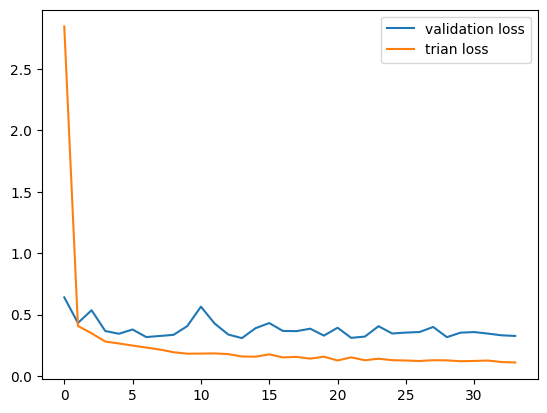

In [ ]:
plt.plot(history.history['val_loss'], label='validation loss')
plt.plot(history.history['loss'], label = 'trian loss')
plt.legend()